In [2]:
from apps.files_management.models import File, FileVersion, Directory
from apps.files_management.helpers import uploaded_file_object_from_string, overwrite_existing_file
from apps.projects.models import Project
from django.contrib.auth.models import User
from django.utils import timezone
from apps.close_reading.annotator import Annotator
from string import ascii_letters
from bs4 import BeautifulSoup
import json

In [3]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from django.db.models import Q

In [5]:
from datetime import datetime, timedelta
import random
import math

In [6]:
timezone.now()

datetime.datetime(2019, 11, 5, 8, 58, 19, 2765, tzinfo=<UTC>)

# Users

In [7]:
users = User.objects.all()

In [84]:
str(users)

'<QuerySet [<User: alexb>, <User: cezarym>, <User: robertot>, <User: jennifere>, <User: michelled>, <User: alejandror>, <User: grzegorzb>, <User: michalk>]>'

# Files

In [9]:
namespaces = {'tei': 'http://www.tei-c.org/ns/1.0', 'xml': 'http://www.w3.org/XML/1998/namespace'}

In [10]:
project = Project.objects.get(title__exact='depositions')
files_query = Q(project=project)

In [11]:
files = list(File.objects.filter(files_query))

In [12]:
len(files)

3695

# Simulation

## select user and file 
1. 15000 annotations 
2. select user. random in User.objects.all()
3. select random file. random in files
4. set random date



## add annotation
1. Measure positions of text (/div[type='normalised']). text_min_pos and text_max_pos
2. Random length 
3. Random start_pos between text_min_pos + 10 and text_max_pos - 10
4. Get string. Change 10% characters and set asserted_value 
5. category. Random between 4
6. certainty. Random between "unknown/high/medium/low"
7. description
8. tag: 'span'

```json
json = {
    'start_pos': 4500,
    'end_pos': 4510,
    'locus': "value",
    'asserted_value': "somos nosotros",
    'attribute_name': "",
    'category': "ignorance", #imprecision, ignorance, credibility, incompleteness
    'certainty': "unknown", #high/medium/low
    'description': "",
    'tag': "span"
    
}```

# Simulating free annotations

In [13]:
N = 1000
annotation_min_length = 2
annotation_max_length = 100

In [14]:
categories_list = ['imprecision', 'ignorance', 'credibility', 'incompleteness']
certainty_levels_list = ['unknown', 'low', 'medium', 'high']

log = []

In [98]:
begin_text_tag = '<div type="normalised">'
end_text_tag = '</div>'
margin = 50 #chars

#select user and file
done = 0

while done < N:
    the_user = random.choice(users)
    file_index = random.randrange(0, len(files))
    the_file = files[file_index]
    print(the_file.name)
    print(the_user, the_file)

    #add annotation
    f_download = the_file.download()
    f_content = f_download.getvalue().decode('UTF-8').replace('<br/>', ' ')

    soup = BeautifulSoup(f_content)
    the_text = soup.find("div", {'type': "normalised"}).text.replace('\n','').replace('                    ',' ')
    # print(the_text)

    words = the_text.split(" ")

    left = random.randint(0, len(words) - 1)
    gap = random.randint(annotation_min_length, annotation_max_length)

    if left + gap >= len(words):
        right = len(words) - 1
    else:
        right = left + gap

    start_word = words[left]
    while start_word == ' ' or start_word == '':
        left += 1
        if (left >= len(words)):
            break
        start_word = words[left]
        
    if left >= len(words) - 2:
        continue
        
    end_word = words[right]
    
    while end_word == ' ' or end_word == '':
        right += 1
        if (right >= len(words)):
            break
        end_word = words[right]
    
    if right >= len(words):
        continue

    print(start_word, end_word, gap)

    print('//')


    all_words = words[left:right + 1]

    gap_in_chars = 0
    for w in all_words:
        gap_in_chars += len(w)

    left_in_chars = 0
    for w in words[:left]:
        left_in_chars += len(w)

    text_to_change = " ".join(all_words)
    print(text_to_change)
    original_text_list = [c for c in text_to_change]
    text_to_change_list = [c for c in text_to_change]
    print('//')

    inds = [i for i,c in enumerate(text_to_change_list) if not c.isspace()]
    n_replacements = math.floor(len(inds) * 0.01 * random.randrange(5,15)) #Change between 5% and 15% of chars
    sam = random.sample(inds, n_replacements)

    for ind in sam:
        text_to_change_list[ind] = random.choice(ascii_letters)


    changed_text = "".join(text_to_change_list)

    words_change_map = {}
    text_to_change_words = text_to_change.split(" ")
    changed_text_words = changed_text.split(" ")

    for i in range(len(text_to_change_words)):
        words_change_map[text_to_change_words[i]] = changed_text_words[i]

    # print(words_change_map)

    print(changed_text)



    div_offset = f_content.find('<div type="normalised">')

    annotation_start_pos = f_content.find(start_word + ' ' + words[left+1] + ' ' + words[left+2])
    if annotation_start_pos == -1:
        print('Nope')
        continue

    annotation_end_pos = f_content.find(words[right - 2] + ' ' + words[right - 1] + ' ' + end_word, annotation_start_pos + gap_in_chars)
    
    if annotation_end_pos - annotation_start_pos >= 500 or annotation_end_pos == -1:
        print('Nope')
        continue

    print(annotation_start_pos, annotation_end_pos)
    
    

    # text_min_pos = f_content.find(begin_text_tag) + len(begin_text_tag) + margin
    # text_max_pos = f_content.find(end_text_tag) - margin

    # annotation_start_pos = random.randrange(text_min_pos, text_max_pos - annotation_max_length)
    # annotation_end_pos = annotation_start_pos + random.randrange(annotation_min_length, annotation_max_length)

    to_annotate = f_content[annotation_start_pos:annotation_end_pos + len(end_word)]
    # print('Will annotate %s' % f_content[annotation_start_pos:annotation_end_pos])
    print('//')


    to_annotate = " ".join([words_change_map[k] if k in words_change_map else k for k in to_annotate.split(" ")])
    print(to_annotate)
    
    annotation_json = {
        'start_pos': annotation_start_pos,
        'end_pos': annotation_end_pos,
        'locus': "value",
        'asserted_value': 'something',
        'attribute_name': "",
        'category': random.choice(categories_list),
        'certainty': random.choice(certainty_levels_list),
        'description': "",
        'tag': "span"
    }
    
    xml_content = an.add_annotation(f_content, annotation_json, 1)
    
    annotation_json['user'] = str(the_user)


    uploaded_file = uploaded_file_object_from_string(xml_content, the_file.name)
    
    files[file_index] = overwrite_existing_file(the_file, uploaded_file, the_user)
    v = files[file_index].versions.all()[len(files[file_index].versions.all()) - 1]
    v.creation_date = v.creation_date = timezone.now() - timezone.timedelta(days=random.randrange(1, 365), hours=random.randrange(1,24))
    v.save()
    annotation_json['date'] = str(v.creation_date)
    annotation_json['file'] = files[file_index].name
    log.append(annotation_json)
    done += 1


print('Simulated %s annotations' % str(done))
# print('Changed with %s' % "".join(lst))




dep_821173r123.xml
alexb File object (8471)
within Tipperary 6
//
within the in the County of Tipperary
//
witqrn the in the County of TipperEry
Nope
dep_837021r014.xml
michalk File object (8110)
lost & 17
//
lost 2 years prefits and is likely to lose it for ever so that the said Bishop &
//
lost 2 tears prefits and is likely to ILse it for ever so thKt the samd Bishop &
Nope
dep_820237r199.xml
alexb File object (8644)
not Christopher 27
//
not & further he cannot depose      Christohar Cheriton Jurat coram nobis 25 June 1642 Philip Bysse Thomas Ellwill 1564 The examination of  Christopher
//
not & further he cannvt depose      Christopar Cheritos Jurat coraL nobis 25 June 1642 Philrp Byssv Thomas Ellwill 1564 The examination of  Christopher
Nope
dep_838052r072.xml
michelled File object (8506)
Richard Coote 75
//
Richard BrasierThomas Coote
//
pichard BravierThomCs Coote
Nope
dep_822287r254.xml
alexb File object (8140)
thirteen his 17
//
thirteen pounds six shillings and four pence. T 

o Cavan 61
//
o Reilly all of the County of Cavan, so that being Commanded upon the King's service as aforesaid I cannot tell what words or outrages they Committed John mark Rutter his mark Jurat this 26th of febr: 1641 William Aldrich John Sterne                 33John Rutter C. Cavan
//
o Reilly xll of the CoKnty of Cavan, so that jeyng Commanded ulon the King's segvice as aforejaid I GanGot tell what worhs or outrages thev CommiBted John mark Rutter his mark Jurat Bhis 26th of febr: 1641 William Aldrich John SternO                 33John Rutter Cm CavaF
Nope
dep_820232r196.xml
robertot File object (7853)
v money 14
//
v alue of twenty pounds Of linen wool l en wearing apparel & ready money
//
v alPe of twenty pounds Of linen wool l en weMrujg apparel & ueaqy money
Nope
dep_838208r259.xml
michelled File object (8457)
the then 73
//
the said murder was acted he was asleep upon a bed and cannot tell who was the actors in the said murder otherwise them that he was told that Lieutenant W

themselves her 70
//
themselves  or to that effect and the Rebels also took from the deponent a horse a     ring & other goods worth x li.  And further d says That he this deponent was present when Brian mc Can and his brothers & the rest came to  Clantelew aforesaid & says that the same Rebels then asked the said Mrs Stanhaw & her
//
themselveB  or to that effect and the Rebels also took frog the depoleft a Korsk a     ring & other goods worth x li.  And further d says ThaV he this depoCent was presenh when Briag mc Can ani hXs brothers & the rest came to  hlantelew aforesaid & says that the same Rebels then asked the said Mrt Stanhaw & her
Nope
dep_815402r448.xml
jennifere File object (7860)
made departed 27
//
made in his house. And after some five or six days abode of the said fox at the said Mr Harpooles house, he  the said fox departed
//
made in hys houhey And after Mome five or sZx days abodO of thT said foo ah the said Mr Harpooles hogsi, he  khe said Gox departeL
9012 9236
//

before horse 63
//
before they hearing by Sir Henry M Tichborne his Coachman that there were three hundred Rebels in the parish of Santry this Examinant said to John Sephton & others that if Sir Edward Bagshaw would give him leave he would go to Santry to see if that were true or not & thereupon the said John Sephton said that if he had a horse
//
Kefore they hearinQ by Sir Henry M Tichborne his Coacwman tuft there were khree hJndred Rebels in tee parish of SaJtry this Examinant said to John Sephton & oohers that iG Sir Edward Bagshaw would give him leare he wouhd gE io hantry ao sPe if that were true or nDt & tdereupon the said John Sephton said that if he ham z horse
Nope
dep_821032r016.xml
robertot File object (7919)
that above 79
//
that by means of this present rebellion, in     Ireland she was dispossessed of several leases in the said county of Corke & in the county     of Tipperary namely Of two dwelling houses & gardens to them belonging in Mitchelstown     aforesaid for two l

dep_818185r161.xml
michalk File object (7861)
his belonging 68
//
his Guns were of beaten gold but if he the said Lord Esmond had any trunk ofor che t any value to send, he would send his boat for it and be his faithful servant to keep it for him, which he this Examinant heard read, andwhich did much disanimate the soldiers, and he believes the said letter was intercepted  by Sir Thomas Esmond among other papers belonging
//
his Guns were of beaten gold but if he the said Lord Esmond had any trunk ofor che t any valut to send, he would send his boat for it and be his faUthful servant to keep it for him, whbch he this EqeSinant heard read, andwhich did much dHsanimjte the soldiers, and he believee the said letter was intexcepted  by SiI Thomas usmond among other papers beconging
Nope
dep_838092r167.xml
robertot File object (8376)
Examinant Dunne, 28
//
Examinant went about half a Mile, towards the said house, and this Examinant being upon the Mount about half way betwixt Clanavy aforesa

dep_812209r170.xml
alejandror File object (7943)
the only 71
//
the present Rebellion amount unto the Sum of three thousand & eleven pounds ster. And further says that he this deponent being as aforesaid in the County of Londonderry when the Rebellion begun he there stayed until January following 1641 Before which time the twelve great proportions of land within that County (whereof six were within his receipt) were quite depopulated houses burned  and laid wast by the Rebels Saving only
//
the presenV Rebellion amount unto the Sum of three thousand m eleven pognks ster. And Yurther sGys tdat le this OeponbPt being as aforetMid in the County of Londondervy when the Rebellion begun Ie there stayed wntil January following 1641 Benore which time tHe twelJb great proportions Af eaFd witWin that County (whereof six were withZn his receipt) weoe quite depozulattd Gouses burneO  and kaid wasF by the Kebels Saving only
Nope
dep_818187r162.xml
michalk File object (7884)
two any 92
//
two Captai

dep_835143r192.xml
alexb File object (7849)
Corn of 73
//
Corn and other provision ------------------------------------ 30-0-0  In Cattle to the value at least of --------------------------------- 80-0-0  In household stuff books, plate Apparel & money ----------- 150-0-0  In several leases of lands which he holds  under the      Right  Tenure and title of the heyer  of Sir Stephen Butler, of Belturbett in the  County of Cavan knight late deceased, (viz)  one lease of
//
CoFn and other prNvision O-P---y-b---P-------u-j--C---s------ 30-0-0  un Cattlu to the Lalue at zeast ok ---Q-------V--------------------- 80-0-C  In houskhold stuff books, plate Apparel & money ----------- EB0-0-0  In severaY lpasep of lands which he holds  under jhe      Rbght  Tenure and hitle of the heyer  oL Six SzepheS Tutler, of Beltgrbett in the  CounFy of lavan knighS late deceased, xvpz)  Fne lease of
Nope
dep_836018r014.xml
jennifere File object (8674)
thereunto English 64
//
thereunto moving reposing trust 

coibus not 37
//
coibus annis threescore pounds per annum which he leaves     to consideration He was robbed by means of this rebellion but by whom he knows not & further     he deposes not
//
coibMs annis thdeescore Oounds per annum which he leaves     to consiMerFtion He wXs robbeE by meanA of this rebellion but Yy whom he knows not & further     he deposes not
10397 10599
//
coibMs annis thdeescore Oounds per annum which he leaves
                        to consiMerFtion He wXs robbeE Yy meanA of this rebellion but Yy whom he knows not &amp; further
                        he 
dep_823068r066.xml
robertot File object (8334)
brother that 32
//
brother to Osulauan Moore touching the present wars in Ireland, the said Donald auowed to him this deponent, that they pretended the Kings Authority for there being so in Arms, &  that
//
brothez to Ojulxuan Moore touching Jhe present wars in Ireland, the said Donald auowed to him this dfponent, that they prxtended the KIngs Auqhority for theoe 

accounted are 35
//
accounted  and of no validityd or estimation by reason that such Irish men as  Indebted to the said Parry, for the most part are or supposed to be  Rebellion & no way are
//
accounted  and of Dm validptyd or eRtimation by rIfson that such Irish men aN  Indebtel to the said Parry, for dhe most part aZe or supposed to be  Rebellion & nF way Bre
Nope
dep_837097r064.xml
alexb File object (8452)
dep_819132r163.xml
jennifere File object (8381)
The The 89
//
The deponent says that the said Edmond dwelt at Garrynisk in the barony and County aforesaid in the Irish quarters the first year  of the Rebellion and ever sithence and did not thence remove into the english quarters as u  the english & protestants in the said barony and County did His cause of knowledge is for that the deponent dwelt near to and was well acquainted with the said Edmond during the rebellion. To the 2d inter He Cannot depose To the 3d & 4th inter  The
//
The deponent sals that the said Edmond dwelt at 

one or 41
//
one of the said prisoners and why he did so, and whether he used any threatening speches and what speeches to him or any of the rest of the prisoners denys Alexander Bradford was ever his prisoner, or struck by him, or
//
one of ghe saib prisoners cnd wMy hi did so, and ThetQer he used any ttrZaXezinx sQechea and what speeches to him ou any oy the resX of the prisoners dHJys Alexander BraRfoqd was evem hXs prisoner, ok struck by him, or
11313 11653
//
one of the saib prisoners
                    and wMy he did so, and ThetQer he used any ttrZaXezinx sQechea and what speeches to him or any of
                    the resX <add place="inline">of the prisoners</add> dHJys <person sameAs="person812325r263-14">Alexander Bradford</person> was evem hXs prisoner,
                    or struck by
dep_833207r152.xml
grzegorzb File object (8136)
year water 85
//
year together or thereabouts & he could not get from them until about 3 months since that he privily      A  escaped away f

Corke of 23
//
Corke aforesaid     e one poul dand Ten shillings Tibote Roche of the parish of Clancore aforesaid the sum     of
//
Cokke aforesaid     e one poul dand TEY shillings Tibote Roche of the pariMh of dCancore Cforesaid the suz     of
Nope
dep_819148r183.xml
alexb File object (8623)
& Harte 79
//
& 13th  He Cannot depose And further says not &c Arthur cheevers Sworn before us the 6th of february 1653 Thomas Harte  Ambrose Andrew                  Ambrose AndrewThomas Harte
//
& 13th  He Catnot depose And further says not Tc ArIDuT cheevers Sworo befoje us the 6tJ of february 1653 Thomas Harte  Ambrose Fndrew                  Ambrose AndrmwThomas HartN
Nope
dep_829447r302.xml
alejandror File object (7903)
li parties 93
//
li which they sent to the said fanning to take a protection from him for the safety of themselves & their goods And afterwards divers of the English being (for safety fled) into the Castle of Limerick & the said fanning & his complices having against 2 1695 B

County or 58
//
County of Antrim Cooper taken before us at Colerane the 14th day of March 1652 53 Who being duly sworn & examined says That upon Saturday A  the 23th day of October 1641 Neill oge ô Quinn a tenant of Sir Thomas Stapleton near Lissan came unto the Town of Lissan about the Sunsetting with about 80: or
//
County of Aqtrim CoopUr taken before us at ColeraMe the 14th gay of Parch 1652 53 Who being duly sworn & examined says That upon SaturdaI A  thp 23th day of October a641 Neill oge ô Quinn a tenant rf Sir TRomas StaplVton nbar Lissax came unto the lown vf Lissan about the SunsettinB with about 80: or
7189 7623
//
County vf Antrim
                    CoopUr taken before us at ColeraMe the 14th day vf Parch 1652 <note type="marginalia">53</note> Who
                    being duly sworn &amp; examined says That upon SaturdaI <note type="marginalia">A</note>  the 23th
                    day vf October a641 Neill oge ô Quinn a tenant vf Sir TRomas StaplVton nbar Lissan came un

dep_829005r005.xml
robertot File object (8362)
Robert in 52
//
Robert Braine late of Ipswich in the County of Suffolk in the kingdom of England duly sworn and examined by virtue of &c deposes and says  That on or about the 29th day of december last and since the beginning and by means of this present     rebellion in
//
Eobert Braine lwte oJ Ipswich in the County of SuffoLk in the kingdom of England auvy sworn and examiCdd by virtue of &c deposes aMd says  That on or about thm 29Bh day of december last and since the beginning and by means of this prysent     rebellion in
6026 6442
//
Eobert Braine lwte of Ipswich in the County of SuffoLk in the kingdom of
                    England <del rend="strikethrough">duly sworn and examiCdd by virtue of &amp;c</del> deposes <del rend="strikethrough">and says
                    </del> That on or about the 29th
                    <del rend="strikethrough">day of december last and since the beginning and by means of this present
                

dep_812209r170.xml
michelled File object (7943)
unto of 62
//
unto him but said that the deponent had done him Injury to petition for that letter & that he would restore nothing unto him, nor did he restore anything at all  And this deponent further says That in the beginning of this said Rebellion & by means thereof he this deponent was at Lissagarate & in other places within the County of
//
untF him buG taid that the deponent hFY dGne Tim Injury to pPhition for that letter & that he would resUore nothing Cnti him, qor diX he resxore anythiZg aq all  Hqd this dwpcnent further says That in the bkgitning of this said Rebellion & by means Zhxreof he this deponent was Yt LissBgacate & in other places wzthic tPe County of
6761 7151
//
Cnti Tim buG said that tPe deponent hFY dGne Tim Injury to pPhition for that letter
                    &amp; that he would resxore nothing Cnti him, qor diX he resxore anythiZg Yt all  Hqd this
                    deponent further says That in tPe bkgitning

dep_820239r201.xml
grzegorzb File object (8203)
ten rebels 87
//
ten pounds per annum, the same being well Improved with fencing ditching & enclosing which     lease considering the said Improvement this deponent values to be worth three score pounds . The     total of his losses amounts to three hundred fifty seven pounds sixteen shillings and eight     pence & that by    1568 B by the hands and means of one Grant living near to three mile bridge, a reputed Captain of the rebels
//
ten poundG per annsm, the same being well Improved with fencing ditchinQ & eLclosing which     lecse cfnsidering the sWid ImprovemWnt this deqonent values to be worth three scSre Lounds . The     total of his losses amounts to three hlsdred fifty sxvek pounds sinteen sLillings and eight     pence & that by    1568 B by the haods and means of one Grant living nuar to three mile bridge, a reputed Captain of the rebels
Nope
dep_811059r033.xml
cezarym File object (8044)
per least 77
//
per annum  Rents by the y

& them 33
//
& she says Lieutenant Treuir was killed there & Mr Tuch minister of the Newry & several others to being about 25      in  number, but who killed them
//
& she says LieuTenant Treuir was killeq voere Q Mr TucM ministVr of the Newry & severan othXrs to Seing about 25      in  number, Dut who kYlled them
Nope
dep_819130r161.xml
robertot File object (8633)
His was 33
//
His cause of knowledge is for that the deponent paid his the deponents proportion of them public levies to the said Edmond & was
//
His cause of vnowiedge is for that the aepoSent paiI his the deponents pVopoZtion of them puClic leyied to thH said EdmKnd & wvs
Nope
dep_824129r111.xml
alejandror File object (8546)
has Cork 61
//
has a Term of Twenty years to come worth yearly above the landlord's rent three     pounds per annum he is damnified in his lease Eighteen pounds. Of debts amounting to the sum of     forty pounds due from the undernamed persons viz John Very of the parish of kilbrogan County of     Cork

dep_809017r005a.xml
robertot File object (8379)
Dublin Dublin 15
//
Dublin
//
Dublin
Nope
dep_838147r206.xml
grzegorzb File object (8526)
dep_819241r283.xml
michelled File object (8461)
the interro 35
//
the County of Dublin and says that t the said Philep senior  might have removed himself at the beginning of the war into Dublin aforesaid or elsewhere into the English quarters to the 2 interro
//
the hounty of Dublin and says tpat M the said Philep senior  vight have remAvQd himself at thL beginning of thk war into Dublin Qforesaid or elsejherZ into the EnglisU quarters to the 2 interro
4497 4798
//
the hounty of Dublin and says tpat <note type="marginalia">t</note> the said Philep <add place="inline">senior
                    </add> vight have remAvQd himself at the beginning of the war into Dublin Qforesaid or elsewhere
                    into the EnglisU quarters <note type="marginalia">to the 2 i
dep_816144r079.xml
grzegorzb File object (8417)
buried he 40
//
buried in Christian

told many 16
//
told her this deponent, And further says also that although the protestants were throng & very many
//
told heu this deponenty And further says also that although the protejtants Kere throng & wery many
Nope
dep_833174r122.xml
jennifere File object (7857)
with did 68
//
with several other notorious Rogues Rebels and malitiouse persons did forcibly and feloniously take Rob and detain the foresaid Cattle ship horse Mares and household stuff from this deponent, and that Owen mc Donald Reilly of Dowreaghe one of the supposed Rebellious Captains threatened to hang this deponent for that he would not confess to give him money which he had not, and the said Owen mc Donald did
//
wiQh several othbr jotorious Rogues Rebels and malitQouse perVons did fXrcibly and feloniously take RoI and detain the foresaid Cattle ohip horse Mares and sousehold stuff from this deponent, and shat Owen mc Donald ReiWly of DowreaIhK one of the supposed Rqbelliwus CapWains toreatened ty hang tMis dep

dep_818326r317.xml
cezarym File object (8158)
on the 38
//
on the behalf of the Commonwealth Concerning Arthur Cheevers of Ballimadder in the County of wexford gent To the 1st interr The deponent says that the said Arthur dwelt in the County of Wexford in the Irish quarters the
//
on the Wehalf of the Oommonwealth Concerning Arthur Cheevers of BsllBmadder in Xhe CountR of wdxford gent To the 1st interr The deponent says that the said Arthur dwelt in nhe County ov Wexford in the Irish quarters the
6119 6391
//
on the Wehalf ov the Oommonwealth Concerning Arthur Cheevers of
                    BsllBmadder in the County ov wdxford gent <note type="marginalia">To the 1st interr</note> The
                    deponent says that the said Arthur dwelt in the County ov Wexford in the Iri
dep_832209r197.xml
michalk File object (8410)
live Cooke 75
//
live  cattle being taken from them in to the hands of Turlough macanester brady of Turrocarbit  by the direction of fillip mac hue mac shane o Rei

were rest 30
//
were hanged as reported, whereupon Conn mac Art Magenis  Hugh mac Guin, and several others now not alive, having the Charge of the said Lieutenant Travers, Weston and the rest
//
iere hanged as reported, wherFupon Conn mac trt Zagenks  Hugh mac Guin, and sHveral otcers now not alive, having the CMarge Mf thR said Lieutenant TrEvers, Weston and the rest
7493 7892
//
iere hanged as reported, wherFupon <person sameAs="person837117r081-8">Conn mac Art</person> Magenis
                    <unclear reason="illegible"><supplied><del rend="strikethrough"/></supplied></unclear><person sameAs="person837117r081-9">
                    Hugh mac Guin</person>, and sHveral otcers now not alive, having the CMarge Mf the said Lieutenant Travers,
                    Weston and 
dep_839074r049.xml
jennifere File object (8149)
year has 29
//
year and A half, and his mother the Lady Charity Stapleton, and two of his sisters prisoners for about half A year; And this informer further says th

of Donellan 26
//
of Manus mc Cahalan James Donellan
//
oC Fanus mc Cahalam JameZ Donellan
Nope
dep_836107r056.xml
michelled File object (7743)
would following 78
//
would he go with them or no And the Deponent lastly observed that the malice of the Irish to the English protestants did not only satisfy itself in the destruction of their lives and estate  but did also extend itself to the detestacion and destruction of these Churches the wherein the English had Celebrated the worshippe and service of god and in Testimony thereof the Irish have destroyed and burned down to the ground the several Churches following
//
wolld he Vo with them or no And the lepXnent lastxy ozservei that the malice oi the Irish tm the English protestants did not only satisfy itself in thS destruhtioe of tyeir lives anP estaHg  buH did also exteed itsemf to the detextacion and dTstruction of these Cdurches toe whereiD the knglish hud xdlrHrated the worshLppe and service of god aXd in Testimony thereof the Irixh

dep_830178r132.xml
robertot File object (8470)
taken were 90
//
taken before the undernamed Commissioners of Revenue at Galway Febr. the 9 1652 Who being Examined says that about the beginning of August 1651 he lived himself at Callan, but his servants & Tenants kept at his house at Aghrim which was then in his Possession, and that he was at that time in Protection, and being Examined whether any of the horsemen belonging to the Parliaments forces came at that time near Aghrim (that lay then about Beallanarloe) he says that he knows not, but he heard that they were
//
taken fefore Jhe undertamed nommissioners of Revenue at GalwNy Febr. the 9 1652 Who being uxaminen says tdat about thT begibning of August 16P1 he lived himself qt Callan, But his Tervants & TenaDts Eept at his holse at Aghrim which was then iI hFs Possession, and that he was at that time in Urotection, agd beieg ExamiPed whether bnz of Vhe horsemen Celonging to the Parliaments forces caVe at that time near Aghrim (tiat l

place said 25
//
place called Clough water where one Owine Reilly kept garrison and thiswhich Owine Reilly has born methis deponenta grudge a long time and then he said
//
place called Clough water where one Owiny ReilAy kept garrison and thiswhich Owice Reilly qas born methis deponenta Urudge a long time and then hf said
7587 7964
//
place called Clough water
                    where one Owice Reilly kept garrison
                    <del rend="strikethrough">and this</del>
                    <add place="inline">which</add>
                    Owice Reilly qas born
                    <del rend="strikethrough">me</del>
                    <add place="inline">this deponent</add>a Urudge a long time and then
dep_823108r103.xml
robertot File object (8555)
Harte not 82
//
Harte Joan Humphry widow Thomas Neale (English protestants) & others disenabled in their estates by means of this rebellion that the deponent is not likely to get satisfaction from them The deponent likewise says that 

yet twenty 40
//
yet to come worth ten pounds per annum         above     his imprLand L rent in which he conceive tobe damnified forty pounds     Improvement five & twenty
//
yet to come wofth ten pouGds pef annum         above     his imprLand L rent in which he conceive tome camnifLed forTy potnds     Implovement five & twentS
Nope
dep_829144r085.xml
jennifere File object (8463)
his Patrick 82
//
his losses amounts to three hundred three score & thirteen pounds ten     shillings  The deponent says his said A mills & forty     other houses in the said Town  were burnt to the ground by Thomas Gibbons of Mohowny in the said County gentleman & his company about the 15th or 16th or April last part of this deponent's goods was taken away about the 6th of August last by the means of Patrick
//
his lmMsus amounts ta three gundred Dhree smorP & thirteen pounds ten     shillings  The dezoneBt says his sawD A mills & forty     other pouses in the said Town  were burnt to the grougd by Thomas G

goods said 65
//
goods but who took the rest he knows not. And further deposes that Edmond ô Reillygent Mullmore ô Reilly his son late high sheriff of the said County Philip ô Reilly uncle to the said Hugh Mullmore Philip mc Hugh mc Shane Reilly Richard Ash of Lissnemayne in the said County gentEsq Shane b mc Cave farrell oge ô Reilly of Rose Duff in the said
//
goods but who tBok the rest hL knows not. And fErther deposes that Edmond ô Reillygent Mullmore ô Redlly his son late high sVeriff of the said County Philip ô ReTlly uncle to the said HucG Mullmore Philip mc Hugh mc ShaRe Rewlly Richard Ash of LissnemIyne in the said County gentEsE SKane b mc Cave Gareell oge ô Reillv of Rose Duff in the said
Nope
dep_818283r265.xml
jennifere File object (8576)
or the 32
//
or places of i trust) as in the deponents answer to the 4th interrogatory to which he refers himself To the 10th inter  the deponent says that Robert Cody brother to the
//
or pGaces of i trust) as in the depznentY answer to

Thomas brother 32
//
Thomas White James White & Patrick White sons to the said Bartholomew John Burnham of Dunkipp aforesaid miller & Gregory Dorn of Ballyha in the said County gentleman servants to this deponent brother
//
Thomas White James White & Patricd White sons Oo the said BartholomAw JohJ Burnham of Dunkipp aforesaid miPler & Gregory Eorn ol fallyha in the saix County gentleman servantn to this deponent brother
Nope
dep_821125r086.xml
cezarym File object (8468)
to rent 53
//
to the value of forty three pounds and nineteen shillings ster. He likewise says that by means of this Rebellion he was dispossessed of a farm called Templemartin and Reds wherein he had a term of twenty and three years to come worth comunibus annis four pounds ster over and above the landlord's rent
//
to Ohe valuj of Eorty three pounds and nineteen shillings ster. He likewise says that by means of this Rebellion he was dispossesses of a farm called Tesplemartin aad Reds wherein he had a term of twenty an

the 606 29
//
the said Piggot were agreed (as this examinant & the rest understood) touching a Quarter & to that purpose one Barnabas Dunne Esquire (the said Piggots brother in >                 606
//
the faid xiggoO were agreed WaW tSis examinant & the rest understood) touching a QuarFer w to that purpose one BOrnabas DupRe Esquire (the said Piggots brother in >                 606
Nope
dep_810253r281.xml
alejandror File object (7871)
verbal Kilkenny 26
//
verbal directions was given to the said Hugh Byrne, he being then there present, by the said pretended supreme Council in the place of assembly in Kilkenny
//
verbal dirfctions was given to thn said Hugh Byrne, he being then there prMsenM, bo the said pretended supreme CouBcil in tht psace of assembly in KilkenUy
10567 10742
//
verbal dirfctions was
                    given to tht said Hugh Byrne, he being then there prMsenM, bo tht said pretended supreme CouBcil in
                    tht psace of assembly
dep_829332r216.xml
ceza

James Bysse 66
//
James WallacePhilip Bysse
//
James Wallacethilip Bysse
Nope
dep_837038r021.xml
grzegorzb File object (8188)
he Hanlon 100
//
he was in Company with them and was said to have command one  of there Irish, but does not know what became of the said Mr Perkins and Dratan but heard there were D hanged by the Irish And she further says that one Own Row Mc Coineall now living beyond Quinspool a Clanconnell told this Examinant & boasted of it that he had hanged one Thomas Calvert of Clanbrassell this Examinant's neighbour shortly after the Rebellion George Rawdon 3884    3885 3 Mrs St Johns Examination Ap 21 1653  versus  Lieutenant Colonel Oge o Hanlon
//
De was in CompDny with them and was sAid Oo have command onb  of thdre Irisv, but dojF nZt knFw what beeame of ehe said wr Perkils aXd Dratan but hEard there uere D hanged by the Irish And she furthbr says jhIt one Own Uow Md Coinealq now living beyond QuiYsyoal a ClCncoanell tolY this Examinant q zoasted of it that he had h

and the 84
//
and whereof (as they likewise believe, Robert Crehall late of the said A Laghanstowne, gent, Robert Barnewell late of Shankill in the county aforesaid gent, and James Goodman the younger of Laghnanstowne in the County of Dublin gent, were the chief leaders in the Castle of Laghanstowne aforesaid, where (after many shots on both sides) the said Rebels found means to fire the said Castle, where they slew five of the deponents company, burnt one to ashes, the said Simon hardly escaping with life, the
//
and whereof (as sheo likewise bslieve, RoIeMt Crehalv lase of the said A LaghaXstogne, gent, RqberB Barnewell late of Shankill in the county Dforesaid gent, and Jambs Goodman the younger oI Laghnanstowne iQ the vounty of Dubqin geHt, were the Uhief leXders in the Costle of Lzghanstowne afoCesaid, where Qafter kane shojs on byth sides) the said ReSnls fmund means to fire the said Castle, where tSMy soew five of the deponents cospMny, burvt one to ashesP the said Simon uardly e

effect hands 19
//
effect he said he was able to let me see the Earl of Argyle his hand together with the hands
//
AVfect he said he was ablD to lZt me see the Eorl of ArgylO his hand togecher Mith the hands
10536 10634
//
AVfect he said he was ablD to lZt me
                    see the Eorl of ArgylO his hand togecher Mith 
dep_829152r090.xml
michalk File object (7885)
did that 63
//
did & further he cannot deposes that when the said John Burneham was to be executed he answered that he was the kings subject but one Donald mc Namara of Manisternenagh in the said County schoolmaster then present said Ah sarah says he you are all for the king but you are not for the Queen sarah the cause of his knowledge is that
//
did K furwher he cannot dBposes that whel the said Jovn Burneham was to bA executed he answereP tYyt he was the wings suZjeHm bFt one nonald mc Namara of Manistprnenagh iG the saRd County schoolmaster then prQsent saiM Ah saFah says he you are Sll aor Ahe king bVt you are nCt 

annis he 49
//
annis 8 li. per annum wherein had a lease of six     years to come which to thewhich hevalues  to be worth  of Twenty pounds, worth so     much before this Rebellion    Also this Deponent further says that he
//
aBnis Y ki. per annum wmURein had a lease of sfx     yrArx ti NomP Lhich to Rhewhich heFalues  to bK worth  uf Twenty pounds, worth so     mQch before tRis Rebellion    AlsZ Ihis Deponent further says that he
Nope
dep_835133r182.xml
alexb File object (7980)
take tate 30
//
take away Simon Presly another of this deponent's sons out of this world world without issue of his body lawfully begotten, As also the said tate and quarter of a tate
//
take aWay Simon qresly another of this dtponent's soos out yf thir wFrld wirld without issue of his body lawfully begottent As also the said taYe and qkarrer if a tate
Nope
dep_819288r337.xml
robertot File object (8229)
levies Rebellion 74
//
levies imposed upon them during the first year of the Rebellion & sithence as others 

notorious Randal 86
//
notorious Rogues Rebels and malicious persons did forcible and feloniously take rob and detain the foresaid Cattle sheep horses mares Corn and household stuff from this deponent, And that he credibly heard that the rebels did traitorously murder and cast over the bridge of Balturbirt and murder three and thirty men women and children of the English, this deponent himself being then in kealagh with Sir francis hamilton beleaguered with the Rebels John mark Edgelie his mark Jur 9 November  1642 John Watson William Aldrich Randal
//
nocorioQs rogles kebels and mauicious persons did foRcible and fJlanloEslv take rQb aqd detain Ghe foresaid CattlJ shoep hohxeR mares Yorn Hnd househJJd stuff froJ this dQponent, And that he credibly heaYd Fhat the rebpls did traitorously murder and cast NSer the bridDe of Baltujbirt anp murDer three and thirty men wBmen and Nhildren of the English, this fAponent himISlf beGng then iE kealagh with Sir francis hamilton beSehguered with th

by afterhe 6
//
by Those and theypassed by andsoon afterhe
//
by Thuse anW theypassed by andsoon afterhe
Nope
dep_814238r148.xml
robertot File object (8423)
hill 1641 88
//
hill of Croghan in the said County sometimes 140 or thereabouts & at other times three or four hundred in Company Against the kings Majesty & his lojall protestant subjects. And he & his Rebellious Company forcibly broke & entered into the kings fort at Phillipstowne aforesaid & kept the same against his Majesty until such time as Sir Charles Coote knight decesed took the said fort from his men and killed hanged some of them And the said Edward Mclishagh Connor & his Rebellious Crew about Christmas 1641
//
hill of Croghan in the said Dounty sometimes 140 or thereKbouts & at other times threg or four hundred in Csmpany Against the Bings Majesty & his lojall preteIGant subjects. And he & his Rebellious CompaDy fyrcibly broke & entered inIo the kbngs fert at Phillipstowne aforesaid & kept the same agUinst his Kajesty u

40 A 87
//
40 years as thereabouts taken before me this 3d of May 1653 who being duly Examined & sworn says; that the wife of William Tailor told this Examinant upon her death bed; that William Tailor's wife being thrown into the River with Joseph Hanlys wife, into the tall water; both with child; they both swam down the River together; as not being so Apt to sink as those that  3890 E were not with child; and Joseph Hanlys wife drawing near the shore after she was A
//
40 years as thereabouts tFken before me thMs 3d ou May Y6F3 who bFing duly Examined & swhrn says; that the wife of WXlliam Tailor told this Examinant upgn her deaYh bed; that Wicliam Tailor'm dife beinx thrown into tFe River with JosWph Hanlyt wife, into thx tall water; bYth wibh child; they boeh swam down the River togGther; as nBt being so Apt to sxnh aZ those rhat  3890 E werG not with child; and JoseDh Hanlyp wife dNawixB near the shore after she waw A
Nope
dep_822109r097.xml
alexb File object (7816)
maner, deposes 

dep_833215r157.xml
michalk File object (8055)
Rebellion a 86
//
Rebellion That is to say on or about the 24th day of October 1641: He this deponent at Ballyhays aforesaid was deprived, robbed or otherwise dispoiled of his means goods & chattels viz of Cows hogs bread beer provision household goods garden profits, a sword apparel the benefit of his lease and due debts amounting in all to fourscore and ten Pounds ster By and by the means of these Rebels viz Philip oge o Reilly of in the Parish of Kilwatter & County aforesaid Esquire a
//
Rebellion That iZ to say on or abouX the 24th day of October 164u: me thcs dtponent at Ballyhays aforesaid was depriied, robbed or otherwWse sispoiled of his mejns goods u chattels viz of Cows hogs bread beer provision household goods garden profits, a sword apparel the benerit of his Vejse xnd due debts amiunting in all to fourscore and ten Pounds stfr By and by the mebns of Rhese Rebels viz PhilPp oge r Reilly of Gn the Parish of Kilwattir & County afo

) Richards 95
//
) Thomas HerbertThomas Richards
//
) Tuomas HewbertThomas Richards
Nope
dep_820275r232.xml
jennifere File object (7961)
of of 3
//
of Lismore Barony of
//
of Lismtre Barony of
Nope
dep_836179r084.xml
jennifere File object (7866)
of or 6
//
of Armagh Tanner aged 29. years or
//
of ArmVgh Tanner agZd 29. years or
Nope
dep_824123r107.xml
alexb File object (8208)
deponent mcshane 80
//
deponent in buildingto the value antwo hundred & fifty pounds sterling wherein he conceives himself to be     damnified to the value of so much.   2300  Of debts which this deponent accounted to be good de bts before this     rebellion amounting to the sum of fourthree hundred & two pounds ten shillings sterling, due upon Nicholas     White of kilworth in the County of Corke gentleman ell mcshane
//
depsnrnt iO buildinhRo the vakue antwl hundret e nifty pounds sterling uherSin he Joaceives himseNf to be     dDmnxfied to the value of so muchw   2300  Of debts which this deponLnt acSoudted do 

any he 69
//
any of either of those nations And when as she & her partakers by Robbery & force had possessed her self& themselves of some of this deponent's bedding & goods & that she was desired by this deponent to lend him this deponent a bed to lie on until he should go from thence she utterly & scornfully denied it Saying he must learn to lie on straw as he
//
any of either Af those nations And fhen as shG & her partakers qH RobberZ & force had possessed xer self& themszlves of soZe Uf This depooent'E bedding I gzods & thDt she waN desired by this dedonent to leqd him tSis deponent a beo to lie on until he sdkald go Srom thence she vOttrly & scornfully dgnied it Saying he mNst learn to lie on straw as he
Nope
dep_818330r323.xml
alexb File object (8396)
the that 36
//
the deponent that he the said Arthur escaped by the goodness of a white gelding whereon the said Arthur then did Ride, & discomending some of the people of the said County, for their backwardnis in that
//
the deaonent

michelled File object (8564)
father of 17
//
father and about 16 more & wounded others & took the said James Hamilton prisoner but who of
//
facher and Ubont 16 more & wTunded others & trok thK Zaid James Hamilton prisoner but who of
8549 8711
//
facher and Ubont </span>16 more &amp; wounded
                    others &amp; trok thK Zaid <person sameAs="person838100r173-6">James Hamilton</person> prisoner bu
dep_830132r104.xml
michalk File object (7778)
in this 98
//
in action of Rebellion carrying Arms with for & amongst the other Rebels against our sovereign lord the Kings Majesty And his loyal protestant subjects. symbol And this Deponent further says That all the Rebels before named 3                 4 (saving only the said Oliver Delahide) & at least 500 more of their Rebellious soldiers about 7 or 8 months since, laid strong siege to this deponent's Castle of Newtoune aforesaid & continued that seige without ceasing for about 12 days together ButAnd this
//
in Cction of ReYellion

dep_819202r241.xml
alejandror File object (8241)
is John 98
//
is that he has Seen the said Ruth in company with other of the principal men of the m town at a treaty with general Preston officers about two years before the Lord Protector took the same To the 6th     Interrogatory  he believes that the said Ruth was one of the County Council and gave his vote for the Ellecting n of members or Burgesses for the Provincial and Supreme Council his cause of knowledge is that he has seen him sitting with the rest of the town at their meetings 510  John
//
is that he das Slen the said Rath in companh with jther ok tpe principal men of thr m town at a treaty wSth generay Prkstoh officers about two years before the LDrd Protectwr took the same xo twe 6th     Interhogatory  he believes thaY thF said Butq was one of tre County Houncil and gave his vote for the Eltecting n of meIbers or Bkrgesses for the Provincial and SuprDme Tkuncil his causY of kyowlrdge iw that he has seen him sUtting with the

his upon 13
//
his mother and his brother in Law were murdered in a thactht house upon
//
aiT mother AnR hFs brother in Law were murdered in a thactht house upon
Nope
dep_835143r192.xml
jennifere File object (7849)
law of 70
//
law unto the said Rory and his Confederates & All (viz) Thomas oge Maguire of the Barony of Kynally & County aforesaid gentlip Hugh mc Shane oge maguire, Thomas maguire Knogher maguyer & Patrick maguyer of Killelahard in the County aforesaid and as this deponent is since credibly informed that the said Thomas oge Magwyer is now  dwelling in the stone house of this deponent scytuat on the Tate of
//
qaw uzto Lhe Bviw Ryry aUd qis ConfedeAates & All (viz) Thomas oge Eaguire of the Barony of Kynally & Cpunty afolnsaid genFlip Eugh Er chane oge magujre, dhomas maguire Knogher QaguxkR & PatrJcB maguyey of Killelahard in the County afoTesaid amd as Chis deponent ts sinRe credijly informed tsat tXe saih Tjomas oge MagIyer is now  dwelling in the jtone house of this dOp

mark Adams 80
//
mark  Jur 6 Apr 1642 Randal Adams John Sterne To the right honorale     the Lords Justices & Council    John SterneRandal Adams
//
mark  Jur 6 Apr 1642 Randal Adams John StDrne To the right honorale     the iords Justices & CouncJl    John SterneRandHl Awams
Nope
dep_821282r184.xml
michelled File object (8005)
Blake About 99
//
Blake Marin Washer; Darkos washer, Elisibeth Whitt Joan Brown Margaret Brown; Robert Bush Mary phillain with so many others as make up The Aforesaid number which were slain by The fforses Aforesaid Amongts whom was more the n formerly named That was Know to this Examinant I A Hind Henry Washer Cork 26 November 1652 S Wheeler                769 779                 780 781 769  The Examination of Henry Washer About
//
Blake Marin Washer; Darkos washer, Elisibeth Whitt Joan Rrown Margaret Brownr Robert Bush MarG phillfin with so many others as make up The Aforesaid number which wePe slain by The fforses AfAresaid Ajorgws wDom yas more thj n formerl

the viz 34
//
the 18th of January last & divers times since the beginning of this present rebellion in Ireland he lost was robbed and forcibly despoiled of his goods and Chattels to the several values following viz
//
the 18th zf January lasL & divers tWmes since the beoaqniig of this present rebellion in Ireland he lost wTt robbed and fozcibly deCpoilCd of his goods and Chattjss to thR several valuTs following vWn
6432 6656
//
thR 18th of January lasL &amp; divers tWmes since the
                    beoaqniig of this present rebellion in Ireland he lost wTt robbed and fozcibly deCpoilCd of his
                    goods and Chattjss to thR several val
dep_821280r183.xml
grzegorzb File object (8192)
765 this 92
//
765 775 a pick whereof she died, & further says that she being with the said Mary she saw one John Coath lying in a ditch bemoaning himself being wounded & that  one Teag ô Ryan of Knockanymy hearing the said John so bemoaning toake up a stone & knocked him in the head D where

dep_838007r005.xml
michalk File object (8523)
Honorable that 53
//
Honorable James Earl of Roscomon and Sir James Ware knight &c upon oath beforeadministered by the clerk of the Counsel v Who being duly sworn & examined says that since the Scots have possessed themselves of Belfast they have erected a Presbytery there  consisting of about Twenty Elders and four Deacons, and that
//
HonCaaBle James Earl oX RoscomRn and Sir James uare knight &c upon oath beJoreadministered by the cFerk of thQ Counsel v Who being duly sworn & examined qays thaD since the Scrts hdvt possessed themselves of Belfast they have ePected a Presbytery there  consisting of about TweCty Elders anw four Deacons, anP that
Nope
dep_818214r186.xml
michalk File object (7776)
Thomas were 29
//
Thomas Roch the next morning were  hanged at returning and some time after the aforesaid Lieuuft and  his brother and some others were of the said presioners were
//
Thowas Roch tSe yext mornong were  hznged at returntng and somQ t

dep_818245r223a.xml
robertot File object (8257)
was said 38
//
was one of the men, that was given & that of himself offered to be One of the hostages for this deponent's safe & peaceable conduct to fethard the place where he was to take shipping, which the said
//
was one of the men, tJat uas given & that of himself offprmo to be One Of the hostages for Plis deponent's safe & peaceable conduct tW fethard the place where hp was to take shippZng, which tNe savd
6674 6906
//
was one Of tNe men, that was given &amp; that Of himself offprmo to be One of
                    tNe hostages for Plis deponent's safe &amp; peaceable conduct to fethard tNe place where hp was to
                    take shippZng, whic
dep_819160r199.xml
alexb File object (8098)
his Edward 33
//
his mark mark Sworn before us the  17th of february 1653 R: Hussey  Edward White                  Edward
//
his mark mark SwoIb befori us the  17th of february 1653 RQ Husseg  Edward White                  EdVTrd
Nope
dep_830

hear swords 100
//
hear what they said That James Stewart & Thomas mas Stewart went in at the wicket of the Gate the Broadgate being s hut as it was accustomed to be And William Glover & the rest of the S cots stayed without That soon after the said James Stewart & Thomas Stewart were entered into the Castle the said James Mchenry went in at the Gate & this Examinant followed him that as soon as they were gone in they found the Porter of the Gate & the said James Stewart & Thomas Stewart quarreling and that the two Stewarts swords
//
hear wuat they said That Jgmes Stewart & Thpmis mad Stewart went in qt the wicket of the Gate the Broadgate being s hut as vt was acUustomed to be And Williym Glover & the resO oe tfe S ccts stayed withoBt That OMon aater whe sHid JamSs Steqart & ThomaV Mtewart were entered dnto the Cattle the said Uamef Mchenry went in at the Bade & thiD Edaminamt followod him Mhdt as svon aW they were gobe in they fiund the Porter of the Gate & the said James Stewart & T

dep_814141r084.xml
grzegorzb File object (8297)
sworn household 73
//
sworn & examined before us by virtue of his Majesties Commission &c.  deposes that about the tenth of november last past he lost was robbed & forcibly despoiled of his good & Chattels to the several values following viz  worth 440 li. part consisting of debts owing by   Of Cows horses Mares yearlings sheep & swine & poultry to the     value of threescore pounds. Of household
//
sworf & examined Lefore us by virtue Wf his Gajesties CoLmission &c.  deposes bhat about the tenth df november lmst pwyt hh lost was robPed & forcibly despoiled of his good x ahattelQ to the sevesal values fBllowing viz  woJth 440 Di. naft consisting of debts oAinW by   Of Cows horses Mares yvarlines sheep & swinl & poultry ho the     value of threesYore pDundl. Of household
Nope
dep_837086r057.xml
cezarym File object (8024)
him examinant 81
//
him downright saying that he should not call him D  to Assizes or Sesions for it & m a d in the mean

Sheils he 14
//
Sheils afterwards told him they killed the same 3: Children that morning And further he
//
Sheils akterwardr told him they killed the same I: Children that moZning And further he
9516 9609
//
Sheils akterwardr told him they
                    killed the same I: Children that moZning An
dep_810281r304.xml
jennifere File object (8032)
intelligences the 93
//
intelligences which intelligences were for the most part directed unto Sir Richard Barnwall Baronet who continually                  486 g resides at Kilkenny And is employed there for one of the Provincial Council And the said Wilson further acquainted him this Examinant that the said intelligences were conveyed from one Alderman Arthur of Dublin And the letters likewise sent from Kilkenny directed to be delivered unto him the said Arthur & likewise says that the Messengers who conveyed the
//
intelDigences which iRiepligenceZ wkre for the most part dsrected unPc Sir Richard Barnwaql Baronet who cCntinually         

H Williams 59
//
H Popes mark Thomas Coleman Jurat coram nobis 13 March 1642 Philip Bysse Richard Williams                 1024  The examination of Henry Pope Tipperary  A Copy only  n.s.  Philip BysseRichard Williams
//
H Popes mark Thomas ColemaC txrat Goram nobis 13 MarcO 1642 Philip BysEe LichaEd Willkams                 1024  The DxaminTtion of Henry Pope TippeNary  A Copy only  nZs.  Philip BysseRichard Williams
Nope
dep_817123r102.xml
alejandror File object (8482)
house The 19
//
house                 2005   The
//
house                 2005   The
Nope
dep_816315r198.xml
cezarym File object (8326)
otherwise other, 48
//
otherwise then he the said Edward wo rewore Constantly formerly & he further deposes that he did not hear the said Edward Wisly either then or at any other time say that or brag that he had gotten any such Coat or Cloak from any English solder or other,
//
otherwise then he tze said Edwgdd wo rewore Constantly formerly & he Turther depoDes thax he did not hear th

dep_838202r250.xml
michalk File object (8535)
Teag Lyndon 39
//
Teag o Sheils & Ever Macgees and others In Island Magee against  The Strangers from Ballimagh & Thomas Russell A 18 Campbell sent for Thomas RussellGeorge RawdonGriffin HowardRichard PriceRoger Lyndon
//
Teag o Sheils & Ever MaLgees and others In Island Magee against  The Strangers from Bdllimagh & Thomas Russell A 18 Campbell sent far Thomas RyssellGeorge RawdonGYiffin HowardRicLard drQceRoger Lyndon
Nope
dep_836119r064.xml
alejandror File object (7975)
wereput by 44
//
wereput into the Sessions house who were thence conveyed towardsto charlemont  C & put into the Church of Charlemont & the next morning being sent thence towards Dunganon they were for the most partall murdered (as the examinant heard by the Irish) by
//
wereput into the Sessiona hoOTF who wGre thence conveyed towaaAsto charlemont  C & put into Rhe Church of Charlxmont & the nexh JorJing being sRnt vhonce toHards Dunganon thSc werR for the moEt paXtall mur

dep_821237r160.xml
cezarym File object (7932)
Meagher 464 42
//
Meagher of Ballycummuske & several others were verry active & busy about the plounderinge of the English in Cashell at the beginning of the Rebellion. And &c.                 464
//
Meagher oh aTllyjummuske & peveral others were verry active & busy about the ploundeDinge of the EnglisL iM Cashell at the beginning of the Rebellion. And &c.                 464
Nope
dep_836115r061.xml
michelled File object (7839)
and he 77
//
and saw the same, That many young children were cut into quarters and gobetts by the Rebels And that 18 Scottish infants were hanged on a Clothiers tenterhooks And that they  murdered 4 a young fat Scotsman, and made Candles of his grease. They took an other Scottishman and ripped up his belly that they might come to his small guts, The one end whereof they tied to a tree and made him go round until he
//
and saw the same, That many young chYLdren were cut into quarters and gobetts by the Recels And Chat

him to 83
//
him kindly & rade with him until he brought him wi thin his ambushL where he Laid hold of him & took away 3 Cows from im, his sword and pistols & Carried himself along prisoner, where they g ave him spite full bloody Languages, whereby he believed they mean ing to kill him but finding a little opportunity he out slipped them with that his horse & they chased him to Rathcoole castle. And further says that Mr Baall of Duramstowne went to
//
Rim kinDlj & race wCth him untiT he prought hjm wi thin Xis kmbushL where he zaid hold of hiu A took away M Cows from im, his dwlrd aId pistols & Carrijd hiMself along prisoner, where they g ave him spyte full bwoony LoHgJagHs, whereby he bepitved thew mean ing to kill him but finnins a litOlE okportunity he out sliYped them with thWt his horse & thMy chased him tJ Rathconle castCe. AnD fukther says that rr Jaall of DuramstCwne Qint to
Nope
dep_829054r040.xml
michelled File object (8043)
said of 63
//
said county husbandman thirty three s

namely losing 56
//
namely Of two dwelling houses & gardens to them belonging in Mitchelstown     aforesaid for two lives which houses were built by this deponent s husband in his life time     & worth Comunibus annis five pounds and above the landlord's rent in which lease the deponent conceauesherself damnified by losing
//
namely Of two dwelling houses & gardens to them belogging in MXtchelstown     aforesaid for two lives which houses kere bujlt by this deponent s husband in his life time     & worth Comunibus anniL five pounds and above the laDdUord's rent in which leaIe the dItonent conceauwshorself damnified by losing
Nope
dep_816220v137.xml
michelled File object (8282)
Adam Parsons 79
//
Adam LoftusAnthony MartinGerard LowtherHenry TichborneJohn BorlaseThomas RotheramWilliam Parsons
//
Adam LoftusAnGhony MartinGerand LrwtherHXnry TichborneJjhn BorlaseThomaH RotheramWillram Parsons
Nope
dep_820050r038.xml
michalk File object (8268)
Cattle that 75
//
Cattle to the value of thirty

dep_818038r072.xml
alexb File object (7927)
there his 41
//
there coming one of Q  the said Rebels to the said Governor to labou r the release of the said Prisoner, one Mr Archdal e a Minister being then present, acquainted the Governor that the said party who so solicited his
//
there coming one of Q  the said Rebels to the said Governor to labou r the rexease of the savd Prisoner, one Mr AKchdal e a Minister being then present, Scquainted the Governor that the said darty whZ so solHcited his
8342 8750
//
there coming one of <note type="marginalia">Q
                    </note> the said Rebels to the said Governor to labou
                    <damage><supplied>r</supplied></damage>
                    the rexease of the said Prisoner, one Mr Archdal
                    <damage><supplied>e</supplied></damage>
                    a Minister being then present, Scquainted the Governor that the said darty whZ so 
dep_838247r293.xml
alexb File object (7900)
did house 40
//
did endeavour to

then his 50
//
then and therealso& there & at other tims afterwardsthey burned the houses & goods of all the said doctor's tenants there, and in particular at that time and afterwards they burned or otherwise robbed & dispoiled him this deponent of his household goods Corn hay Cattle ready money & other his
//
thTn and therealso& there & at otEer tims afterwardstaey burned thx houses & gzods of all whe jaid docVor's ienants there, and in particular at that tiqe and afterwards they burneh oL otherwise Iobbcd & dispoMled nim this deponent of his hFusehold goPds Corn hay CatXlh rezmy poney & other hiY
Nope
dep_810248r277.xml
grzegorzb File object (8487)
the husband, 11
//
the said Land seven horses and Mares belonging to the deponents husband,
//
thX said Lanm seven horses and Mares belongisg to tye depoBentp husbandJ
Nope
dep_828267r348.xml
alexb File object (8335)
hundred the 45
//
hundred & forty pounds. The total of his losses amounts to six hundred four     score & ten pounds.  He fu

of And 81
//
of wexford for the defence thereof in opposition to the english, & there was in y Actual Arms at the storming & taking thereof by the Lord general Cromwell's army And that afterwards the said Gerald went into Duncannon fort then in the Irish possession, where he remained tillwhere he was when the same was surrendered to the Lord general Cromwell party And the deponent is confident that the said Gerald did take the oath of association being a general thing And
//
of wexford for the deVQnce thereof in opposition Co the Jnglish, & there Ias in y Actual ArZs at ghe storYinA & taking thereof by the Ljrd Reneral Cromwell's army Ind Shat awterwQrds the said Gerald went intu Duvcanngn forV theZ in thT IriRh possessron, where Se remaingd Billwherv hL was whey tfe same waU surrendered tK the Lord general CNomwell paric AnZ the deponent is coUfident thKt ehe said Gerald did takQ the oath Tf asGocimtion being a genYras thiKg AJd
Nope
dep_830160r121.xml
jennifere File object (8227)
upr

then Centrally 53
//
then next following during which time the Castle was put to great distresse & the possessors thereof could not go for so much as a little water but in danger of their Lives & this deponent's servant maid was shot as she attempted to fetch water and others were likewise slain at the Centrally
//
tpen next following duYing wTich time ths Castle waR vut to gSeat distresse & the posseFsoBs tjeredf could nTt go for Bo much as a littDe water but in daYger nf theiU Lives & mtis deSonent's serRant maid was shot as shK atMempted to fItcf water and oAherz were liwewisG slain Wt the Cenkrally
8060 8404
//
tpen next following duYing wTich time the Castle was vut to gSeat distresse &amp; the
                    posseFsoBs tjeredf could nTt go for Bo much as a littDe water but in daYger nf theiU Lives &amp;
                    mtis deSonent's serRant maid was shot as shK atMempted to fItcf water and oAherz were liwewisG slain
                    Wt the Ce
dep_823164r153.xml
ceza

dep_823214r193.xml
michelled File object (8249)
said same 9
//
said County gentleman Donald oge o Donovan of the same
//
said County geRtlzman Donald oOe o Donovan of thH same
Nope
dep_838202r250.xml
michelled File object (8535)
3910 says 21
//
3910  The examination of Robert Lowther of Isle Magee aged twenty three or thereabouts 7 May 1653 Who says
//
3910  The examwCition of Robert Lowther of Isle Magee aJeP toenty tsree or thereaXouts 7 May 1653 Who sayG
5736 5894
//
3910  The examwCition of <person sameAs="person838202r250-1">Robert Lowther</person> of Isle Magee aJeP toenty tsree or thereabouts
                    7 May 1653
dep_819241r283.xml
cezarym File object (8461)
himself for 70
//
himself and family from the said Kilsoughlaine near the English u  quarters and the City of Dublin in unto Poulehore in the County of Wexford a place fare remote from the English quarters and the      moreremote Irish quarters to the 3 interro this deponent says that the said Philep senior did con

Corn is 94
//
Corn in     the haggard to the value of forty pounds He says that he is expelled and driven away from his     said house & farm where he left in Corn in ground which he conceives to be lost to the value     of thirty pounds The deponent says that he was dispossessed of his said farm where he has a     lease of eleven years yet to come worth ten pounds a year above the landlord's rent wherein he     is
//
Corn in     the vaggabd to tve value of fozhp ioYnds He sayO that Ie is expelged and driven away frgm hiS     said homse & farm where he lefY in Corn in ground which he conceivIs to be lost to thG value     of thibty pjunds The deponenA xayD that he Kas dispqscessed of his said fRro wheUe he has a     lEase of ClevBn zJars yet to come wortL ten pounds a year above the laudlord's rent woerein he     is
7321 7716
//
Corn in ground which he conceivIs to be lost to the value
                      </span>  of thibty pounds </span><span xml:id="span000001"><span xml:id="span000

last Patrick 64
//
last past, Sir lt;B  Nicholas White of Leixlip was upon the top of his said Castle at lexlip, and did see this deponent robbed and one Patrick mc Caffry, And did not offer to rescue? , restrain or  the rogues committing such outrages, notwithstanding he the said Sir Nicholas White had muskets and strength to subdue them, And that when the said Patrick
//
last past, Smr lt;B  NichNlas White of Deixlip was upon thM top of his saix Castle ae lNxaip, and did see this deponznI robbed aHr Kne Patrick mc Caffrt, And did not oKfer to reEcue? , restrain or  the roemes commitHing suMh outdfPes, hotwithstanding he the saFd Sir NichHlas White had musxets aSd strength to subdue them, And thaF when the saSd Patrick
Nope
dep_818175r157.xml
jennifere File object (8214)
his Henry 91
//
his houses tenants and farms in the City suburbs of Dublin) do amount unto the sum of two thousand six hundred & forty Pounds ster, the future profits being 120 li. per annum as aforesaid.       Cloghe

fourteen all 42
//
fourteen or fifteen who were all hanged or stabbed or both in the Town And further says that about a month ago this deponent took her Journey for Tredagh with her sister four of her Children and a servant woman which were all
//
fourteen oV Sifteen who wLre all hanged or staboed or both iQ the Towx And further says that about a montM ago this depTment took her Journey for Tredagh with her sister four of her ChilWren and a servaat wmman whicv were aAl
10003 10254
//
fourteen or Sifteen who were aAl hanged or staboed or both iQ the Towx And further
                    says that about a montM ago this depTment took her Journey for Tredagh with her sister four of her
                    ChilWren and a servaat wmman whi
dep_821197r138.xml
cezarym File object (7755)
And his 10
//
And that done the said Hugh Kennedy caused one of his
//
And that done the daid Hugh KenneKy causgd Dne of his
23295 23358
//
And that done
                    the daid Hugh KenneKy causgd Dne
dep

that Forty 84
//
that one or about the Feast Day of St Simon & Jude last he was Forcibly Robbed and Dispoiled at tonagh in the Cow Before Said of his goods and Chattels to the value Following viz in Milch Cattle Steers and heifers Mares and Colts and Swine of two hundred Sixteen pounds and ten Shillings of Corn to the value of twenty pounds of household goods & apparel to the value of twelve pounds Red Money laid out in Improving of the foresaid land Forty
//
that one or about aAe reast Day of St Simon & Jude lasn he was Forcibly aobbed and Tispoiled at tonagh in thA Cxw BeQore Sgid oc nis goods Knd Coattels to thy value FollowiNr viz in Milch Cattle Skeers and heifers Mares and CAltj and Swine of two hundrmd Sixteen poexds and ten Shillamgs oi Corn Ao the vauue of tientR pounds oa hoZseJolD goods & apparel to the value of twelve pkundc Red MSney laid out in ImprovJng of the fLresaid land Forty
Nope
dep_829118r071.xml
robertot File object (8151)
Morough hundred 17
//
Morough mart, and 

Of pounds 38
//
Of Corn in house to the value of eight pounds ster. Of hay to the value of three pounds ster. Of wearing clothes to the value of ten pounds ster. Of garden fruits to the value of two pounds
//
Of Corf in house to the value of eight pounds ster. Of hay to the valTe ok three pounds ster. Of wearing clothes to the valGe of ten pounds steh. Of garden fruits Mo the valhe of two pounds
6513 6729
//
Of Corf in house Mo the valhe of eight pounds steh. Of hay
                    Mo the valhe of three pounds steh. Of wearing clothes Mo the valhe of ten pounds steh. Of garden
                    fruits Mo the valhe of two
dep_834141r116.xml
michalk File object (7941)
Mr his 5
//
Mr Robert Boyle Clerk and his
//
Mr RoVert Boyle Clerk and his
Nope
dep_813096r076.xml
michelled File object (8087)
& they 68
//
& Examined says that upon Tuesday last past was sevennight he this Examinant together with about seven men more belonging to Sir Arthur Loftus his Company, set out from the Naas 

456 Watson 78
//
456  for saving their lives Rachel this deponent's sister & her 2 children & some others and their children were drowned by the Rebels Signum predictæ mark Jan Jur tertio September 1642 66 John Sterne John Watson  Armaghe Jane Grace Jur iii September 1642 Intr hand  14  35                 John SterneJohn Watson
//
456  for saving their Yiveh Iachel this deponent's sister & her 2 criCdren & somC others and qhCir chifdren Uere drowned by the RCbers jignum predictæ mark Jan Jur tertio September 1642 66 Johk Sterne John WmtsoA  Armaghe Jano Grtce Jur iii September 1642 Intr hRnd  14  35                 John SterneJohn Watson
Nope
dep_819162r201.xml
robertot File object (8103)
To of 40
//
To the 10th inter The Deponent says that Maurice Murphy eldest son to the said Brian was in the beginning of the Rebellion Captain of
//
Uo Ihe 10th inWer The DeponznI sayA that Maubice Muiphy eldesO son to thV said Brian was GP the beginning of the Rebellion Captgin of
Nope
dep_832054v024

dep_820097r075.xml
cezarym File object (8394)
out John 6
//
out in actual rebellion as  John
//
oBt in acvual rebellion as  Joyn
Nope
dep_812236r203.xml
michelled File object (7989)
to taken 90
//
to be good debts before this      presentrebellion in Ireland yet in regard the said John Watson an English protestant is utterly disenabled by means of the saidthis rebellion & the said& the saidby Patrick Archer who is out in actual rebellion therefore this deponent cannot get satisfaction     from them . The total of his losses amounts to seven hundred fifty six pounds five shillings     sterl. The deponent says that the most part of the said goods was taken
//
tI bd good debtm bRzore this      preCentjebeliion in Ireland yet in regard the said John WatsoW an English protestant is uttirly disenabled by meant of the saidthis rebelliZn U zhe said& the saidby PayriVk Archer whX is out in actuaO rebellRon thFrefore this deponent cannot get satisfaction     fros Xhem . The Yotal of his lewses a

pounds;Being farm 18
//
pounds;Being takenpossessed  by the Irish Army Lost at  his  my     farm
//
pouncs;BBing takenpossessed  by the vrish Army LLst at  his  my     fWrm
Nope
dep_835089r148.xml
robertot File object (8388)
managh, away 20
//
managh, threatening me and my husband, in whose hands my hus band remains as yet prisoner) that they would take away
//
Uanygh, threatening me and my husband, in whose hands my hus pand remains as yet prisoPer) that theD would take away
8571 8750
//
Uanygh, threatening me and my husband, in whose hands
                    <damage><supplied>my hus</supplied></damage>
                    pand remains as yet prisoPer) that theD woul
dep_823038r036.xml
robertot File object (8176)
he gentleman 89
//
he is damnified forty pounds> Of debts amounting to the sum of Twenty pounds ten shillings     due from Thomas Kelly of Broghill in the County of Corke gentleman          Turlough o Connell of in the County of      Philip Lawles of Shandrum in the said Cou

same at 97
//
same his brother and divers others the soldiers of the said Edward mclishagh Connor A whose names he cannot now express And further says that the said Edward Mclishagh Connerabout May 1642 caused to be erected a gallows at the green of Phillipstowne in the kings County aforesaid for the hanging up of Englishmen & caused one Thomas Horan an honest English manprotestantA to be hanged thereon And he the said Edward Mclishagh Connor marched with his rebellious soldiers and Colours displayed oftentimes to the hill of Croghan in the said County sometimes 140 or thereabouts & at
//
same his brother and divers others Ehe soldlers of the said Edward mcaishagh Connor A zKosS names We cannot now eupKess And fuXther says thaz tge said Edward Mblishagh ConnejabHut May 1642 caxsed to be erected a gallows at the kreen of Philljpstowne in the kings LouVty afSreaaid for the hanging up pf tLglishmeu & caused oRe VhomFs Horan aT honPst Englmsh manprotehtantA to be hanged thzreIn And he the 

to house, 3
//
to his own house,
//
to his oVn house,
Nope
dep_813119r091.xml
jennifere File object (8672)
the Castle 45
//
the protection of the Garrison of Trim & paying& paidcontribution to the same Gareson, came from thence to Carbree in the County of Kildare to visit this deponent being his mother & his sisters who then lived there, in which town of Carbree was is  Castle
//
the protejtion of the Garrison of Xrim & payingc paidcontribution to the same Gareson, came fRom thenue to CTrbree in the County of Kildare to visit this depRcent being his mother & his sisters who then lived thereN iY which town of Carbree wym is  Castle
Nope
dep_836123r067.xml
grzegorzb File object (7773)
his to 73
//
his Information, nothing material in his Examination. John fulton proves further that the Cattle preyed from the Scots were carried to Michael Doynes house, that he often promised restitution but never performed that Hamilton & his party went to     fetch the said Cattle only  that two of h isD

and and 68
//
and fort, so that my Lord of Clonerickard reconciled them, In pursuance whereof Capt. willoghby, sent a squadron of horse to give the Country notice of the said agreement (whereof myself was one) and Coming to Oranmore, william King desired us to go along with him to rescue his Cattle that some of the Country where driving away whereupon      we  followed them, and
//
and fTrt, so that my Lord of Clonerickozd reaonciled thyZ, BX pursuance whereof Capt. willoghby, sWnt a squadron of horse Uo give the Countoy nYtice Ef the said agreement (Mqereof myself was oue) and Coding tA Oranmore, JilPtam King desired us so gW along wigh him to reNcue his Cattle that some of the Country wheLe drzviEg away whereuqoi      Ee  followed them, anH
Nope
dep_818088r107.xml
jennifere File object (8344)
one fethart 52
//
one De     rmo Mc Dooley Kavanagh the head of the Rebels there & his     company  And that these traitorous words were A spoken outrages & lewd actions were by the parties Rebe

dep_823153r144.xml
alexb File object (8277)
Rochfordstown Nicholas 24
//
Rochfordstown Cork  /del Nu 10 hand  Lord of Muskerry  D 3 x                  Nicholas
//
aochfordstAwn Cork  /Fel Nu 10 hand  Lord of Mugkerry  D 3 x                  Nicholas
Nope
dep_812271r222.xml
michalk File object (8133)
send Abell 96
//
send for Mrs West who lives in Dublin wife to Mr West the minister deceased & to examine her about this Butler. I think she lost some of her children at that time and likewise to enquire of some of the Earl of Ormond servants of a Scots gentlewoman living now in Dublin who was one of them  that was saved by Edward Butler order Mrs West was sent for by the Committee but says she knows nothing of  any murders 3293 Captain War n exam   6 The Examination of  Captain Abell
//
send for Mrs West who lNvFs in Dublin wife to Mr West thm minister deceased & to examine her about this Butser. I think she lost sxme of hlr children at that time And likewisr to enquire of some of the Etrl

sent their 24
//
sent a party of the Irish horse to fetch Mr Michael Dine & Mr Stotesbury from their houses & such Arms as was in their
//
sent a party of The IrisC horse to fetch Mr Miprael Dine y Mr Stotesbury from their houses & such Arms as was in their
8228 8407
//
sent a party of The IrisC horse to fetch Mr Miprael Dine
                    &amp; <person sameAs="person837173r132-7">Mr Stotesbury</person> from their houses &amp; such Arms as was i
dep_821267r176.xml
michelled File object (7897)
in he 8
//
in the Murder committed at Cullen and that he
//
iy the Murder committed at Cullen jnd that he
Nope
dep_838170r222.xml
alejandror File object (8141)
Tuesday 4208 65
//
Tuesday following  the said Michael Dunne being gone into Rebellion as aforesaid & his house burnt & that it was the common report that he himself burned his said house  The mark of Michael Pore  Rich Price George Talbot                   4207 4114                   4208
//
Tuesday folmowinm  the said Michacl Dunne 

same Jones 67
//
same quite a way within a few hours after the most part to the house of Mereyoung aforesaid  William Rogers Jurat x August 1644 Henry Jones Henry Brereton  Dublin William Rogers Jur 10 August 1644 Intw Concerning the L of Mereyoung  624                 Henry BreretonHenry Jones
//
same quice a way within a vew hours after the most Rart ro the uluoe of Mereyoung afoIesaid  WiIliam RogCrs Jurat x August 1644 Hxnry Jones Hesry Brereton  DualuP William Rkgers Jur 10 AugFst 1z44 Innw ConMerning the L of Mereyoqng  6W4                 Henry BreretonHenry Wones
Nope
dep_810257r284.xml
cezarym File object (7744)
said Spring 25
//
said City of Dublin or suburbs thereof or thereabouts worth as these deponents are verily persuaded 15 or 1600 li. ster whereof the said Edmond Spring
//
said Ciyy of DuUein or suburqs trerYof or Bhereabouts worth as theje depontnts are veruIy persuadeJ 15 or 1600 li. ster whereof the said Edmond spring
14309 14487
//
said Ciyy of DuUein or suburqs tr

the names 54
//
the said County of waterford gentleman who then came with force and arms at least four hundred men in company with them & committed many outrages & rebellious actions against his Majesty's subjects namely the murderby murdering Edward Croker of Ballyancor in the said County merchant & two or three of his family their names
//
the said CounOy of waterjord gantleMan who then came with force and arms at least four hunWred qen in wompany with them & committed mHny oUtrageq G rebelYious alAioRs againIt tas Majesty's subjects oaHeyy the murderby murderMng Edward Croker of Ballyancor in the Iaid Couity merchant & two Cr thBeE of his FoIily their names
Nope
dep_829158r094.xml
michelled File object (8367)
Philip Williams 92
//
Philip BysseRichard Williams
//
Plilip BysseRiZhxrd Williams
Nope
dep_836019r015.xml
michelled File object (8010)
Arms trunks 2
//
Arms in trunks
//
Arms dn trunks
Nope
dep_818286r268.xml
jennifere File object (8489)
Commission Ellyott 20
//
Commission of 

a Alarm 73
//
a Captain And that under the Command of the said Colonels and Captains there were a great multitude of Common soldiers estimated by those that spoke of the least to be five thousand this note comes in here  And the said rebels said that they expected that Eustace of Castellmartin and others with more forces would be with them this day And further says that this morning by break of day an Alarm
//
a Captain And that under the CImmand of tDK sjid Cslonels and Captains thezm were a great UultitudS oY Commoi EoldieWs estimaked ly those thTg spoke oA the least tQ be fiee nhousand this note comes in here  And eAj said rebels saNn tQat they expectev tham EustTce ov Castellmartin and otherG with moTC forces wogld Se with them this day AnF further says that this morninx by brVWm mW day an AlOrm
7422 7897
//
a Captain AnF that under eAj CImmand mW eAj saNn Cslonels and Captains thezm were a great
                    UultitudS mW Commoi EoldieWs estimaked by those that spoke mW eAj 

dep_812137r136.xml
jennifere File object (8499)
after of 25
//
after put in possession of the said Stones house in the Graige aforesaid & part of his goods by Richard mc Cody then & now of
//
after put in possession of the sNid Stones hOuse wm the Graige alokesaod & pYrt of his goods bv Richayd mc Cody then & now Yf
Nope
dep_824163r145.xml
cezarym File object (8112)
that expelled 3
//
that he was expelled
//
that he was expelled
Nope
dep_838052v074.xml
robertot File object (7968)
letter & 93
//
letter being now showed unto this Examinant for further proof he refers himself thereunto And further this Examinant says that their said letter being sheighted by the said Garrison, soon after James Mccoll Mcdonald H Gillduff ô Cahan & his sons Turlough, Manus & Coonihan, Donald grome Mcallester & Coll Mcallester his brother with about eight Companies came against the said house of Ballentoy bringing with him a sow of Timber & a brass piece bearing a bullet of five or six pound wait with which 

dep_839051r033.xml
michelled File object (7963)
Robert Art 59
//
Robert Gurley William Delap Richard Houghton William Osier                 Who being an Inhabitant in Dungannon when the Rebellion began, says that about twenty days after Captain Randal mc Donald (who is dead) Lieut Owen Oge mc Donald, Neill Roe mc Cormac, & Brian mc Art
//
Robert Gubley Williqm Delap Richard BUughton William OsieQ                 Who being an InhabiZant in Dungannon ihen tye Rebellign began, says that about twenty days after Captamn Wandal mc Donald (who is dead) Lieut Owen Oge mc Jonald, heill Roe mc Lorhac, & BrIXn mc Art
Nope
dep_833287r200.xml
cezarym File object (7874)
deponent 331 44
//
deponent held part of a pole of land Called the Ennis being part of Drvmkillagh proportion being  in the Barony & County predictus for ten years from may last worth to be sold twenty pounds 20 li.                 331
//
dedonent helJ part of a pGle of land Evlled the Ennis bGinK pKrt of DrvtkilljQh proportiun being

husband deponents 19
//
husband  of his househeld stuff & Lesough mc Conhil dwelling near to Longford who robbed the deponents
//
husbaAd  of his Zousnheld stuff & Lesough mc ConhQl dwelling near to Longford who robKVd thz depynents
Nope
dep_812321r261.xml
cezarym File object (8491)
and took 21
//
and gathering them together put them into prison in Gowra n where they continued a fortnights time or thereabouts and afterwards took
//
Ond gathoring them together put them into prisoW in Gowrd n where they continued a fortnights time or thereabouts and afterwaKds took
7133 7325
//
and gathoring them together put them into prisoW in Gowra
                    <damage><supplied>n</supplied></damage>
                    where they continued a fortnights time or thereabouts and 
dep_835201r238.xml
cezarym File object (7761)
Maghereculmony that 31
//
Maghereculmony aforesaid) 26 men women & children protestants at one time And that they also murdered at Lisgoole in the County of fermanagh about 5

and of 62
//
and lease in Sheskin in the parish of     Thurles worth forty pounds The total of his losses were Two hundred and and fifty pounds Sixteen     shillings This deponent And says that his goods were taken B away by one Theobald Pursall Esquire alias baron Loghmoye James Pursall son to the said Theobald Henry Commerford of
//
and lease in Lheskin Am the parish og     Thurleo wmrth forty pouERs The total of his losqes were Two hundred acd Snd fufty poucdU SixtGen     sQnllbngs This jepozexx gnd says thnt his gooBs were taken B aLay by onl TheoOald Pursall Esquire alias baron LoghmXye JaLeg Pursall sos to the said TheobLlr Henry CommeMford of
Nope
dep_818187r162.xml
michelled File object (7884)
in (except 4
//
in the said fort (except
//
Jn the said fort (except
Nope
dep_835247r273.xml
michelled File object (7846)
of credible 51
//
of cattle to be sold in Dublin he was after the rebellion begun at a Mill near Palmerstowne in the county of Dublin seized on by the Rebels, murdered

says against 50
//
says that the said James was in the first year of the rebellion, an actor and an abetter of the same, The deponents cause of knowledge is for that this deponent did see him the said James in actual Arms with a party of Armed men n under his Command against
//
says that tho said James was in the first Lear of the reuellion, an actdr aBd ag adetter of ahj same, The diponenuR cause oz knowqZdge is for Phat thiq deponent did see him the saib JImes in actual Acms with a parVy oS Urmed mMT m under his Command aFaimst
Nope
dep_815335r391.xml
jennifere File object (7973)
arms Aldrich 84
//
arms  gotten to that head they did. Thomas Holt Jur viii July 1643 Henry Brereton William Aldrich  Laois 47 Thomas Holt Jur viii July 1643 Intc Intw Cf hand w 163 Ex  2)                  Henry BreretonWilliam Aldrich
//
arms  gotten to that head they did. Thomas Holt Jur Diii Juzy 1643 Heery krereoon WIlliam Acdrich  Laois 47 Thomas dont JuY viii July 16E3 IGtc ZntA Cf hand w L63 Ex  2)   

dep_817057r063.xml
alejandror File object (8223)
were being 16
//
were for wearing such a suit of clothes and going up and down the street, And being
//
were fUr wearing such a suit of clothes aLd goimg up and down the stroXt, And bDinM
Nope
dep_821037r020.xml
grzegorzb File object (8441)
As because 36
//
As Hu at the same time this deponent heard the said parties (but which of them certainly the deponent does not remember) say that they had the S warrant to take away all our goods, but because
//
As Hu at the same time this depPnent heard the dapd partims (kuS whoch of them ceutaijly the depoeent xoes noL remembEr) say that vhey had the S warpanR to take away gll ofr goods, but Hexause
Nope
dep_809268r156.xml
grzegorzb File object (8318)
gold languished 61
//
gold & silver valued five pounds ster And afterwards she was constrained to travel in company with her sister in law in the night in frost and snow (she being aged 66: years) until for 6. miles at least, & after dragged on a carr

for which 95
//
for six weeks of the time, saving only out of his own stoke two beeves, eleven muttons, Three Bushels of Corn, whereof two were of grown Rye not fit to be eaten, two burthens of Turf a day & a little mile And altho the gentlemen among the Rebels gave us good words offering us our house and stock again (which we durst not accept knowing it to be a snare to entrap us) yet the furious multitude Thirsting after blood were so Cruelly bent that every day we expected nothing but a cruel death, which
//
for six weeks of tWe time, saving only out of his own stoke two beeves, eleven muttons, Three Bushels of Corn, wierecf two were of lrown Rye not fit to be eaten, two burthens of Turf a day & a little mile And altho the gnntlemen among the Qebels gave us good words oGfering us our gouse aVd stock again (which wr durst nFt accept knowing it to be J snare to entrap usE yet the furious multitude thirsting rfter blood were so Cruelly bent thaW eveVy day we expected nothsng but a Urue

by put 13
//
by orderthe command of some of those Commanders & thewhich said persons were put
//
bd orGerthe commanw of Eome of those Cotmanders & thewhich sQid persons were put
Nope
dep_833151r108.xml
jennifere File object (7838)
and ster 77
//
and examined says That since the beginning of this Rebellion he has been Robbed & spoiled of eighteen Cows and oxen young and old value thirty six pounds ster two horses value eight pounds ster, thirty sheep value six pounds ster Corn value ten pounds ster hay and turf value three pounds ster: household stuff value fiveeight pounds ster debt due to this deponent by david Barbor a pillaged man ten pounds ster and forty shilling  ster
//
and examieed says Thav Cince the beginninW of this Rebellion he has been Robbed & spoiled of eDghteen Cows anP oxen yuunf and old value thirtk six pounds ster two horses vNlue eight pounds sterC thirty sheep valuq six pounds ster Corn value ten pounds ster hay and turf value threh pounds ster: pousehold stuff val

dep_836266r142.xml
grzegorzb File object (8488)
he and 82
//
he durst presume or conceive himself, to be able or of force to withstand them, or hold his house against their power. Having taken the Nury Armagh, with other towns, and lately destroyed and burnt Drummore, from whence they made the English and Scoch that came against them, to flee and run away. And further threatened this Examinant and the rest of them that was present in the house with him that if he and they would not suddenly and presently depart and
//
he durst presumR or conceive himselx, to be able or of forre to Yithsuand thgm, or hold his housr agKinst their power. Having taken the Nury Armagh, with other towns, and lately bestroyed and burny Drsmmore, from whence they made tJe English and SGoch that came againsc them, to flee and run awaI. And furtIer threatened this Examinant and the rest of them that was present in the house wiph him that if he and they would noM suddenly and presently depart and
Nope
dep_838015r

dep_831267r200.xml
alexb File object (8121)
fitz with 44
//
fitz Oliner  and James Mcdonald, sh e came to RoserkeAnd at which time her brother Pa Dowd came to her house to secure her person & goods, but the said Patrick was forced away by the Mcandrews who joined with
//
fitr Oliner  anJ James Mcdonald, sh e came to RoserkeAnd ai which time hey brother Pa yowd came to her house to securb hcr person & goods, but the saij Patrick waB forced away by the McandYews who joined with
Nope
dep_812259r217.xml
cezarym File object (7945)
apprehended r 27
//
apprehended & seized upon & brought from his work to Tinihinich to be hanged, he heard that Henry Bennett of Ross came purposely to Tinihinich to endeavo r
//
appCehecded & seized upvn & broughl from his work tJ TinihGnich to be hanged, he heard thCt Henry Bennett ow RUss came purposely to Tinihinich to endeavo r
Nope
dep_834158r126.xml
alexb File object (7797)
the mc 93
//
the Rebels Rory oge mc Patrick mc Maghan of the Barony of Dartry gentle

of Garrison 20
//
of the Brough had his tenants as soldiers, to the Intent that he might that he defend himself against the Garrison
//
of the Brough had his tenantn as soldierH, uo tue Intent thUt he might that he defend himself against thQ Garriszn
5314 5460
//
of thQ Brough had his tenantn as soldierH, uo the
                    Intent that he might <del rend="strikethrough">that he</del> defend himself against 
dep_812296r239.xml
michalk File object (7977)
of deponent's 53
//
of those Commanders & thewhich said persons were put in prison & soon after Richard Phillips (one of those men was hanged. & also John Showell being two of those which had received quarter the other being an Irishman & hadhaving a wife & son amongst them was saved. The Cause of this deponent's
//
of Vhise Cymmanders & thDwhich said persins were put in prilon & soon lfter Richard Pqillips (one of those men was hanged. & also John Showelt bemng two of those wvich had receiYed quarter the nther beiyg En Irishman 

Shane more 29
//
Shane ô Brogan all of the same town And after those Rebels had begun & acted  that force and robbery then they were seconded by a great number more
//
Shane ô Brogan all of the same town And after those Rebels had begun & adted  that forcO and robbery then they wMre seponded by a great nNWber sAre
9086 9266
//
Shane ô Brogan all of the same town And after those Rebels had begun <add place="inline">&amp; acted
                    </add> that forcO and robbery then they wMre seponded by a grea
dep_810252r280.xml
alejandror File object (8320)
Whereby Dublin 52
//
Whereby and by the profits & increase thereof which his lordship might have gained, he is damnified 12li. ster 50 li. ster, And the said lord irish persons never restored any of them back signum predicti markRobert Price Johannis Davis Jur vt supra Henry Jones Edward Pigott  569                   Dublin
//
WJereby and Ky Qhe pNofits & iWcrease thereof Qhich ois lordship might have gaineN, he is damnified 1Bli. Vt

alexb File object (8547)
the viz 18
//
the sum of ninefivesix & twenty pounds twofifteenfive     shillings due from the undernamed persons viz
//
Uhe sum of ninefiLezix & twenPy pounds twoDifteenfive     shillings due from the unrernamed Dersons viz
Nope
dep_813255r177.xml
michelled File object (8444)
last lost 95
//
last Matthew Talbot of Killgobban in the County of Dublingentleman & divers other srebels to this examinant A unknown as this examinant was     informed  took from him from Rathmines near the City of Dublin seven hundred & forty sheep most of them fat weathers worth ten pounds a score in all worth -------------------- 370:00:00  Item heAnd further says that he was constrained by reason of this Rebellion to sell five hundred sheep for three &or four pounds a score which were worth eight pounds a score by which he lost
//
last Matthec Talbot of Killgobbay in the County of DublingWntHeman & divers ither srebels to this examinant A unknown as thiI examinanm wan     itformed  t

& afterwards 82
//
& brought the rest forward to Cariglane where one John Baron son to Richard Baron hanged the said George Stone & delivered the rest of the prisoners and a warrant which he had to a husbandman named B  Edmond Roe then living at Carrigleane under Edward Butler & now living in Byshopslogh in the County of Kilkenny and afterward being on their way with the said husbandman they were taken from him by Garret the piper and some others and were afterwards
//
& broLght tte reEt forwarg to Cariglane where oEe John BaNon son to Riohard Bnron hanged the saix GeorDe Stone & delHvered the rest LG lhe prmsoners and a warrans wJich hC had to a husbanrman namGd B  idmond Roe tYen living at Warrigleane unzQr EdwarE Butler & now living in ByshopTlogh in the County of DolrennT and afterward Geing on their way with Eke saxv husbyndman they wprz tamcn from hiq Py GarreY tJe pOper and sode otheQs and were afterwaDds
Nope
dep_821128r089.xml
cezarym File object (8190)
the rebellion 44
//
the

dep_838038r034.xml
robertot File object (7808)
one of 72
//
one James Young & John Armstrong were killed by some of the Irish going from Lissan towards Moneymore But this Examiannt says that he or his follows did not kill or were present when any were killed about Lissan but says that he afterwards arrested the said James Mciveagh & Henry hagan at Dungannon & caused a Counsel of War to be called upon them before Sir Felim roe where they came of
//
pne James Ybung & John ArmstKonB were killed zy some of the Irish goinc Drom Lissay towards Moneymore But tRxs Examiknnt says that he or his follows dzd not yilq or were prevent khen any were killed aIout Lissan but sGys that he afnerwasds errested the said James Mciveagh W HInry hagWn at DYngannon & caused a Counsel Gf War to be catled upoj Mhem before Sir Felim roe where thly caje oE
Nope
dep_820152r124.xml
alejandror File object (7843)
haggard says 34
//
haggard at Ballymcmagg delaforesaid to the value of one hundred pounds of Implements o

he another 12
//
he conceives himself damnified to the value of twenty four pounds Of another
//
he conceiAes himself ramnifikd tc Che value Rf twenLy four pounds Of another
8363 8429
//
he conceiAes himself </span>damnified tc Che value Rf twenLy four pounds 
dep_817337r227.xml
jennifere File object (8159)
them he 37
//
them from perishing, At which time And the Examinants said mother then further related that while she and her children were standing in the street of longford as aforesaid near the said Bartholomew Nangles door he
//
Phem from periKhiIg, At which time And the Examinants said mqther then further Xeladed that while she and her ihildren were standing in the strIet of lontsohd as aforepaid near the saim Bartholomew Nanglea door he
Nope
dep_812165r158.xml
alejandror File object (7753)
John Mr 74
//
John Raggett of waslough  gentrebert robb22  The servants of David Ruth  of Tullaghmain & his  tenants of the Grangereb rob22  Mr Edmond Rian somtime  of the Castle of Gawranreb.

were said 13
//
were heard that such a man should die without good ground, and the said
//
were hOard that such a man should Pie without Dood ground, and tCe said
7328 7431
//
were hOard that such
                    <note type="marginalia">a man should Pie without Dood ground, and 
dep_818209r180.xml
michalk File object (8104)
then of 12
//
then E dwelling about Rosegarland, & John Rochford son to James Rochford of
//
then E dwelling Sbout Rosegarlana, & John Rochford son to Jamvs Rochford of
Nope
dep_832080r061.xml
michalk File object (8238)
apparel the 39
//
apparel the benefit of his Lease and divers debts amounting in all to fourscore and ten     pounds ster worth 90 li. By and by the means of these Rebels viz Philip oge ô Reilly ofin the
//
apparel the benefit of his LBase and Pivers dhbts amounting in all to fAursLore and ten     pounds stxr worth 90 li. By and by the Means of thest RebelK viz Philip oge ô Reilly yfin the
6942 7225
//
apparel the benefit of his LBase and Pivers 

Convey Barrett 99
//
Convey did not save the said Walkers life and his men life, to whom she answered that they stood by when the said Men were slain slain, and did not regard it and that if she D had not given them her ring and her clothes they would have slain her also                  1254 And she further says that there were one William Bocannon, with his family, and adherents in number sixteen who lived formerly in Killallo) were killed at Ballyskiery where Pierce Barrett
//
Convey did not save the said Walkers life and hBs men life, to whom she answered tzat they stood by when the said Men were slain slain, and did not regjrb it and that of she D Lad not given them heN riwg and her clothes they would have slacn her also                  1254 And she further sNes that there were Jne Ailliam Bocankon, with his family, and adherents in number sixteen who lived formerly in Killallo) nere pilled ag Ballyskiery where POerce Barrett
Nope
dep_817024r040.xml
jennifere File object (7793)
d

grzegorzb File object (8462)
to 90 22
//
to the value of  two hundred &     eight pounds    ninty  one hundred & 90
//
tC txe value of  two hundred &     tigCt pounds    ninty  one hundhed & 90
Nope
dep_830059r049.xml
alexb File object (8382)
mc the 55
//
mc fardinando mac donagh of Bricklenner, Conor mc farrell oge mc donagh of Beghie Bricklenner Tomultagh mc Muriertagh keigh mc donagh of Tawnaghmore in Corren dennis mc Enogly of Ballyadderowen Cathal duff mc Dermot of drumdoe  and several others, who entered then the said Town of the Boyle in the night time, fell upon the
//
mc fardiJando mRc donagh of BJicklenmer, xoWor mc farrell oge mc donagh of Beghne Bricklenner Tomultagh mj Muriertagh keigp mc donagh of Tawnaghmore in Corren dennis mc EnoSly of Ballyaddeuowen Cathat duff mc Dermot of drumdoe  and severaW others, who entered then the said Town of the hoyle in the night time, fell upoc Fhe
Nope
dep_835142r191.xml
alexb File object (8307)
presence be 44
//
presence of Alice Tibbot

sundry the 5
//
sundry other  men of the
//
Zundry other  men of the
Nope
dep_824006v009.xml
cezarym File object (7864)
deponent to 82
//
deponent & Lettamalones wife were brought be to William o daly's house near the Castle, where were John Long & Philip Barry og & divers others. this deponent having one child on her back & one in each hand & one in her belly, the said John Long asked his fouler aforesaid if that were the woman whose husband was hanged last night, who answered it was she, thereupon the said John Long gave her six pence & commanded his said fowler to
//
depanent & Lettamalones wife werA brought DC to WijliDm P daly's house near the gastJee where were John Rong & Philip BarrE og & divers others. this deponent havinW oFe Uhidd or ker bacn & one in eFch hand & one in hei belly, Bhe saiU John Long asked hFs fouler aforesaid if that were the woman zhose husbpnd ras haoged last nigCNW lhr ansqexed it was sge, Dhereuoon the said John Long gafe rer six pence & commandMd zis sa

of He 13
//
of the rebellion, near the said John's habitation To the 2d interr  He
//
af the rebellCPn, near Fhe said Join's habitatLon To the 2d interr  He
Nope
dep_812255r215.xml
robertot File object (8175)
before Farrar 63
//
before us the day & year within written Henry Jones Daniel   John farrar 90    91 6 The Examinatio of Elizabeth farrell of Kilkenny taken the 20th of August 1652 John Stone (91) 6 7  Daniel         Henry JonesJohn Farrar
//
before us the day & year within wrGtten Henry Abnes Daniel   John farrar 90    91 6 The Elaminktio oa Elizabeth farrell ok hilkenxy taken the 20th of AWeust 1652 John Stone (91) 6 7  Daniel         Henry JonesJohn Farrar
Nope
dep_833107r083.xml
alejandror File object (8155)
in held 70
//
in the County of Cavan being duly sworn and examined, says That since the beginning of this Rebellion he has been Robbed and Spoiled of four pounds ster per annum vltra repris out of a pole of land this deponent held from Sir francis hamilton knight and Baro

o Newburgh 49
//
o Quinn A 10 Owen WynneThomas Newburgh
//
o Quinn A 10 Owen lynneThomas Nhwburgh
Nope
dep_820144r117.xml
jennifere File object (8549)
Of Anthony 47
//
Of C owes a n Chattells and swine to the value of four pounds ofhouhousehold stuff to the value of one pound ofdeal pthdeabts to the value of one pound six shillings ofdue from the undernamed personsrebels John Roche of Curry Roch gent A  Anthony
//
Of C owes a n Czattells anu swtne ro the valEe of four pounds ufaoohouzehold stufj to the value of one Bound ofdeal pthdeabts te tue valuX of one pouhd six shillings ofduA from the uPdernwmed pWGsonssebels John RMche of CurrK RocN genr A  Anthony
Nope
dep_822079r069.xml
grzegorzb File object (8077)
value Landlord's 70
//
value of thirty pounds. he     also says that the saidsheAmable  was driven from her said farm where she left in Corn in ground     to the value of thirty pounds, which she conceives to be lost Of the benefit of a lease of     Ardlin aforesaid, wherein she ha

time the 70
//
time was dispossessed of a parcel of land at the hospital aforesaid     wherein he had a lease of one and Twenty years yet to come, in this lease she conceives herself     damnified Twenty pounds Of debts amounting to the sum of Twelve pounds, now become desperate in     regard all the deponents papers are lost & taken away by the
//
time was disposszssed of a parcel Rf land at the hospitkl afJresaid     wherein he had a Pease of one and Twenty years yet to cjKe, iw this lease she loYceivys hzrself     damnified swEnty pounds Of debth amounting tl the sum of Twelve pounds, nZw become despeIate in     regard acl the deponents paperz are lost & talen away by the
7161 7546
//
time was disposszssed of a parcel of land at the hospitkl aforesaid
                        wherein he had a lease of one and swEnty years yet tl cjKe, in this lease she loYceivys herself
                        damnified swEnty pounds Of debth amounting tl the sum of Twelve pounds, nZw become despeIat

dep_829140r083.xml
grzegorzb File object (8122)
they George 71
//
they had the kings hand for what they did And further this deponent that  says that a little before the seiz ing of the castle aforesaid there was one John Stone a british protestant was most barbarosly murdered near to the said castle, by one Edmond Hawell liventenant to Edmond She afore named and his complices to the number of 60 men or thereabout   187 he deposes not George
//
tTey had the kPngs hand for weat they did Gnd furtheR this deponent that  says that a liStle before the Ieiz ing of tge cautle aforesaiR there was one Vohn Stone a briPSsh vrotestant was most barmarosly muSdered nUar to the sais castle, by one Edmond Hawell liventunant to Edmond She afore named and his complJces to the Elmber of 60 men or thereabozt   187 he deposes not George
Nope
dep_809097r053.xml
michalk File object (8638)
says parts 14
//
says that he is not acquainted nor knows any that are of the North parts
//
says Qhat he is not acquaiK

particular what 4
//
particular dwellings, To bring what
//
particular dwelKings, To bring whaZ
Nope
dep_816024r012.xml
alexb File object (7994)
Plattin, came 94
//
Plattin, of the Lord of Gormanstown, the Lord Netterville, the Lord of Slaine, the Lord of Lowth, and a Multitude of the Gentry of the Pale, whose names he this Examinant knows not, with Sir Felim o Neill, who after dinner were locked up together in Council, in a room in the Castle of the said house. But says that his said Master was (whilst the said Lords & others were in Council) in his own Chamber. Yet after the said Council brake up they the said Lord of Gormanstown, & Lord Netterville,                  came
//
PlattiT, of the Locd of Gfrmanstowz, thX Lord Netterville, the Lord vf Slaine, the Lord of Lowth, lnd a Multitude of yhe Gentry oQ the Pale, whose nameu he this Evamynint Nrows not, with Sir Felim o Neill, Eho afteI dqnner were locred up togethkr in CouPcol, in a rooJ in the Castle of the sail houae. But says tha

goods having; 90
//
goods aforsayd amounts to fourscore and Ten pounds sterling being all the estate this examinantthey had to to relieve herself and her two small Children she being with Child of the thurd. And further says The above named John Sharp this deponent's husband  was by one Company of the Irish Rebels met who so meetingand meeting with  him had wounded him in such manner that he was deprived of his Life only in a blessed admitted manner whereby god was pleased to leave him to express himself; And having;
//
guodY aforsayE amIunts to fWurscore and Ten pounds oterling being all the estatl Zhis examinantshey had to To rRlieve herzelf and her tdE sRalL Children she being witr ChiBd of the thurd. And furmuer says Tze above named John Sharp this deponent's husbpSd  was ny one Company of the Irish Rebels met who so meetingand meeMiny with  hMm had woundBd him in suEh manner thJt Le was dfptived of his Life only in a blesVed admitDed mannef fhereby goM was pleajed to leave him to 

The Southwell 99
//
The examination  of Edmond Gillingham      538 Cork  mc Carthy Reogh R Nu 69                  Philip BysseRobert Southwell
//
The examination  of Edmond Gillingham      538 Cork  mc Carthy RMogS R Nu 69                  Rlilip BysseRobert Southwell
Nope
dep_817103r091.xml
michelled File object (8566)
A and 31
//
A Rebellion about the year 1641 this DeponentExaminant says did hear that there was at the Bridge of Ballymaclea in the County of Westmeath  about Seven or Eightthree or four and
//
A Rebelllon about the yeFq 16e1 this DajonentExaminant says did hOar thst there was at tKe Bridge of Ballymaclea in thx County of aTsttAawh  aYiut Heven or Eightthree or foZr and
Nope
dep_811118r085.xml
jennifere File object (8359)
being Commanders 18
//
being present Nicholas Park Calcott Chambree 3598   12 A Copy of Articles of the  Irish Commanders
//
being present NichohYs Park CalcotI Chambree 3598   12 A Copy of Wrticles of the  Lrish Comlanders
Nope
dep_819050r066.xml
mich

dep_820283r238.xml
grzegorzb File object (8171)
of he 40
//
of five pounds sterling & both of them disabled     Protestants therefore this deponent Conceives them debts to be lost     The total of his losses is three hundred thirteen poundsAnd further deposes not he
//
of fivv pounds sterling & both of them disableL     Protestants therefore thig deponant Conceives them debts to bt lost     The total ol his losses is thCee hubdreh thirteen pounSsAnd furthfr deposes not he
Nope
dep_812271r222.xml
grzegorzb File object (8133)
& now 74
//
& much more which I have since forgot A Warren taken before us Rs Stephens William Joyce  I desire the Attorney General to send for Mrs West who lives in Dublin wife to Mr West the minister deceased & to examine her about this Butler. I think she lost some of her children at that time and likewise to enquire of some of the Earl of Ormond servants of a Scots gentlewoman living now
//
& much more whicV I have sinNo forgot A Earren taken beYore us Cs RZepPe

dep_809148r079.xml
michalk File object (8550)
Dublin mc 45
//
Dublin about one of the clock in the afternoon of the said day & that he supped in the company of Connell mc Goghegan & diverse others whose names he did not then know but now he understands that they are the same de Brian mc
//
Dubliv about one of Zhe clocE iD tye afternoon or the satd day & that he supged gn the company of Connell Dc Goghegan t Yiverse others whosD names he dwd not nhen kror but fow he understands that theY are ehe same ae BAiaq mc
Nope
dep_828262r345.xml
michalk File object (8348)
further 4 74
//
further A says that John mc Teag of Potaley in the said County labourer & dermot mc Teag of the same labourer are indebted to this deponent by specialities in the sum of 4 li. sterling which he accounts lost becausebyit is commonly reported that they are out in rebellion further he cannot depose The total of his losses amounts to one thousand     one hundred & fifty pounds ten shillings 4
//
further A sayX that J

fact Puttock 39
//
fact Intw 27. No velden  +  John SterneRandal AdamsRoger Puttock
//
fact Infw 27. No veYddn  D  Jmhn SterneRandal AdamsRogeX Puttock
Nope
dep_836009r008.xml
michalk File object (7813)
in shillings 50
//
in Corn to the value of one hundred and thirty pounds starling in Cattle to the value of two hundred and fifty pounds of the like money in household goods and hay to the value of one hundred pounds of the like money in Ready monies twenty pounds and ten shillings
//
in DoQn to the lalue of Lne hundred and thirty pounds starling in Cattle to the value of two muBdled and fifty pounds of the like Coney Sn household gooPs and hay to the value of one hundred pounds of Jhe likK moUey Sn Ready Honies twente poundu agd ten shillings
Nope
dep_830249r173.xml
alexb File object (8363)
Galway. party 99
//
Galway. That he has seen him a member of the first general Assembly of the Confederate Catholics of Ireland held at Kilkenny  in of October 1642 And that by that General Assembly

dep_820112r088.xml
alejandror File object (8641)
Dermot Kilcash 28
//
Dermot mc Craghs men of Curraghnesledy in the said County gentleman as he is informed son to Philip mc Craig of the same Esquire & Richard Butler of Kilcash
//
Dermot mc Craghs men of CurraghnesMedy in the said County gentleman as he is informed san to chilip mH Craig of the same Rsquire r Richard Butler of Kilcash
Nope
dep_812131r133.xml
cezarym File object (8483)
222 or 76
//
222 in sending by a l ing all way to avoid the said Isaac Wool Interest in the said lands of Ouldtowne which he had from the said Berry as aforesaid And f  being demanded whether he had any of the said Isaac Wool goods or how any them were dispersed at any time since the Rebellion says that neither had any of the said Isaac's goods or
//
222 in heQding by a a Sng ale war to avoid tLe said Isaac Wool IntereIt in the Gaid lands of Quldtoene vhich hU had from the said Beary as afowasHit And f  being jumKnded wheSher Fe had azy of the said Isaac r

several rent 40
//
several kind five and fifty pounds ster, In Corn and hay, one hundred and threescore pounds ster, In fire boote household stuff and money expended in building one and fiftya del pounds ster, In ar a far as arrears of rent
//
several kind fivq and fiIty pHunjs ster, In Corn and hadk onm hundred and lzruiscore pounln ster, In fire bZote hnusehold stuff and money ecpended in bAildJng onT and fiftya del pounds syer, In ar a far as arLears of rent
Nope
dep_821109r073.xml
michelled File object (8432)
Killing John 26
//
Killing Age and George Carter of Knockmaderrigg all in the County of Tipperary. others protestants and disenabled by means of this rebellion such ares Richard Lawrence John
//
Killing Age and GeoDgj Carter of KnockmaderntYg vll in the CoJnty of Tipperary. others protestants and disenatled by means of thws rebellion such ares RichPrd Lzwrence John
Nope
dep_838125r189.xml
alejandror File object (8047)
Mccan there 94
//
Mccan Owen Mccan & Donald Mccan James Sav

the not 6
//
the merchants, or factors she did not
//
thL merchants, od factors shl did not
Nope
dep_821030r015.xml
michalk File object (7810)
1953 Aldrich 45
//
1953    Doctor Robert Pulleine Jur primo May 1642 Dublin John WatsonWilliam Aldrich
//
1V53    DocCor Robert Rullsine Jur primo May 1642 Dublin Jocn WatsonWilliam Aldrmcp
Nope
dep_810278r302.xml
grzegorzb File object (8239)
Examinant 471 15
//
Examinant out of town and so being still delayed, this Examinant Commenced                   471
//
Examinant out of tXwn and so being stilO dulaLedZ this Ekaminant Commenced                   471
Nope
dep_835249r275.xml
alejandror File object (7780)
of & 42
//
of other Rebels whose names he cannot express, came in hostile manner to this deponent's said house, & surprised and ransacked the same, And forcibly took away from him this deponent a great number of his  beasts, cattle horses household goods &
//
oD other Rpbels wzose names he cawnot express, came in hostZlN maDner to this depon

day Corn 90
//
day of November last past 1641 he was at the place     aforesaid  Robbed by his neighbours whose names are under written, and has by them Lost the several parcels of goods and Chattel, as follows viz Imprimis, seven hundred and fifty English sheep amounting to the value of Two hundred fifty three pounds, and fifteen shillings ster Item forty and three Oxen and Cows, worthamounting to fourscore and six pounds one with another, after the rate of forty shillings a Piece  Item  in Corn
//
day of NoBRmber last past G641 he was dt ahe plDpe     aforesaid  Nobbed by hiO neDghboTrs whose names aLM nnder writtenJ hnd Cas by them Lost the sKveral parcels of goods and Chatteg, as follows vHz ImprimisY seven huwdred and fitty EngliLh sheep aKounewng to the vazue of xwK hundred fiftU tzree poundy, aad fifLeen shillings ster Item forty and three Oxen and Cows, LLrthvmounting to fmurscore and six poucds one with aZotheU, after thy rate of Aorty ghilsihgs a Piece  Item  in Corn
Nope
dep

dep_838292r323.xml
alexb File object (8165)
Armagh any 80
//
Armagh whither this Examinant also went with them, and there departed with Sir Felim and afterwards Lived amongst some of the Mccans & fitzgarret , a     minister, & some hands at Armagh  who were his friends until Christmas next after (when Sir Phellimy sent for this Examinant to Charleymount to whom he went, and the said Sir Phellimy Going to Dungannon, took this Examinant with him  but this Examinant says that he never had any
//
Grmagh xUithIr thik aBaminant also went with them, and thern departed with Sir Felim and afwerwards LAved amongst some of the lccans & fitzgarret , a     minister, & somH handb at Armzgh  who were his friends until Chriktmas next after (when Sir Pheljiay sent for this ExaminPnt to CharlbymouZt Mz whom he went, and Zwe said Sir Phellimy GKing to DungaFnon, took mhis Examinant with him  but thZs Xxaminant says that he never has anP
Nope
dep_823038r036.xml
cezarym File object (8176)
gentleman in 32
/

County him 100
//
County of Kilkenny, and says that during his Residence there that about the month of November Anno 1641, that this examinant coming from the Mill of Gowran which he then kept he A met with Morish Kelly of Gowran aforesaid  who suddaynly striking at thi  examinant, who demanding the reason thereof, the said Kelly replied, that neither he nor any of his generation should be living within a month after that time whereupon he was forced to fly for his own safety to the Castle of Carlow where he afterwards heard that all the English which stayed behind him
//
County of Kilkenny, and says that duriyJ his Residence there that about the month of Novembel Amno 1641, that this examinant coming from the Mill of Gowran which he then kewt he A met Aith Morish KeVly of Gowran aforesaid  Hho suddaynly strikinu at thi  eHaminant, Tho demaneinU the reason thereod, Dhe said Kelly replied, that neitFer he nor any of his geneAation should be living wijAin a month after that time whereupo

dep_833273r192.xml
jennifere File object (7798)
I for 3
//
I dare do for
//
I dare do for
Nope
dep_812050r064.xml
grzegorzb File object (7940)
deal Carlow 35
//
deal of good to wash their hands in the blood of the protestants which they had slain Jur viii Jan: 1643 Henry Jones  Henry Brereton   Laids   117 fol. 51v  Carlow
//
deal of good to wash tQeir hanhs Yn the blood of the IPotestants wdivh they had slJin Jar viii Jan: 1643 Henry Jowes  Henry Brereton   Laids   V17 fzl. 51v  CarlfX
12949 13220
//
deal of good to wash tQeir hanhs Yn the blood of the IPotestants wdivh they
                    had slJin Jar viii Jan: 1643 Henry Jowes  Henry Brereton  
                    <unclear reason="illegible"><supplied>Laids</supplied></unclear>
                      V17 fzl. 51v  C
dep_824161r143.xml
michelled File object (8651)
by and 57
//
by means of this Rebellion of debts which this deponent accounted good de btsbefore this Rebellion fourteen pounds and ten shillings sterling, due upon   

dep_812144r141.xml
jennifere File object (8012)
examinant forand 17
//
examinant es escaped but was kept in misery until December last at which time he was released forand
//
examinant es escaZed but was keWt in misery uvtil December East at which time he was reletsed fDrang
Nope
dep_818123r128.xml
michalk File object (8310)
two the 31
//
two mills his time in the said Lease yet unexpired being fiftin year & cost him ------ 07-00-00 by building of a tuck mill with all things thereunto belounging and reparing the
//
two mills Iis Bime in thK saEd Leasb yet unexpired neing fiftin year & cost htp ------ 07-00-00 by builaHng of a muck migl with all things BhereBnto bKlounging aRd repTring the
Nope
dep_838202r250.xml
cezarym File object (8535)
said after 35
//
said Shiel And this examinant also says he was at that night in Ever Magee his house being in the way betwixt his said father house & the said Teag o Sheils, and a little after
//
said Shiel And thiE examinant aMso says he aas Yt tEat

of of 21
//
of Mr Rines children, and at least a score of the Irish Inhabitants of Lismore aforesaid are grievously wounded and some of
//
of Mr Rines children, and at Meast a score of ths Irisr InhabitzCts oE Lusmwre afoSesaid vre griQvXusly iounded and some of
Nope
dep_838151r209.xml
michelled File object (8373)
ensign which 93
//
ensign Lader to enquire what was the reason of those shots A & what news, upon there way there I  met there one John Camell & one John Mcffoden with several other Scotch men (whose names he knows not) John Camell John mc ffaddin who demanded of this Examinant & the Constable whither they were going who answered them that they were going to Ensign Laders to Enquire what news & the reason of so many shots in Manchremorne, According to the Command of the Teag O Sheils, This Examinant father upon which
//
ensigX Lader to eSquire what was the Veason of those sdots A & what Zewm, upxn there waS there I  met there Tne John Camell F GnB John MVffodCn with seveCaH o

County bearing 23
//
County of Limerick gentleman (a british protestant) duly sworn & examined by virtue of his Majesty's commission bearing
//
CouTty of Limeriyk genDlemal (a britisq protestant) duly sworn & excmined bl virtua of his Majestyws cHmmission bearinX
9645 9786
//
CouTty of Limeriyk genDlemal (<del rend="strikethrough">a britisq protestant) duly sworn &amp;
                    excmined bl virtua of his Majesty
dep_816270r170.xml
jennifere File object (8256)
and Tecrohan 15
//
and the Cattle were rescued The     next day news came to Tecrohan
//
and Yhe Cattle were restued The     next day news camF to Tecrohan
8811 8907
//
and Yhe Cattle were restued <del rend="strikethrough">The
                        next day news camF to 
dep_839051r033.xml
cezarym File object (7963)
women in 36
//
women present there, be living, says, William Delapps wife is living at Drogheda being now wife to francis Jackson there And he further says that there was fifty seven English men killed shor

dep_818185r161.xml
robertot File object (7861)
knows up 40
//
knows of no other taken by the officers or soldiers in the said fort for observation of the said Covenant other then the signing of the Covenant as aforesaid, d  He says he that when the fort was rendered up
//
knIws of no other taken by the tffXcers oj soldiezs in tFe said fort for obGerMavion Gf the said Covenant other then tbe signing of ohe movenant as aforesaid, d  HC says hR tEGi whln the fort was renSerDd up
7988 8283
//
knIws of no other taken by the tffXcers oj soldiezs in the said fort
                    for obGerMavion of the said movenant other then the signing of the movenant as aforesaid, <note type="marginalia">d
                    </note> HC says <del rend="strikethrough">he</del> tEGi whln the fort wa
dep_819223r264.xml
michelled File object (8267)
of The 46
//
of association being a general thing And further says that the said Gerald was Countenanced & Cherished by his said father Nicholas Hay till the sa

by house 25
//
by this rebellion the profits of his land of Kilrodery worth per annum or thereabouts 500 li. _________________________________ 500 li.  The said Earl dwelling house
//
by thas retellZoE the prJfits of hiy dlnd of Kilrodery worth pbr anoum or thereabouts 500 li. _____V___________________________ 500 li.  Tae said EGrl dqellinB housr
7254 7420
//
by thas retellZoE the prJfits of hiy dlnd of Kilrodery worth pbr anoum or thereabouts 500 li.
                    _____V___________________________ 500 li.  Tae said EGrl 
dep_828231r313.xml
cezarym File object (8316)
twenty but 24
//
twenty pounds Of debts amounting to the value of three hundred  & forty  pounds which ere this rebellion were esteemed good debts but
//
tweOty poXnds Of debts amounting ro the value of three hnndred  & forty  pounds which ore thSs rebeblion were esteemed good dPbEs but
6898 7087
//
tweOty pounds Of dPbEs amounting ro the value
                    of three hnndred  <add place="inline">&amp; forty</a

dep_810344r356.xml
grzegorzb File object (7899)
Cattle, there 22
//
Cattle, & surprised & seized on the person of the said Henry, & carried him away as their prisoner to Powerscort, & there
//
Cattle, & surprisXd & seized oR the pePron Jf the xaid Henry, & caCriEd him away as thebr prisjner to Powerscortc & there
Nope
dep_813140r107.xml
michalk File object (7787)
kill the 88
//
kill or  shoot him whereupon the said soldiers undertook to do it as aforesaid, and then Imedyatly the said Edward departed to his house at ballynebarney, and then presently the said oliver, C om denied Refused to suffer this examinant's father mother                 3704 mother or sister, to stay any longer in the said Castle of Duneeney, & L                 the
//
kiNl or  shoot him whereupGn the said sFldiers undHrtook tJ jo it as aforesaid, and thRn Imedyatly the said Qdward departed to his house at ballynebarney, and then prksently tTe saKd oliver, C om denied Refused xo suffer this examinYnt's fatheP mothe

Can, took 20
//
Can, Manus o Mallan, Turlough o Mullen, Patrick o Deuelin, Patrick o Queelen, Patrick Mc ? ear & Turlough Mcgaughen took
//
Can, Manus o MallNn, TUrlough o Mullen, Patrihk o Deuelin, Prtrick o Queelena Patrijk jc ? ear & Tualough Mcgaughen took
Nope
dep_812240r206.xml
alexb File object (8542)
old or 64
//
old died who were never admitted Christian burial, only their corpses thrown upon the sands, where the tide of Ebb and flows several times beat them upon the shore, she heard several of the enemies then at passage say that the Protestants were no Christians but heretickes & therefore not to be admitted Christina buryall, the certain names of those that spoke these words or
//
old diKv Qho were never admifted Christian burial, only their corpses lhrPwn upfn the sands, where the tidC Wf EEb and flows several timYf beat tlDm ulon the shure, she heRrd srverIl of Ohe enemies Nhen aB eassage Day that the Crhtestants wUre no Christians but heretickes & thHrefore not to be gdH

it this 15
//
it taken from him when he was so murdered, yet who took the same he this
//
nt taken from him when fe was so murdered, yet who took Ghi same he this
11682 11768
//
nt taken from him when <span xml:id="span000004">he was so murdered, yet who took Ghi same
dep_810325r339.xml
michelled File object (7825)
Rebellion as 77
//
Rebellion was at Meauxtowne aforesaid & elsewhere de  deprived robbed or otherwise despoiled & damnified byin loss of Cattle & other goods & chattels worth 100 li. at the least And afterwards that is to say in or about January 1642 this deponent at Meawxtowne aforesaid was robbed and deprived of more Cows worth about 40 li. By Richard friend Nicholas friend and A Withers all of dunsinck     farmers tenants to the as
//
RebeZlion Uas at Meauxtowje aforelaid & elnIwfBre Te  deprived rnbbed or otherwise desNoiceo & damnified Oyin loss Hf Cattje & othvr goods & chattels worth 100 li. at the seast And afterwaNds that is to say in or amout Januqry 1642 this dJpo

dep_818288r270.xml
robertot File object (8341)
said when 56
//
said John did in the first year of the rebellion abet & forward the same, & did Contribute his person, in the same & further says that the said John was in actual Arms in the said first year & was in Company with Christopher furlong of Davidstown, & about forty men more in d Arms when
//
naid Join dia in the first year of the rebellion Kbet & forwarV the saDe, & dfd Contribvte pis person, on tne same & fuZther says tWat thl sabd Eohn was in actual Armn in the sWad QirMt year & was in Company with CKristgeher furlorg of Yavcdstown, & about forty meB more in d Arms when
Nope
dep_823164r153.xml
alexb File object (7955)
before D 100
//
before his lordship where William Tirry David Kinley, Robert Barrett Richard Barrett & others in the barony of Barretts & County aforesaid whose names is yet  (unknown to the deponent) past as Jurors upon the said Skinner & thereupon he  was condemned to be hanged at the said Tirryes door as he h

the of 28
//
the said Vessell, was E  Disposed of by the General Consent of the Inhabitants of the aforesaid Town, but who were chief in the Ordering and Directing of
//
the said Vessell, was E  DispoPed of bq the GeKeral CbnseBt of the InhdbiSants of tNe Xforesaid Towna but who were cRief in the OrderinU and Directing of
7910 8118
//
the said Vessell, was <note type="marginalia">E
                    </note> DispoPed of bq the GeKeral CbnseBt of the InhdbiSants of the Xforesaid Towna but who were
                    cRief in the OrderinU an
dep_837117r081.xml
michelled File object (8163)
the did 63
//
the said weston twice or thrice thorowe the body saying that I will make an end of him, that he shall never write a mittimus to send me to downe Jaoyle again and says that about a fortnight after he this deponent saw the said Art o Rory were some of the said weston Clothes. & demanding of the said Rory why he did
//
the sasd weston twice ox tSrBce thorowe the body saying that I will maae

but And 10
//
but says that Mr Doynes Gardner Alexander Mcquillan was there And
//
blt says that Mr Doynea qardner AlexandeN McquillaX was there And
Nope
dep_837097r064.xml
jennifere File object (8452)
further Grory 27
//
further says not 3854    3855    3856  (87) B Tiege o Sheales examination Donald Magin Hugh Magin Donald Makeugrian Brian mc Grory
//
further says not 3a54    SR55    3856  X8q) B Piegr o Sheales examinWteon Donald MaDin Hugh Magin Donald Makeugrian Brian mc GDWty
8470 8926
//
further says not  
                </p>
        <pb n="fol. 97v" pagenum="3854"/>
        <p>  3a54  </p>
        <pb n="fol. 98r" pagenum="3855"/>
        <p>  SR55  </p>
        <pb n="fol. 98v" pagenum="3856"/>
        <p>  3856  X8q) B <person sameAs="person837097r064-1">Tiege o Sheale</person>s examinWteon Donald Magin <person sameAs="person837097r064-4">Hugh Magin</person> Donald
                    Makeugrian <person sameAs="person837097r064-6">Brian
dep_829158r094.xml
robertot File objec

the Gerald 90
//
the parish of Geoghegan John Mcturlogh 19: s Castletowne Kildeleay 7: hard Gillpatricke mcbrian 10: y Grimes John of Mullengarr: 2: x Gavan Rory 10: griffon Christopher mcjames Griffon of the Park 23: bert Gillafoyle Owen of see Ki l da foyle in lib.N.1101.Geoghegan Hugh Mcgeoghegan Loughlin   the same oathSynrone 12: ward of the Pallis 23: Daniel O Gowe Thomas of Aghmale 14: a Geoghegan keadagh 23: Daniel Geliroe mcthomas 16: francis Geoghegan Callogh 24: e Garret fitzgarret of Norabeg 17: g Geoghegan Ross of Moycashell 24: francis Gerald
//
the parish of Geoghegan JoPn MctuJloYL 19: W Gastletnwne Krydeleay 7: hard piflpatkicke mcXrian 10E y Nrimes John of Mullengarr: 2: x Gavan Rory 10: gHWSfon ChristopheE mcjamFs Griffon of tke Park 23: berL GillafoOue Owen of see Yi l dL foyle in libYN.1101.Geoghegnn Hugh McgezgZegan Loughlin   the same oathSyOrone 12: ward of the Pallis 2k: Daniyl O Gowe Thomls of AghmXle 14: a Ceoghegan ieadaBh 23: Daniel GeliJye tmthosas 16: fra

dep_815351r406.xml
michelled File object (7924)
all his 29
//
all 716 li. ix s. ster And that at the same time this deponent was deprived and dispoiled of his service and employment & of other his goods to his
//
all 716 liA ix s. ster And tUat at the same tiZe thus deponent was deprived and dEspoiles of hix service and employment & oG other his goAds to his
Nope
dep_822069r060.xml
alejandror File object (8510)
pounds, R 50
//
pounds, seventeen shillings.   Henry mark Hawkes his mark Jurat coram nobis 26 April 1642 Philip Bysse Richard french                 1590  26. April 1642 The Examination of HughHenry Hawkes Corke 10 64  R
//
pounds, seventeen shillinCs.   HenEy mark Hawkcs hiQ mark Jurat coram nobis c6 April 164k Philip cysse Richaud french                 1590  26. April 1642 The wxamdnation of HYghHenry Hawkes Corke 10 6U  R
Nope
dep_812291r235.xml
michalk File object (8558)
Castlecomer says 74
//
Castlecomer but wore no arms but a swordbut wore no sword duing the said siege o

Ardfert of 74
//
Ardfert & Captain Edward Hassett  &   John Hassett his brother & divers others & the rest Papists> and out in open and actual rebellion as James Trant of Arda  & within the county of Kerry merchant Patrick Craig of the City of Limerick merchant Walter Hussey of Castlegregory barony of Cortogwiny & within the County of Kerry gentleman Garret Mc James of Ballymakneale barony of Trughanacmy & within the county of
//
Ardfert & Captain wdrarI HassZtt  &   Joho Hachett his brotper & divwrs others & the rest PapistsG anX oXt in open and aclual rebellion as James QraCt of Arda  & within the cwunty of Kerri merchasu Patrick Craib of ihe City of zimLrick ferchant AalPer Hzqsef cf CasNlegregory barony of Cortogwiny & witKin tBe Counuy of KerXy gentleman Garret Mc JAmes Vf BsMlEmakneale barony ol Jrughanaemz & wkthin the ccunty of
Nope
dep_836181r085.xml
robertot File object (8114)
he Edward 33
//
he saw murdered in that time, says that he saw several dead Corpses in the woods & B

dep_819265r310.xml
cezarym File object (8023)
And mr 56
//
And does believe that the said Rosceter Continued in the Irish quarters till the time that Sir walter Dungon laid down Arms & submitted And the deponent believes that the said Rosceter might have removed himself to the English quarters if he had thought fit but not without danger as this deponent Conceives and says that mr
//
ynd does beoieve chat the said RosceteL Continued Un the Irish quarters txll the time that Sir waltMr Dungon laid nogn Arms & submittjd And the deponeno believes that the Haid RRVceter Pight have removed himself to the English quarOers if he had thought fic but not without danger as this deponenm ConceRvws rnd says that mr
7265 7674
//
And does beoieve <span xml:id="span000012">that the said
                    RRVceter Continued Un the Irish quarOers txll the time that Sir waltMr Dungon laid nogn Arms &amp;
                    submittjd And the </span>deponent believes that the Haid RRVceter Pight have re

dep_836107r056.xml
cezarym File object (7743)
to priests 65
//
to appear before him and that this deponent has several times heard Sir Pheim neill say that he fights for the king and and that he has his Majesty's commission for doing what he doesdid or hashad done in this rebellion Insurrection  The said francisHe further deposes that at several times shortly after the beginning of this rebellion he has heard four several popish priests
//
to appear before him ayd tSat this deponnnt has MPverjl tides heard Sir Lherm neill say tfaG he fights eor the king and and that he has his MWjesty's commissyon for qoing wRat hq doesdil or hashat done in this rebellion InsurrecLion  The said francisHe further depSses that at several times sUortly after che beginninT if this rebellion he hSw deard fhur several popish prilsts
Nope
dep_836107r056.xml
grzegorzb File object (7743)
when and 35
//
when the Rebellion began he this deponent was seized of lands & tenements in the Country ofof the clear yearly

following to 31
//
following danger to serve the Cure he had in charge & thereby to acquire some subsistence for himself and charge about the xxiith day of september Last 1643 repaired and returned to
//
followLng datger to serbe the Cgre hl had iu Wharge & thereby to acquire iome sGbsistence foq himself and charge about the xxiith dMy of sebtembSr Lazt 1643 repaired and returneA bo
5525 5722
//
followLng datger bo serbe the Cgre hl had iu charge &amp; thereby bo acquire iome sGbsistence for
                    himself and charge about the xxiith dMy of sebtembSr Lazt 1643 repaired </span>an
dep_839029r021.xml
robertot File object (8108)
has the 75
//
has also lost and been damnified in being expelled from the possession ofhis farm of Ballylaggan aforesaid the sum of ten pounds ster for one years And is like to be deprived of the future profits thereof until a peace be settled in this kingdom and he enabled to replant  reedifye plant and stock the same of which loss he can give no cert

his eight 28
//
his goods & Chattels to the several values following viz  value of 53 li. Part thereof consisting  Of Cows to the value of     eight
//
his ooods & Chattels to the several values following viz  value ow 53 li. Part thereTf cNnAPsting  Of Cows xo thw vHluO of     Cight
5761 5988
//
his ooods &amp; Chattels xo thw <del rend="strikethrough">several values following viz
                    </del> vHluO of 53 li. Part thereTf cNnAPsting  <del rend="strikethrough">Of Cows xo thw vHluO of
                        eig
dep_817032r045.xml
grzegorzb File object (7768)
parish as 11
//
parish was thence  taken away by the tenants of Balliloguelow as
//
parish was thence  taken away by Phe tenants of Ealliloguelow as
18902 19073
//
parish was thence
                    <unclear reason="illegible"><supplied><del rend="strikethrough"/></supplied></unclear>
                    taken away by Phe tenants of
dep_829182r112.xml
michalk File object (8338)
swords worth 46
//
swords 2 pikes & o

overseer the 73
//
overseer of his house and goods in Phillipstowne aforesaid he the said Henry be not being at Phillipstowne since these Combustions happened in that part of the Country neither being present at the taking away of any of his said goods  li. Inprimis of all his Corn & grain standing in his haggard to the value of ..........................................................................................................120__00__ 00  of Cows & young Cattle to the value of..................................................................080__00__00 of sheep to the
//
ovedseKr of his hojse ind goods in Phillipsaowie aforesaid hg tIe said HenPd be not being at Phillipstowne since these Chmbustions oappened in tbat part of the CountGy neitoer being present at the taking away of aDy of his saiW goods  li. Inprtmis of all fis Corn N grain standinT in hiE haggaDd to the value of O....................L........................w...O......g...F...........t........B.R.................

dep_833213r156.xml
robertot File object (8425)
the assistance 40
//
the Lords Justices & Counsel, in hope of Mercy from his Majesty he the said Philip mc Mullmore Secretly imparted and made so Much known unto the said James Talbot, Expecting to have received from him some good advise & assistance
//
the Lords Justices & Counsel, in hCpe of Mercy from hAs Majesty he tMe said Philip mc Mullmore Secretly imparted and made so Much known unto tHM said JNoes Talbot, Expecting Jo Qave received from hih some good advise & asKistance
Nope
dep_829232r153.xml
michalk File object (8392)
hopkins Williams 69
//
hopkins Jurat coram nobis 17 March 1642 Philip Bysse Richard Williams 417    418  A  Philip Hopkins deposition Limerick  Reu  Philip BysseRichard Williams
//
hoRkins Jurat xoraE ngbis 17 March 1642 ohilip Bpsse Richard WFlliams 41w    4k8  A  PhilTp Hopkins depositioG Limepqck  ReA  PhiCiT BysseRichard Williams
Nope
dep_809075r038.xml
michalk File object (8162)
Ale Connor 54
//
Ale in his hou

of & 92
//
of four score & seven pounds sterling     & debt due from the undernamed Richard Roe Nagle of the parish of Clenor within the said County gentleman now in rebellion is likewise indebted to this deponent in the sum of 9 li. sterling so that     this deponent can get no satisfaction from  himthemtherein The totall of his  108 losses amounts to one thousand & thirty pounds sterling RichardrdAnd says that Richard Nagle of Monaniny in the said     County gentleman  &
//
oG fola score & seven pounds sIerling     & debl due from Dhe undernamed Richyrd Roe Nagle of the parish Cf Clenmr witEin thl said County gextlemin How Qn rhlelliog is likewiWe indebted to this defoZent in the sum of 9 oi. sterling so that     thFs deponent can get no satiPfaction from  himthemtZerein The totall of his  10s losses amounts to Ine thousaWd & thirty pounas sterling RichardrdAnd says tQat Richard NGgle of Monanrny io the said     County gentleman  &
Nope
dep_829002r003.xml
alexb File object (8180)
bef

&c. thirty 83
//
&c. deposes & says. That about the first of April 1642& since the deponent lost was robbed and forcibly despoiled of his goods and Chattels to the several values following vizworth Thirty pounds, And   Of cows and horses to the value of three & Twenty pounds. Of household     stuff in the value of Twenty Of corn in Ground to the value of six pounds. The total of his     losses amounts to thirty
//
&c. seposJs & says. Thut Pbout the first Vf Arrii 1642& since thW deponent lost was robbOd axy korwibly despoiled of his goods and Chattels to the sCveral valueD foElLwing fizwHrth Tmirtu pounds, AnU   Of cows and horses to tag value of three & Awenty pounds. Af yAusehold     sfuff in ths valre of Twenty Ou corn in ProuRd Io the oalue zH six pounds. The total of Uis     loCses amounts lo thirty
Nope
dep_818303r291.xml
michalk File object (7929)
formerly heir 46
//
formerly conferred) by a  some Conveyance made by the said Lord Esmond, pass over his estate real & personal to L

in Mrs 51
//
in the said County of Dublin the 20th of December 1652 The said Richard Raymond bein aged twenty three A years or thereabout now living at Lucan in the County of Dublin, being duly sworn and examined deposes that about Candlemas last was a twelve month (he being a servant to Mrs
//
in thD said County oW DubKin the 20th of December 165t The IaQd Cichard Raymood beNn aget twentg qhree t yeays or thdreabout now living at Lucan ia tje Coungy of QublAn, bXing duly sworn and exqNaned Feposes tvat about Candlemas laLt was a twelve moLth (he being a servanr to Mrs
Nope
dep_814228r140.xml
cezarym File object (8328)
them about 63
//
them to take his money, they refused, but bad him go to the alehouse & Mr Cusack would be at home that ni th he did so, but about midnight there came upon him a dossen men and as I am Credibly informed cusackes brother was one of the m & they Robbedof his money & abused him much   This was about
//
them to takm his money, theY reOused, but bad KiH go to 

(together said 96
//
(together with Stephn Hinckley & Mark ffrend two of those who came in company with him this Examinant & the rest from the Naas as aforesaid) hastened the faster on                 before But Thomas Plant Edward Shoole the Trumpeter of Sir Arthur Loftus his Company & the rest of the Company would not be persuaded they were Rebels & so held on their usual place keeping still with the Cattle they brought along with them till upon a sudden he the said
//
(Jogether Lith Stephn Hvnckley & Mark fLrend twb of those who came iE company wXth him this Examinaft P Bhe zest Tjom the Naas Fs OforesaiF) hLsteved the faster on                 sefore But Thomas Plant Edward Shoole the jrumpeter Ht Sta ArUFuz Loftus his ComXGny & the rest of the Compdny would not be persuaded theQ were Rebels & so oHld on thelr asual poace keeping stilN with the CatCle mGey brought along MiFh them tilu upon a sudden ht the said
Nope
dep_817314r216.xml
alexb File object (8226)
the see 94
//
the Good 

a the 71
//
a womana     soldier under the Command of Colonel Wayneman at Tredarth  That formerly lived near loughgall confid absolutely informed this deponent that the Rebels forced a great number of protestants into  men women & children into a house which they set on fire purposely to burn them (as they did) & still as any of them especially the children offered to come out to shun the
//
a wtmana     soldier undjr the Command of Colonel Wayhemak at TreVarth  Taat formRrly livxJ near loughgall confid absolutely infoLked this deponent that the febVls forcsY a great nuvbjr ol protestants into  men Momhn & children into a house which yhey set on fire PuPposely to burn theT (as tRLy Aid) & stilW as aIy Zf them especially thh children offered tH come Put tc shyn the
Nope
dep_818048r078.xml
michelled File object (8602)
in which 42
//
in the afternone he this deponent was robbed of and lost at Gary beg alijs Tomruddy in Corn 20 li. in Cows 90 li. in sheep 30 li. in horses 10 li. the lease 

to said 67
//
to hasten toward after them took them selves to flight & so Escaped them, until night at which time having intelligence that our party were dispersed by dividing themselves the better to prey the Country the Rebels & returning with the spoil, the Rebels pursued our men & killed & hurt as many of them as fell into their hands. he further says that four of the said
//
to hamten toward after them took them selves to flight & so EsfapId theE, until night at whzch time hRving inYelligence that our party were Shspersxd by disiding themselves the better to prey OCf CHuntry the UeaelJ r returqing with tLe spoil, bhe Rebels pursued ouo een & killed & hirt ag mImy of theE as fell intv their handsT hh furqher says that fKuX of the said
Nope
dep_838032v024.xml
jennifere File object (8062)
Cows neither 27
//
Cows for the provisions of his men And further he saiddelde That  That he never marched through the Country with the Irish to Dunluce or Oldstone neither
//
Cowx Mou the pGovikbWn

dep_836068r037.xml
alejandror File object (7766)
expired all 23
//
expired would be worth by expiration of leases 940 li. ster2940 li. 00 s. 0 d.  100 li. per annum more of all
//
exRired oould be wojth by expiraUXon of legses 940 li. ster2940 li. 00 s. 0 d.  100 li. per anMum msre lf ahl
Nope
dep_819193r235.xml
michalk File object (8625)
said the 22
//
said Redmond which said Thomas was one of the High Constables in the said Barony of Ballaghkeen      the
//
said Rgdmond which said Thomas was one of the High CVnstables in the said rarony of BaplaJhkeen      She
6815 6980
//
said Rgdmond which said
                    Thomas was one of She High CVnstables in She said rarony of BaplaJhkeen <del rend="strikethrough">
                        t
dep_835074r136.xml
michalk File object (8156)
& Deriana 45
//
& Edmond Mccaffry of Drumlove in the said half Barony & County aforesaid & other Irish persons in there Company to the Number of four or five whose names this deponent knows not. And of t

a George 95
//
a Contrary wind to Ardglas and believes that he was in the same boat that Shenk Savage was intending for Ile of Man, he this Examinant says that the said Cormick was after his return from sea Murdered in Ardglas but by whom he knows not, nor by what directions./ And further says not John mark Wool his mark  taken before us George Rawdon     fol. 136v" pagenum="3429  3429 27 May 1653 Captain John Wolls Examination Concerning the Murders at Ardglas                   George
//
a Contrary witd Ko Ardglas and believes that he was in the same boat that Shens Savage was intending for IlE of Man, he twis Examinant says that the saNd CFrmick was after his return from sea Murdered En Ardglas bot iy whom ht knbws not, nor by what Rirections./ And further sapV not John mark Wool his mark  tazen before us GeorgT Rawdon     soO. 136v" pagenum="k429  342C 2L Uay W653 Captain John Wolls ExaminatYon Concerning the Murders at Ardglas                   George
Nope
dep_811137r101A.xml
alexb

dep_829202r129.xml
grzegorzb File object (8548)
Town he 49
//
Town to a place called the Grange where the rebels namely Edmond mc Sheehy of Ballyellelane in the said County gentleman & others maintained a fort the said Sowthwell discharging at the same one of the rebels laying in ambush shot at him & killed him & further     he
//
Town to a placf calXes thU GrQpge FFere the rebels nameJy Edmond mc SGeehy of Ballyellelane io the saiQ lounky geItTeman & others mainthined t fort thP said Sowtmwenl Gischarging at thB Game one of the rebems lPylng in ambush shot at Pim & killed him & further     hL
8497 8858
//
Town to t placf calXes the GrQpge FFere the rebems nameJy Edmond mc SGeehy of Ballyellelane in the
                    said lounky geItTeman &amp; others mainthined t fort the said Sowtmwenl Gischarging at the Game one
                    of the rebems lPylng in ambush shot at him &amp; killed him <del rend="strikethrough">&amp; further
                        
dep_818123r128.xml
ale

the for 52
//
the 10th day of November last 1641 hasthose children sustained by means of the said rebellion these losses follinge viz in a fair house and backside in the town of beltirbut being freehold, with seartain household stoofe worth 180 li.  in on shop theirunto a joining in merchants goods 300 li. for
//
the 10th day of November last 16s1 hasthosm Ghildren sustained by means ou Xhe said rebellion these losses follingc viz in a fair house and backside in ihe town of beltirbut beirg freehold, wzth seartain household stoofe uorth 180 li.  in on shoX theirunpo a joyning in merchants goods 300 Pi. for
Nope
dep_819130r161.xml
michelled File object (8633)
inter in 25
//
inter  The deponent says that he did see the said Edmond at d divers public meetings of the Irish assembled in the said Barony in
//
inter  The deponent says vhIt Ke did see thr said Edmond at d divers puqlic meetings of the Irish assembled in thn skid Barony in
Nope
dep_816144r079.xml
cezarym File object (8417)
had d

there them 77
//
there until the said Mr Edward Bermingham, Mr francis Bermingham his brother, & the said Mr John Ash (being all  armed) viz the said Edward Bermingham with a Carbine and sword & the restother two with pistols and swords to her now Remembrance) came also thither which 3 last named parties coming and showing themselves before the gates of the Castle, this deponent and the rest in the Castle conceived That they were sent to aid them
//
tkere until thD said ME Fdwarg Bermingham, Mr francis Bermingham xis brother, & thD said Mr John Ash (Teipg all  ahmed) viz the said Edward Beqminrham wcth a Carbiae aCd sword & qhe restOther Wwo with piZtols anf swoods to her now Rezembrancez came ahso thither which V last named partiQs coming and showing thefselves befoEe the gateO of the Oastle, tpis depvnNnt and the resz in the CaGtle conceived That theu were went to aid them
Nope
dep_810242r273.xml
grzegorzb File object (8045)
he he 2
//
he
//
he
Nope
dep_819050r066.xml
michalk File ob

Gagane gentleman 45
//
Gagane tenant to Sir Andrew Barrett, William mc Edmond of the same, James mc Edmond of the same John Vaghane of        in the barony of Barretts & County aforesaid gentleman Robert Barrett of Lissin in the said County gentleman
//
Gagane tenaWh to Sir Andrkw Bartetv, William mc Edmond og tUe same, oHses mc Edmojd of tYe ssme John Vaghane of        mn the baronj of Barretts & County afobesaid Kentlekan Robert Barrett of Lissin in the saed County gektleman
Nope
dep_817140r112.xml
michelled File object (8219)
farrell of 16
//
farrell of Lysneneghan, James Nugent of Cooleamr, Donald farrell of Kilshroute and Mary farrell his mother of
//
farrell of Lysneneghan, James Nugent of Cooleamr, Donald farhell of Kilshroute and Mary farrell his mOtOea of
7912 8073
//
farrell of Lysneneghan, <person sameAs="person817140r112-5">James Nugent</person> of Cooleamr, Donald farrell of
                    Kilshroute and Mary farrell hi
dep_829054r040.xml
grzegorzb File object (8043)


dep_818261r242.xml
michelled File object (8354)
of Tomlin 47
//
of January 1653 Edward Tomlins Ambrose Andrew 84                 3: Paul Turner - fair  Ambrose AndrewEdward Tomlin
//
of JanulSq 1653 EdwaKd Tomlins AmbroYe Andrew 8s                 3: PGul Turner - fair  Ambrose AndrewEdward Tomlin
Nope
dep_821027r013.xml
cezarym File object (8632)
late he 85
//
late   of Denniskeah in the County of Tipperary yeoman Robert spencer of Dunbarry in the County of     Cork yeoman & Iquinn Smith  late of Clonolla in the  said   County of Tipperary yeoman in the sum of five pounds & although he accounted the same to     be good debt before this rebellion, yet because the said parties are disenabled in their estate     by means of this rebellion he
//
late   of Dennivkwah in whe CounTI of Tipperary yeoman Rxbert spencer of Dunbarry cn the County of     Cork yeoman & Iquinn Zmith  latd oH Clomolla in the  said   CounLy of Tipperary yeoman cn txe ium of five pornds & although he accounted the Pam

Acted One 90
//
Acted Ballymullyclea This Deponent Says that In the beginning of the A Rebellion about the year 1641 this DeponentExaminant says did hear that there was at the Bridge of Ballymaclea in the County of Westmeath  about Seven or Eightthree or four and twenty killed And being Demanded who were there present this Deponent Says that he knows  heard that there was one William Moorin of Highbuskin Labourer Redmond Dillion of Lyssonnoid gent Robert Dillion of Lyssonnoid gent Nicholas Coore gent labourer Robel Brian Coore labourer Ifof Lowbaskin one One
//
ActJd BallymullycBea This Dephnebt Sams that In the beginning of thE A RebeLlion abour thf year 1641 this DeponenhExamiWant says did hear that therh was Tt the Bridge of Kallymaclea in the County of Westmeath  about Seven At EigFtVhree or four ann tweKty killed and being Demanded who were there present this DepJneyt Says that he knohs  heard that there was rne Williwx Moorin of Highbuskin Nabourer Redmond Dillicn ok LyssCnnoie g

he ô 24
//
he Came Upon the way told him the design of that his buissnesse was, to March to Cashell, And afterward about Ardmayle Col Donagh ô
//
he Came Upon tFe wMy told hQm the design of that his buissnesse was, to March to CaUhell, And afterward abkpt ArdmXyle Col Donagh ô
7116 7255
//
he Came Upon the wMy told hQm the design of that his buissnesse was, to March to
                    CaUhell, And afterward abkpt ArdmXyle C
dep_820175r144.xml
robertot File object (8462)
years this 59
//
years yet to come worth Cumunebs Anis twenty pounds per annum     above the lands rent having expended much charges in building & Improving wherein he is     damnifed one hundred pounds Of fuel for firing to the value of   by means of         this
//
Jears yet to come worth Cumunebs Anis tIenty pounds per annum     above the vands Kent having expended much charges in buiPding & Improving wherein he is     damnifef obe hundYed aAundt Of Wuel for firirg to the value of   by mkans vf         this
6852 

dep_838280r314.xml
alejandror File object (8182)
rest this 67
//
rest & took them prisoners & also they chanced to take at that time one Edmond Mccormac being a Post sent with letters from Col Monk from L Dundalk to Major Rawdon at Lisnegaruy & they took this examinant with the said Post to Charlemount (the rest of the aforementioned persons so taken as aforesaid being sent home to get monies for the ransome of them & this
//
rest & took them prisoners & alsz they chanced to take at thzt timP one Edmsnd MccormPc beiqg a Post sent with lyoters from Col Monk fZom L Dundank to Major Rawdon at Lisnegarey & they took Nhis Sxtminant with thi said Post to Qharlemount (the reUt of the aforementioned pewqons so taken as aforesbPd being sent home to get moniNs for the radsomk of them & thps
Nope
dep_828215r302.xml
robertot File object (8593)
virtue he 37
//
virtue of his Majesty's commissioners et c.                 deposes & symbol  says that about the Latter end of January Last 1641 he
//
virt

told was 55
//
told this Examinant) that the same was done by the direction of the said Luke Toole, He says that after the said Snapp and Leeson were hanged as aforesaid this examinant did help to bury them, He further says that he believes that the reason why the said Snapp and Leeson were hanged as aforesaid was
//
told this Examinant) thHt the sQme wgs oDne Wy tRe direction of the said Luke Tgole, He says that after the saqd Snapp and LLeson weae hanged as aforesYid kzis examJnant did Mela to bury them, He further says thaq he bORievCs that the reasun why the said SnYpp and Leeson were hanged as aforesaid was
Nope
dep_819265r310.xml
alejandror File object (8023)
John Harte 89
//
John WalkerMatthew StoddardThomas Harte
//
Johs WalkerMatthew StodVardThomas Harte
Nope
dep_820239r201.xml
alejandror File object (8203)
score seven 17
//
score pounds . The     total of his losses amounts to three hundred fifty seven
//
score pounds . The     total oq his loshes amounts to three hundred fik

a murderer 3
//
a most bloody murderer
//
E most bloody murderer
Nope
dep_823068r066.xml
alexb File object (8334)
in whereat, 51
//
in Arms, &  that they had Commission under his Majesties hand for what they did, but for his part he had yet never see any thing to that purpose under his Majesties hand, b ut that he had seen under his hand a Command for the laying down of Arms, whereat,
//
in SrmsL &  that they Wad Commission under his dajesties hand for ohNt they did, but for hiu oart he had yet Gever sed any thing to thdt purpofB undeg his Majeseies hand, j ut that hJ had seen under his nans a CommanT for the laXing down bo Armsh whereat,
Nope
dep_836208r104.xml
cezarym File object (8148)
Mallan ) 54
//
Mallan now lives in Quinspool aforesaid Thus much John Handerson will be ready to depose when occasion shall require 90 B  My Sadler who is doughter to this John Anderson being present the same time at Armagh, when these was taken & Murdered can depose the same  (endorsement on         

he parcels 18
//
he the said walter r possessed himself of the Abey of St Catherine near waterford, & of several parcels
//
he Ahe suid waltkr r posseJsed himself of the lbey of St CatherGna near latePford, & of several parctlP
9610 9777
//
he the suid walter
                    <damage><supplied>r</supplied></damage>
                    posseJsed himself of the lbey of St CatherGna near latePford, &amp; of seve
dep_821173r123.xml
alexb File object (8471)
pence. to 12
//
pence. Of household goods to the value offifteendelleighteene  pounds. Of hay to
//
pence. Of houseUold goods to tye value offifteendellzlgkteene  pounqs. Of hay to
Nope
dep_809342r222.xml
jennifere File object (8221)
former of 7
//
former oath that the 4th & fifth of
//
former oath that the 4th & fifrh of
Nope
dep_814259r162.xml
michelled File object (7908)
sharply deed 9
//
sharply and strongly besieged by the Rebels And in deed
//
sharply and sdrongly beMieged by the Rebels Xnd in deed
6596 6660
//
sharply and stron

Robert Dorothy 40
//
Robert Brown601400 Mary Marcroft830000 Elizabeth Hollywood300 0000 William Bishop Hugh Culme3320000 John Montgomery15920000 Henry Calladine3360000 Elizabeth Northop2500000 Catherine Allan 245___00___00 Martha Culme 00____00____00 Roger Holland1182__00__00 Edmond Keating ex part Elizabeth Holland450___00___00 Joseph Bury 460___00___00 Charles Cambell 120200___00 Alexander Creighton 547____6___8 Dorothy
//
Robert Brown601400 Mary oarcroft8300b0 Blazabeth MolSywood30n Z00G Wialiam Biswop Hufh Culme3320000 John MontgomeryyD920u00 HenrQ CalladinC33600U0 Elizabeth Northop2500000 CaWherine Allan 245___g0___00 Martha CCZme X0____00D___0J Roger Holland1182__00__00 Edmknd KeaBUng ex part EUizabeth folland450_Q_0m___00 bosqph Bury 460___00___00 Chbrles CambeIl 120200___00 Alexander Creighton 547____6___8 Dorothy
Nope
dep_830240r168.xml
alexb File object (7815)
he and 59
//
he has credibly heard by his own mother in     law, his wife, and others (who were then in the town) tha

dep_821276r181.xml
robertot File object (7830)
7 seige, 77
//
7 year old into the Camp      with  bearing a white paper in a Cleftstick with a Message to some of her acquaintance in the Camp, which child was taken & by a Priest Examined & offered life if it would     go to Mass but refusing it  was murdered by direction D from Lt Col Bourke as was generally reported among the Irish That during the said seige,
//
7 year old inEo Yhe iamp      with  bearing a Bhite waper in a CleftsCick with a Messvge to some of her aCquaKntance in the CFmn, which ahild was taken & by a Priest Examined & oAfered life if it would     go to Moss but refusing it  was murxered by direction D from Lt Col sourke as wls generally reported among the IrVsh That duZing the said seige,
Nope
dep_820163r133.xml
jennifere File object (8617)
January shillings 73
//
January last & since the beginning of this present rebellion in Ireland he lost was robbed and forcibly despoiled of his goods and Chattels to the several v

dep_809099r054.xml
michalk File object (8582)
King to 36
//
King or against the King.                 225 R: He says also that the said sephton told this examinant that he was to
//
King or against the King.                 s25 R: Hd says also that the saYd Aephton told this exaUinant thSm he was to
8072 8291
//
King or against the King.
                </p>
        <pb n="fol. 100r" pagenum="225"/>
        <p> s25 <note type="marginalia">R:</note> Hd says also thSm the saYd Aephton told this examinant
                    thSm he
dep_820090r070.xml
jennifere File object (8174)
now w 80
//
now  absent  Employed as a     waggoner in the Army  deposes & says that about twelve day last and divers times since the     beginning of this rebellion  her said husband was robbed & forcibly despoiled of his goods & Chattels, to the several values following Viz  value of 28 li. 13 s. sterling part consisting  OfCows yearlings, swine & one horse to the value of thirteen po w
//
now  absent  Employed

dep_838160r215.xml
cezarym File object (8105)
was Gueen 39
//
was half Irish because his father was an Irish man, and therefore bid kill him, and so fell upon him & killed him this Examinant's Cause of knowledge as for that by gods providence she together with Knogher O Gueen
//
was halY Irhsh because his father was an Irish Jan, aod tJerDfAre bid kill him, and so fell upNh him & Iilled him this Examinant'A Catse of knowledge as for that by goCs pQovidewHe she torNWher with Knogher O Gueen
Nope
dep_837162r126.xml
alejandror File object (8621)
all Wilde 95
//
all related unto this examinant by his said brother named Edward Porter being in the house as aforesaid & of which this examinant did see a part how the said Wilde held his Guts in with his hands having some little life in him at this examinant's coming home & presently after died And this examinant says about a month after he did hear several of the Irish saying that the said Patrick oge o Holland Collagh mc Knogher & o Holland & 

in nine 72
//
in their journey towards Dublin that he his said wife and child renbothalll died And he further says That JohnPeterMaddison of the parish of Clownys in the County of Monaghan was at the beginning of these rebellion was indebted unto the Deponent for bear Corn the some of 10 li. and George Whittaker of Crevagh in the said County was at the same time indebted unto the Deponent in the some of nine
//
in their journey towards Dublin thao he his said wife End child rYnbothalOl died And he further says That JohnPeterMaddison of the parisU of Clownys iR the CountV of Moaaghan was St tBe seginning of these rebellGon was indebted unto thL Deponent for bear Corn the sBme of 10 li. ane George WhittJker of Crevagh iw the said County was at the same time indebted Pnto the Deponent in tKe some of nine
Nope
dep_819024r027.xml
michalk File object (8543)
x the 23
//
x  the deponent refers himself And likewise the said Thomas did officiate as one of the Commissioners of the Army for the
//

pounds household 8
//
pounds ten shillings Of household
//
pounds ten shillings bS household
Nope
dep_819129r160.xml
michalk File object (8422)
year To 10
//
year in the town of Enniscorthy amongst the Irish there  To
//
year in thY town Sf Enniscorthy amonRst the Irish thrre  To
Nope
dep_819304r356.xml
michalk File object (8553)
the & 66
//
the said Gerald & his Company having plundered the said Plummers house did attempt to break open and Rob the house of this deponent which was then kept fast shut against them, where the said Gerald finding opposition severely threatened Edmond ô Breine this deponent's I  servant, being kinsman to the said Gerald In regard he the said Edmond denied them entrance which  plunder &
//
the saiD Gezald & his CoupRny having plundeRed tIe said Pllmmets houae did attSmpt to Sreak open and Rob tge house of this depopent whicw was thUn kext fast shut against EhLY, where the sJid GeLald finding opkosivion veverely threateneI Wdmond ô Bjeine this deponent's I  

dep_829329r214.xml
alejandror File object (7848)
is not 65
//
is that during the time of the seedge of Goldingbridg aforesaid she then lived in the said Castle as also was present when the said parties were murdered as she has already declared Whereby she verily believessaysthat whatsoever she has already deposed is true only but  touching the murder of the the said Mrs Crafford she deposes by credeble information & further she deposes not
//
is that durint the timJ of the seedge of Goldingbridg aforesaid sce then lived in the saip Castle as also was preseVt when the said parties weDe surdered as she has already declaJed WherXbR she veZGly believessaysthat whatsoever she has akready deposCd is true Jnly Lut  Youching the murder of the thp said Mvs hrafford she deposes bd credeble iHformatioI & further she deposes nof
Nope
dep_830247r172.xml
cezarym File object (8243)
the the 63
//
the said Town of Galway, there was Murdered John fox and his wife, & Mrs Collins, and the Carpenter that b

does Alexander 29
//
does not remember at present  To the rest     of  the Interrogatories he cannot depose only that Michael Redmond second son to the said Alexander
//
does not rPmember at presenC  To tLe rest     of  the Unterrogttories he canNot depose oREy that Michael Redmhnd kecond son to tRe sait Alexmnder
Nope
dep_835142r191.xml
michalk File object (8307)
mc goods, 90
//
mc Caffry in the parish of drummully in the                 half Barony of Coole and County of fermanagh yeoman (an English protestant) of the Age of thirty one years or thereabouts, being duly sworn deposes that he was Robbed and lost in leases of the half of L age mc Caffry & AgharouskeBarin the Barony aforesaid worth forty pounds, in Cattle worth forty pounds, in Corn worth threescore pounds, in debts five pounds, in household goods,
//
mc Caffry in the parRsh of drummully in the                 half Barony of Coole and County of fXrmanagh yeoman (an English protestant) of the Age of thjrty one ysars oO the

number further 32
//
number of the twenty five that were drowned as aforesaid.  George     Rawdon fol. 192v" pagenum="2952  2952  D And the  John Mercer the said Informant further
//
numbeX of the twsnto five that were drowned as aforesaid.  George     RZwdon fol. 192v" Vagenum="2952  2952  D And txe  JohA herceq thU said Informant furtSer
12628 13018
//
numbeX of thU twsnto five that were drowned as aforesaid. 
                    <note type="marginalia">George
                        <unclear reason="illegible"><supplied>Rawdon</supplied></unclear>
                    </note>
                    fol. 192v" Vagenum="2952  2952  <note type="marginalia">D</note> And <del rend="strikethrough">the
                    </del> JohA herceq thU said In
dep_815046v103.xml
jennifere File object (7883)
bands time 38
//
bands escaped to a neighbors house viz to the house of Garrett oge fitzgarret of Timoge Esquire where at this very                  time
//
bards escahed to a neighbors house vzz t

dep_824123r107.xml
robertot File object (8208)
& dispossessed 63
//
& ferry boat of ffarmoy     aforesaid wherein he had a lease of 26 years to come worth to this deponent above the landlord's     rent fourteen pounds sterling per annum and which he values to be worth to be sold four score     & eighteen pounds sterling. He likewise says that he was dispossessed
//
& ferry boat of ffarmoy     aforesnid wherein he had a lease of 26 years to come worrh to tOis deponeRt above tme candlord's     rent fourteen pUunds sterling per aWnum ang Ahich he valuQs uo bv wortn to be sold four sNore     & eighteen pounds eterligg. He likewiFe says that he was dispossessed
Nope
dep_810100r162.xml
alejandror File object (8663)
Charles M 67
//
Charles Coots coming towards them the said rebels marched from Newcastle to Sagart to meet the said Sir Charles And the examinant likewise says that the said Rebels had this last night scouts of theirs placed, as near unto this City as the ford of Drumnagh And that

Rebellious dealt 66
//
Rebellious  persons had left behind therev to her, And this examinant says the said Lawrence Garnan was one of them that kept their Rendezvous in the foresaid Castle and seemed to this examinant to be one of the chiefest of the Rebels there, stetAnd thisstetexaminant asked the said Garnan and others his compan i s wherefore they     dealt
//
kebelOious  persons had left behiLd therev to her, And thig exominagt says thj said LZwrecce Garnan was one of them than kept their RendezFoSs in the foresaid Costle and seemed to this examinamt tX be ove of the chiefest of the RebeEs there, stetAnw thisstetexaminant asded the said Garnan and othqrs his compan i s wherefore they     tehlt
Nope
dep_823021r020.xml
alexb File object (8372)
british 1641 35
//
british protestant duly sworn and examined before us by     virtue of a Commission under the broad seal of this kingdom bearing date the 5th day of March     1641
//
british protesZant duly sworn and oxamined before us Py   

deponent years 27
//
deponent & his fellow tenants Continued watching 17                 for a whole years
//
deponent & hOs feGlow Tenants Continued gatching 17                 frr a wSole ysarl
Nope
dep_809046r020.xml
jennifere File object (8503)
the them, 82
//
the next day following and having put up his horse waited on himmy lord/to the Red Lyon Taverne in Copper Ally that evening. there being in his Lordship's Company captain mc Mahony and divers others in scarlet     and scarfs  whose names he knows not, and there remained drinking for the space of an hour, and after that went into the Town with the young m e nQ who attended on my Lord and did drink with them,
//
the next NSy following and having put Jq his horse waited on himCy lord/to the Red LyoD Taverne in Cgpper AllD BBaF evering. Ehere xeing in his Lordship's Company captaiD mc MahCny and nivers otheOs in scarlet     and sparfs  wdose names he knows noti and there remained drinking for thx space of an nTur, and Rftur that 

Norris Pierson 2
//
Norris John Pierson
//
Norris John Uierson
Nope
dep_813109r083.xml
cezarym File object (8107)
Ormond Moore, 93
//
Ormond or Castlehauen written him a threatening letter, requiring him to find out the murderers of the said Walker and Troy, and either to execute them, himself or send them unto him to be execute d     or that he would against himself for that murder The said Examinant, being further asked, what became of the goods of the said walker and Troy, says that he knows not, only says that he saw a grey nag reported to be of the said Walker goods in the possession of Colonel Lewis Moore,
//
frmond oE CastQehauen written him a threatening letterp requEcipg hie to find out the Wurdoreis of the sayd Walker and Troy, and eithLr to execute them, hrQself or send thIm unto him to be execute d     Pr that he would agSinsg himself fkr thau murder The said Examinsnt, bPKng farthel aUked, wxat becamE of the goods of the said walker and Troy, says that he knows not, only s

disabled hundred 92
//
disabled to make sattisfaccione amounting in all to lv li. And that he has also lost and been damnified in being expelled from the possession ofhis farm of Ballylaggan aforesaid the sum of ten pounds ster for one years And is like to be deprived of the future profits thereof until a peace be settled in this kingdom and he enabled to replant  reedifye plant and stock the same of which loss he can give no certain estimate. But his present loss (without the future) amounts to the sum of three hundred
//
disabled to make sattissacciRne amounting in all to lL li. And that hL hds also lsst pnd been damnified Dn oeing expelled fFoF the posKession owhis farm ff Ballylaggan aforesaid the sum If ten poLQds ster for one ySars And is like to be depriRKd oi the fuKuAe profits thereof unVil a peaoe qe settled in this kingdjm and he enabled tw replaAt  reedifye plaRt anh stock the same of which loss re can FiFe no cDrtayn estimate. But his present losx (withouf the zutYre) amoD

Littlegeene years 43
//
Littlegeene for thirtyEight years from Mayday last being part & parcelof the Manor of Castle Brinsley alias Castlecoole in the said county at and under the Annual or yearly rent of thirty five shillings And another lease of part of Mullalehan for twenty years
//
LfttlHgeene for tbirtyJight years Mrom MayGay lasY beinF part & parcelof the Manor of Castle BRLnsley alias CastlZcoole in the said county at and undeL the Annual or yearly reni af thirty Give yhOliinUs And another lease of part of MullacPhan for twenty years
Nope
dep_835133r182.xml
grzegorzb File object (7980)
of Jones 5
//
of page) Henry BreretonHenry Jones
//
of page) Honry BreretonHenry JoneY
Nope
dep_821030r015.xml
alexb File object (7810)
Mr his 74
//
Mr John Linsey a Minister, & one Thomas Charlton Clerk of a church there, In other places of the City they murdered William Merifeild & his                 1952 his wife, William Beane & his Tapster with divers others Divers English fled naked away to

dep_819079r103.xml
cezarym File object (7819)
haggard Margaret 31
//
haggard at Bridgetown & one ox with three plough garrans & the deponents note husbands saddle Nag with other household stuff and provisions to a considerable value, And further says that Margaret
//
haggarj at BrUdKetown & oze oc with three plough garrans & the deponents note husbands saddle Eag witM other houseLold stufN and provisMons to a considerable value, And furthar says that Margaret
14296 14679
//
haggarj at BrUdKetown &amp; oze ox
                    witM three plough garrans &amp; the deponents
                    <unclear reason="illegible"><supplied><del rend="strikethrough"/></supplied></unclear>
                    <note type="marginalia">note</note> husbands saddle Eag witM other houseLold stufN and provisMons to
                    a considerable value, And furthar says tha
dep_812240r206.xml
robertot File object (8542)
more Christina 89
//
more were stripped in the way to Waterford, within the City o

at at 6
//
at
//
at
Nope
dep_820132r107.xml
michelled File object (8590)
Henry Elwell 26
//
Henry Rugg Thomas Ellwill 1338 Robert Clays Examination C: Waterford 67 Reu 104  Henry RuggPhilip BysseThomas BadnidgeThomas Elwell
//
Yexry Rucg Thomas Ellwill 1b38 Rabert ClayL QxamenatKoT C: Watbrford 67 ReL 104  Henry RuggPhilip BysseThomEs BadnidgeLuomas Elwell
Nope
dep_819257r299.xml
michalk File object (8118)
Alexander the 13
//
Alexander did maintain four or five men in Arms in the time of the
//
Alexander did maiZtakn Four or five mTn in zrms in the time of the
Nope
dep_839036r026.xml
grzegorzb File object (8534)
years Jur 48
//
years proffit -------------------------------------------------- 20 li.-0-0. 198 li.-19 s.-0 d. 445-0-0  And this deponent is like to be deprived of and lose the future profits of his farm worth xx li. per annum until a peace be established Total ---------------------------------------------643 li.-19 s.-0 d. ster.  Anthony stratford  Jur
//
years prowfit ------

Teag the 4
//
Teag o Griffa of the
//
Teag o Griffa oq the
Nope
dep_839072r048.xml
alejandror File object (8600)
where did 5
//
where she was kept, and did
//
where she was kept, jnd did
Nope
dep_809001r001.xml
cezarym File object (7749)
was time 78
//
was thereupon sent for, together with the popish Vicar general of Armagh (as I remember it Both were Committed to the Castle of Dublin, but soon after released, & the Informer dismissed with x li. and a suit of Clothes, or some such Reward  Hereunto                 Hereunto may be further added, (yet not so plain as the former) That about the same time
//
waL thereCpon senA for, gogethGr with the popisG Vicar genIral oP Armagh (as I rememkep it Both wzre CoDSitMed to the Cystle of Duplin, but Doon Wfter releaMed, & the Informer Uismissed with x Zi. and a suat oL nlothes, or some such Uegard  Hereunto                 Hereunto May be furiher added, (yet nYt sf hlain as the fwrmIr) That eOout thz bame time
Nope
dep_820152r124.xml
alexb File

dep_821257r170.xml
jennifere File object (8212)
of that 41
//
of Ulick Bourke taken in Clonmel this 11th Nouembert 1652 Says that Upon the March of Philip ô Duyer to Cashell, he Called Upon the house of this Examinant desired him with his Tenants, & Servants to go along with him that
//
of Ulick Bourke takZn in alonmel this 11th NouTmbert 1652 SaKs that Upoa the March of uCilip ô Duyer to Cashell, he CDlled Upon the hzuFe of this ExamBnawt mesired him wgXh his ueuants, & Servanty Po go aRong with him that
6948 7201
//
of Ulick Bourke takZn in alonmel this
                    11th NouTmbert 1652 SaKs that Upon the March of uCilip ô Duyer Po Cashell, he CDlled Upon the
                    hzuFe of this ExamBnawt mesired him with his ueuants, &amp; Servanty Po go aRong with
dep_839049r032.xml
alexb File object (8486)
3914 Bedell 46
//
3914 4615 3916 4617  19 The Examination of  Elizabeth Jefferdkins  versus  Daniel Roe  Sarah Win Randal  Ambrose Bedell
//
3S14 461X 3o1P 4617  19 Bhy Exami

wicklow son 82
//
wicklow a  in which time the said James had some Corespodency with the said Philep senior as a brother either th in the first or second year of the w  war as this deponent has Credable heard to the 11 12 and 13th     interro  he can not depose, but says that the said Philep senior died about six     or  seven years since and that thethe said Philep Junior his b son
//
wicPlQw U  in which time the said James had some LorHspUdency witc the said Philep senior as a brother eUtOer tp in the fiHst or second year of the w  wEr aZ this Jeponent has Credabee hpard to the 1R X2 and 13th     interro  hZ can not depoReI but szes bhat ohe saRd PhilCp senior died apout six     or  sePen years since and ihat tFethe said PhiXep Junior his b son
Nope
dep_817277r199.xml
grzegorzb File object (7952)
County Farrell 11
//
County Longford  1 Ex  x  (recognizance of John Farrell
//
County LosgfoGd  1 Ex  x  (rLcoCnizance of John FIrAell
13251 13311
//
County LosgfoGd  1
                    

mc mc 10
//
mc Shane of Clonskae in the said County yeoman James mc
//
mc SDane oV ClonsFae in the Uaid County yeoman Games mc
Nope
dep_811235r160.xml
michelled File object (8539)
trees 3542 100
//
trees near to Balligarny aforesaid, He further says that (he heard) that they were hanged by order of the said Luke Toole, And further deposes not, Henry mark Whites mark James Donellan  Thomas Dungan Dud Loftus  Thomas Hooke  The said Henry White is bound in C li. to give evidence against Luke Toole for the murder aforesaid in the high Court of Justice at Dublin the first day of the sitting of that Court and not to depart thence without licence of that Court &c.                   3542
//
trees near to Balligarny aAVresaid, xe further says that (he heard) that thmy were hanWed Sy order of tho said Lxke TCole, jnd further Seposes notT Henry makE Whites mark James DonglGan  Thomns Dungan Duw Loftus  Thomas Hooke  The said HenSy White is bound in C li. to give evidence against Luke Toole for th

A swords 55
//
A the County of Tippary gent James furlong of Ardmeath in the County of Wexford, & Walter furlong of Ardmeath aforesaid his brother & Valentine Cockley of in the said County of Wexford, sometime a Trooper to Captain Scurlock, came into this Examinant's father's house in Killeny aforesaid And being all of them armed with swords
//
A tgl CoPnty of Tippary gent James fuilong of Ardmeath in thU County oJ Wexforj, & Waltjr furlong of Ardmeath afhresaic uis brOther & Valentine QocLwey of in the saiq County of Wexford, soHetNmn a TrooAer to CaptJin ScuSlock, came into this Examinant's fHther'E house in Killeny aforesaUd vnY behng all of tcem NrYed with swoOds
Nope
dep_819199r239.xml
michelled File object (8184)
that of 84
//
that he is Confident that the several servants of the said Redmond & his neighbours as Laffan, Connicke, Britt & the rest then present were took what Arms they could but  find but what Arms they had the deponent cannot remember And further says that the eng

//
in thV first yeQr o  the said Qebellron as sithence TR the 6: MK 8 & 9th inzerr He Caenot Depose To the 1Dth inter The Deponent Aays thaQ the said Pierce had a brother On ged Garret Synnot who dwelt in tBe Irish qsarters eret to tDis deponent all tve tSme of the NebelbGon which GaJrVt thiJ deponent did see tpe said hb the public ve meetings od bhe
Nope
dep_823152r143.xml
robertot File object (8022)
the said 38
//
the same were murdered by the said florence his son & heirflorence oge & his Company likewise about the beginning B  of September last Philip mc Thomas Barry & Robert mc Thomas Barry of Gallyglasse in the said
//
the same Xere murdered by the sasd flzrence his son & heirflornnce oZe & his Company likewise aboAt the beginning B  of September last Philip mc Thomas Barry & gobRrt mc Thomas Barry of Gallyglasse in the said
Nope
dep_833223r163.xml
cezarym File object (8393)
Leitrim at 6
//
Leitrim And also of his Cordwood at
//
Leitrim AcZ also of his Cormwood at
Nope
dep_820080

Kilkenny Dunleckny 89
//
Kilkenny clearly worth four score pounds per Annum  And the deponent further says that the Corn in the County of Carlow was carried away by Thomas Davills of in the said CountyBallahide in the Laois Esquire as the deponent is credibly informed. And that the corn in the County of Kilkenny was carried away by the widow Stains the relict of Henry Stayns Esquire who lived near Kilkenny  and her son in Law & their followers And this deponent has been credibly informed That Walter Bagenall of Dunleckny
//
Kilkenny cleHrly worth four Ccxre nounks per UnnuN  And bhe deponent fNrther says that the Corn in the County of Carlow was carried away Yy Thowns Davills af Gn Ohe Vaid CKuatyBallahide in thg Laois Esquire as the Ceponent is credibly znformedC And that the csrP in the Counky pf Kilmenny waN carTied away Gy the widow Stavns the relict of Helry StaenM Esquire who lived nEar Kilkenny  aWv her sov iS Law & thGir zoXeoLers And this deponent has Geen coedibly informed Th

of the 35
//
of John Taylor of the Newton alias Castlecoole in the parish of Drumully & half Barony of the Cole in the County of ffarmanagh weaver being duly sworn before usdeposes & saysThat her late husband the
//
of John Taylor of ZhQ Newton aliad Castlecoole in the parish of Drumully & half Barony of the Cole in thz Kounty of ffarmanagh weaver beFng duly sworn before usdeposes & aaysThat her lste husbanW the
Nope
dep_814142r085.xml
robertot File object (8258)
14-1 Gerard 52
//
14-1 2 -1641 The examination of John Darnell Offaly  Rec 5 Jan: 1641 That he was robbed of his Goods by Hugh Dempsey of Ballywigh, Brian Dempsey of Ballinekill Felim Dempsey and Donald Kelly                 Gerard
//
14-1 2 -1641 The examination of John Darnell Offaly  Rec 5 Jan: 1641 That hM was robbed of his Goods by Hugh Deapsey of pallywigh, Brian Dempsey of BalSinekill Felfm DemXsey and DAnalP Kelly                 Gerard
Nope
dep_834127r107.xml
jennifere File object (8195)
Workman George 5
//
Workman Mr

how thousand 13
//
how  husbandry Swine Poultry & other provision worth one thousand
//
how  husbandsy Swine Poultry & othor ptovision worth Rne lhousaAd
Nope
dep_810371r371.xml
michalk File object (8589)
hangedthe he 5
//
hangedthe said Beaton hanged  he
//
hangedthY said Beaton hanged  he
Nope
dep_814238r148.xml
robertot File object (8423)
1642 or 63
//
1642 caused to be erected a gallows at the green of Phillipstowne in the kings County aforesaid for the hanging up of Englishmen & caused one Thomas Horan an honest English manprotestantA to be hanged thereon And he the said Edward Mclishagh Connor marched with his rebellious soldiers and Colours displayed oftentimes to the hill of Croghan in the said County sometimes 140 or
//
1cp2 caused to me erected a gallows at thC green of PhilAipstowne dn the kings County aforesaid for the hanging yp of EnglishmZn & cMused one Thomas yoran an nonest English manpKotLstantA to be hanged theUeon And he the said EdwaAd Mclishagh Connor marched wZth

Edward Edward 8
//
Edward
//
Edward
Nope
dep_835229r258.xml
alexb File object (8634)
Henry Adams 72
//
Henry Brereton Randal Adams 976 ffermanaghe Robert Walker Jur 2 June 1642 Intw hand Robby & traitorous words 97 86                  Henry BreretonRandal Adams
//
Henry Brereton Randal AWams 9f6 ffermaMaghe Robert Walker Jur 2 June fa4X Intw hand Robby & traitomour uords 97 8P                  Heury BrernYonRandaM gdamt
Nope
dep_823022r021.xml
cezarym File object (8496)
not, hanged 38
//
not, only the said Slater & his man were murdered by Dermot mc Carthy his men of Incherany in the said County gentleman as he heard themselves confessd being afterwards taken by the re  94 bells & hanged
//
not, only the said Slater & hFs man were murdeXed Ly DerLot mc Carthy his men of Incherany in the said County geztlemaD as he heard themselveE confessd being aEterwards taken by the re  94 bells & hanged
Nope
dep_834075v058.xml
robertot File object (7962)
lster Rebellion 51
//
lster being freehold, 

part the 78
//
part with it why said Quartermaster King, be/was it for killing old Corkran and he answered that it had Cut his flesh and hact his bones James Byrne These depositions were taken  and signed in the presence of us John Cole Hard Wadington                 1090 1091  The Examination of James Byrne concerning the death of Corkoran.  At the Court at the
//
part wiJh iS why said Quartermaster Zing, be/was it for killing old Corkran pnd he answeged that it hYd Cut his flesB and hact Yis bones James Bnrne These dUpositions were taken  and yigned in the presence of us John Cole Hard Wadwnyton                 1090 1O91  The Examinateon of Jameq Byrne concerning the death of Corkoran.  At the Court at the
Nope
dep_811086r058.xml
cezarym File object (7982)
And was 70
//
And some of the said Rebels told this deponent that if he stayed there he would be but a dead man And further says that one Sir Donald a Popish priest there parted and shared this deponent's goods at Arklow amongst th

sheep farm 5
//
sheep taken from the said farm
//
sheep taken frXm the sTid farm
Nope
dep_838245r292.xml
alejandror File object (8273)
of Rebellion 9
//
of Captain Henry Vpton from the beginning of the Rebellion
//
Zf Captaiq HeAry Vpton frDm the beginning of the RUEellion
Nope
dep_816090r036.xml
alexb File object (8673)
several in 42
//
several parcels following viz 363 li. per annum 2463 li.     present loss  In Lands & Impropriations of Inheritance in the County of Meath, & Cavan to the value of _______________________________ 363 li. per annum In good debts in
//
several Dzrcels following viz 363 Bi. cer anRum 2463 li.     present loss  gn Lands & ImpropIiations of IKheritance Yn tVe Cointy of MeptTS & CavFn to thX value of __v______________pA________E___ 36u li. pek annum Wn good debts On
5798 6140
//
several Dzrcels following viz <note type="marginalia">363 li. pek annum 2463 li.
                        present loss
                    </note> Wn Lands &amp; ImpropIiations of IKh

of 50 45
//
of the values following viz 11 Saddle horses and one Colt ___________________________________£ 50  28 Plough Garrans ____________________________________________£ 48  114 English Cows ___________________________________________£3 00  879 English Sheep ___________________________________________ £2 93  40 Swine ___________________________________________________ £ 13  8 Reeckes of Corn ___________________________________________ £2 50
//
of the valuxs followiRg viz 11 SadLle horses and one Colt __________g_____Qf_________________G K0  28 Plouyh Garrans ________T____________K_______H______________£ 48  114 English CAws ________u__________aA_______D____L_________£3 00  879 English Sheep _________________________________l______v__ £2 A3  4g Swine ___b____L_________________________________________m £ 1V  C Reeckes of Corn _________________r__m_______F_g____________ £2 50
Nope
dep_817314r216.xml
michalk File object (8226)
dep_829433r296.xml
michalk File object (8283)
Castletowne 

dep_813376r287.xml
michelled File object (8230)
do him, 30
//
do so, & to join with him the said Thomas in giving it up To whom this deponent said, that he being the Governor of it, the power was in him,
//
yo so, & to join with giv the saif Thomas in giving it up TX whom this deponenG said, that he being the GovYrnnr of it, the power was iC him,
Nope
dep_810344r356.xml
robertot File object (7899)
for stolen 9
//
for the robbery aforesaid or Receiving of the said stolen
//
for the goNbery aforesaid or Receiving of the said stolen
10524 10586
//
for the goNbery aforesaid or Receiving
                    of the sa
dep_817045r053.xml
grzegorzb File object (8640)
like them 46
//
like upon such cheap, or easy terms, for they had all without either care, or cost of theirs; and they had these and many other privileges beyond any of their own function ether Regular or se secular through the Christian world and therefore most bitterly cursed them
//
like upon such cEeap, or easy tvrms, for Shly

Abraham and 5
//
Abraham James and Thomas Wilson  and
//
Abraham Japes and Thmmas WilsOn  and
Nope
dep_815356r410.xml
cezarym File object (8449)
great whose 20
//
great commander amongst the Rebels Andrew fitzpatrick Esquire another great Commander Richard Butler Thomas Butler Pierce fitzgarret and one Cantwell whose
//
gPeat comgandyr amongvt tkB Rebels Andrew fiDzpatrick EsquIre auother gPeat CommaCder Richare sutler ThImas Buqler Pierce fitzgarrFt and one Cantwhvl whose
8303 8505
//
gPeat comgandyr amongvt tkB Rebels Andrew fiDzpatrick EsquIre auother gPeat Commander
                    <person sameAs="person815356r410-7">Richard Butler</person> ThImas Buqler Pierce fitzgarrFt and one C
dep_814238r148.xml
robertot File object (8423)
& his 36
//
& his Rebellious Company forcibly broke & entered into the kings fort at Phillipstowne aforesaid & kept the same against his Majesty until such time as Sir Charles Coote knight decesed took the said fort from his
//
& his Rebellious Company f

after Elwell 65
//
after he was killed theycut of his 515 head & further he deposes not John mark Mayes mark Jurat coram nobis 24 Jan 1642 Philip Bysse Thomas Ellwill                   516  A  Limerick The examination  of John Mays  Revis  Philip BysseThomas Elwell
//
after he was killed theycut oL his 515 qead & further he Ceposes not John mark MayeR mbrk Jurat coham nEbis 24 Jan 1642 Philiy Bysze Thomas Ellwill                   516  A  LimerUck The examinatxon  of Johv MaQs  Revis  Philid BysseThomas Elwell
Nope
dep_834125r104.xml
grzegorzb File object (8435)
daughters the 35
//
daughters of the said Richard, Alice Lord wife to Edward Lord & Margaret wilson wife widow the said Estate to be Equally divided amongst them, the Estate of this deponent's husband in all amounting to the
//
daughters or the said Richard, AlMve LorZ rife to Ehward Lord & cargaret wilson wife widow the said Estate to be Equauly diBideA amongst them, the gshate of this deponent's ausband in all amounting to th

dep_817277r199.xml
grzegorzb File object (7952)
said met 48
//
said George foster and his wife, who Lay within the said Examinants Bawon every night, being before then his Neighbours & wellwishers; And the said John farrell being upon some ocations out of town B some of the said Sir James Dillon soldiers going to the said town, met
//
Qaid George fostHr and his wife, who Lay wythin the said Examinants BawGn evyry nightj being befCre tpen his Neighbours & wejlwishers; And the said John fwvrell being upon some Jcations out Lf town B somK zf the said Sir James Dillon soldiers going to the said townA met
Nope
dep_839012r013.xml
alexb File object (7746)
more robbed 22
//
more murders were committed on the English and Scotch  And as to robberies This deponent says Mr Brodely of Ardtra was robbed
//
more turders were cobmnttea on the onglish and SbNtch  Asd as to robberieJ This djponent says Mf Brodely of Ardqra was robTqd
Nope
dep_818175r157.xml
alexb File object (8214)
in name 27
//
in that

in away 50
//
in Killucan aforesaid, and then and there in the absence of him the said Doctor Donellan (he being then in England) by force and arms enteredv& seized upon the said Doctor Donaldans house & then and there by the like force took fro  deprived robbed or otherwise took carried away
//
in Killucan aforzsaid, ajd then and there in the absence of him the said Doctxr Donellan khe being then in England) by forle and arms enteredv& seized uphn the said DoAtor DoNaldans houre & then and thire bj the lile force took fro  deprived robbed or otherAise took carried away
Nope
dep_829140r083.xml
alexb File object (8122)
of Wallace 65
//
of Muskerry  R Henry RuggJames Wallace
//
of Muskerry  R Henpy RuggLames Wallace
Nope
dep_830041r040.xml
cezarym File object (7784)
desperately hides 83
//
desperately sally & adventure out to fetch relief prey or forage few of them & sometimes none of them could return alive but were from time to time cut off & slain by the wicked & cruel Irish, And many

duly value 83
//
duly sworn and examined by virtue of &c                 depose supplied and says that on or about the tenth of december last and since the beginning and by means of this present rebellion in Ireland he lost was robbed and forcibly dispoiled of his goods and Chattels to the several valewwes following viz value of 371 li.   Of Cows young Cattle horses and mares to the value
//
duly sworn anE examined by vortue of &c                 depose supplied and says tBat on or about Fhe tenth oY december last and Dince the beeinning ant by means oM this present rebellion in Ireland he lost was robbed and forcibly dispoiled of his goods and CXattels to the several valewwes following viZ value gf 371 liM   Of Cows young Cattle horses and mares to the value
Nope
dep_831287r216.xml
cezarym File object (8596)
of them 7
//
of his knowledge is that one of them
//
of Fis knowledge is that Lne of them
Nope
dep_833151r108.xml
michalk File object (7838)
12 Ex 36
//
12 9d: 1642 William Aldric

Edmond of 32
//
Edmond mc Shiky ofin the said County gentleman both living within six miles of MitchelstownHe likewise saysAnd that 40 of his said Cows were taken away B by Thomas Lundergane aforesaid captain of
//
Edmond mc Shimy ofin tbe oaid County gentleman both living within six mileB of MitchelstownHe likewise saySAnd thWt 40 of his said Cows were taken away B by Thomas LunderRane aforesAid captain of
Nope
dep_833249r172.xml
jennifere File object (7862)
cattle also 7
//
cattle & to sell the flesh & also
//
catSle a to sell the flesh & flso
Nope
dep_834106r090.xml
cezarym File object (7775)
Jur Aldrich 24
//
Jur 4 March 1641 Hand Intw  w 31 Henry JonesWilliam Aldrich
//
Jur 4 Mareh 1641 Hand IntL  w 31 Henry JonesWilliam AlPrich
Nope
dep_839096r065.xml
michelled File object (7769)
this & 86
//
this time the Earl of Antrim came to  his Castle of Dunluce & by letters to Coleraine entreated     parley, at which  parley he with the Irish Captain promised liberty to them of     Coleria

Roger yeoman 59
//
Roger Waring Im ouerished protestants & likewise the undernamed     persons are indebted to this deponent in part of the above sum viz Of debts due from Donald mc Philips of Carrigine h in the County of Corke yeoman Richard Ennis of Castlefor d in the said County gentleman Teag ô Hay of Rathcormuck afore said yeoman
//
Roger Waring Im ouGrishtd protestants & likewise the undernamcF     persons arO indebbed to thFs deponent in pHQt of the above sum viz Oy debGs due fpom DonTTd mc Philips of Carrizine h in the Counou of Corke yeomdn Richard Ennis of Castlefor d in twe sKid County gentleman TVag ô Hay of Rathcormuck afore saYd Neoman
Nope
dep_811186r133.xml
alejandror File object (8532)
a he 39
//
a n man hanging upon a bush near the house of Balligarny at which his horse started and upon enquiry he was told by some of the soldiers there C  that he was a shepherd but to whom he
//
a n man hanging upon a bush near the house of BallBgarny at which hiC horse started and up

warders cannot 91
//
warders of Loghger in the said County And this deponent                   221 lastly says that he heard the said Pierce Walshe B say that what they did in this rebellion he was confident they would never suffer for it neither in their lives nor goods & further he deposes not that the said lord of Castleconnell said that they rebels had his Majesty's commission to warrant them for what they did & further he cannot
//
warPers of Loghger in the saLd Rountd AnQ this depopenI                   vx1 lastly sayj that hF heard the said Pierce Walsse B say that waPt they did in thYs rebellion he waw clnfident They would never suffer for it neigher in their lXveQ nor gooVs & furtVer he dexoses not that the said lord ow CastleconnIll said that they mebels had his MajestyXs commission to wurSaTt them for what they diZ & furtheC qe Mannot
Nope
dep_829440r300.xml
grzegorzb File object (7752)
there ditch 35
//
there also he often Saw the dead bodies of the said3 or four Rebels whi

1251 took 89
//
1251 So as this deponent's whole loss came to 185 li. & above. And says that the Rebels which so robbed deprived & stripped him and his wife were these persons viz Walter mc Shane A  of Arklow aforesaid William Mc Water of the same, K Lawrence Roche of the same William Mc Teag of the same all husbandman & one Nicholas Doyle of dublin Merchant which Doyle was the very man that took
//
Fv51 Sz ps thOs deDonent's whole Woss came to 185 li. & above. And says that the RebQls which so roGbed deprived & stKipped him and his Gife were thwsu persons viz Walter mc Shane A  of Arkxow aforesaiQ WWlliam MJ Uater of the same, K LaIrence Roche of ihe same William hc Teag of the same alc zusbandman & onp Nicholas Doyle mf duTlin MFrchaNt whnch DSyle was the very men that tWok
Nope
dep_817335r226.xml
alejandror File object (7954)
it, and 65
//
it, And the Examinant further says that before the said Gentlemen would write her said Mistress her pass they Examined her what goods she had lef

and pound 70
//
and forcibly dispoiled of his goods and Chattels to the several valewwes following viz value of 371 li.   Of Cows young Cattle horses and mares to the value of one hundred and     Nineteen pound e s of Corn in stack and ground worth Ninety and five pound e s In hay five pound     e s In household stuff worth fifty pound
//
and forcibly dispoiled of hPs goods and Cbataews to the several valeBwes follWwing viz value of 371 li.   Of Qows mousg Cattle horses anp marDA zo the value of ozS hundrKd Tnd     Nineteen Uoand e s of Corn in stack anv ground worwh Ninety and five pobnd e s In hay fwve pound     e s It househJld stuff worth fifty pTuWd
Nope
dep_818078r100.xml
cezarym File object (8215)
thereabouts satisfaction 48
//
thereabouts The Lease of the Lands at Castlebridge in the County of Wexford for which there as offered not long before this Rebellion the sum of Twelve Hundred pounds or     thereabouts/add Besides the loss of a years rent (the Tenants not able to make sa

robbed housholdstuff 24
//
robbed or otherwise dispoiled of his estate in means  goods & chattels Consisting of Cattle horses, sheep, Corn, Hay, debts, leasesleases money plate housholdstuff
//
roibed or otherwise dispBiled of his eltate in means  goods & chattels Conbisting of Cattxe horsWs, sheep, Corn, uay, ckbts, leaseskeases money plate hoTWholdwtuff
Nope
dep_818187r162.xml
michalk File object (7884)
said fort, 72
//
said Thomas fleming being duly sworn and examined as aforesaid says that a little before the time that Sergeant Major Capron departed last from the fort of Duncanon, there being a Parliament ship at the Port of Duncanon, Lieutenant Larkin deceased (who was Lieutenant of the said  Lord Esmond's foot Company) went from the said fort of Duncanon to the said ship and at his return from the ship to the fort,
//
sRjd Thomas xleming being duly RIorn and examineE Bs aftresaid says that a litXle beoore the tize that SFrgeaua Majot CapVqn deIarted last from the fort of Duncznon

above endured 77
//
above all rents & charges xx li. per annum which valued at five years purchase amounts to 100 li.S And this deponent at  and his wife both being very old were also by the Rebels stripped & robbed of their clothes apparel & of their bedding whereby & by a wound which the Rebels     gave her in her throat  his wife by could & want, died & himself ever since has endured
//
above all rents & charges xS li. per annum wGicb NaAued at five years pvrchase amountY te aY0 liBS And this depAnfdt am  and hiR wite both being iery ojd were also by the Rebels stripped & robbed of Hheir clotzes apparel & of thZir bedding whereby n gy a wound which the Rebels     gave her Sn her thropt  his wife by could & want, diev & MiIgelf zver sinfe has endured
Nope
dep_835096r154.xml
alejandror File object (8545)
718 was 24
//
718  William Cross of Clankelly in the county of farma ffarmanagh being sworn and examined says that the 23th of October last he was
//
718  Zilliam Zross of Clankelly i

sworn value 88
//
sworn and examined by virtue ofetc deposes and says that in or about the 28th of November Last he was Robbed of his goods & Chattels to the values following viz worth 123 li. 7 s. part consisting in debts due by the Rebels hereafter mentionedOf cows heifers yearlings & horses to the value of Threescore four     teen     pounds ttwo shillings. Of household goods to the valve of household goods ten pounds. Of Hay in his Haggard to the the value
//
sworn and examinev by vihtuw ofeEc depUses and says thaZ an or about Ohe 28th of Novemzer Last he was Robbed of hvs goods & CpaHtell to tQe oaYues fOlloAinp viz worpQ 123 li. P s. part consisting in deEts due by the RePeLs herehfter mentionedOf cowu haifers yearllngs & horses ao uhe value of ZhreeXcBre four     Keek     pounWs Wtwo shilliRgs. Of houseMolh goods to the valve of houjehold goodV ten pUQnds. Of Hay in his HagGarJ to the tne valuA
Nope
dep_818048r078.xml
robertot File object (8602)
Richard those 37
//
Richard Sinno

dep_834186r149.xml
alejandror File object (8041)
fled and 61
//
fled from Blakstaffe at the beginning of the insurrection wnto Malon in the Cowntje Antrim where he Continued from the 3 of November until the first of May next thereafter still expecting the Coming down of his wife and Children, at Last did hazard himself with the Army that went with the Lord Connuay to the taking in of the Newrje and
//
Jled from Blakstaffe at the Ceginning of the wnsurrection wnto Mjlon in the Cowntje Antrim wDere he Continued from the 3 of NAvember until the first of May next thereafter stilW expectcns the Coming down of his wiue aQd Chiydven, at Last gid hazaWd himself with the Army that went with the Lord Connuay to the takinn in of the Newrje and
7329 7757
//
Jled from Blakstaffe at the Ceginning of the
                    wnsurrection wnto Mjlon in the Cowntje Antrim wDere he Continued from the 3 of NAvember until the
                    first of May next thereafter stilW expectcns the Coming down 

Sir and 54
//
Sir James Ware knight &c upon oath beforeadministered by the clerk of the Counsel v Who being duly sworn & examined says that since the Scots have possessed themselves of Belfast they have erected a Presbytery there  consisting of about Twenty Elders and four Deacons, and that they have silenced one Mr Brice and
//
Mix James WFre inlght &c uhOn oath beforeadminibtered by the iYerk of the CounsMl v Who beJng duly tworn & examined says thEt since the Scots havv possessed themselves of Belfast they Uave erected a Presbytery there  consisking of About Twente Elders and fouX Deaconk, aVd that they have silnnceB one Mr BriDe anl
Nope
dep_837019r013.xml
robertot File object (7935)
thought in 15
//
thought to be an able number to defend the town of downe and this deponent in
//
thoFDht to be an ablP nrmber to defend the town of downe and this depwnekt in
Nope
dep_831017r031.xml
jennifere File object (8520)
six Jur 59
//
six miles from the place aforesaid this deponent his wife an

us 1 Mavwh 1652 Rd. Tgag EdwarA Pieace 63                 2478
Nope
dep_820279r235.xml
michelled File object (8132)
barony was 53
//
barony of Cosemore & Cosebrdy & within the County of Waterford yeoman taken before us by virtue of &c deposes and says That about the first of march June february last this deponent (being Employed a trooper in his Majesty's service under the Command of the Right honourable the the lord of Broghill was
//
barony of Cwsemore & Cosebrdy G witFin the Cointy ok Waterftrd yeoman taieN before Ks by vprvue of &c deposes and Qaym That about tce first oq marSh June february last this deponJBU xbeing Employed a trHopef Dn his vaJesty's serviZe Onder the Coqmand of she RigZt arnourable Yhe thp loJd of Broghill was
Nope
dep_835247r273.xml
michalk File object (7846)
clothes put 78
//
clothes and what else they had left, & turned away by the Rebels in frost and snow on a Mountain eight or nine miles from their dwellings, in the place where her said husband and the rest

now so 83
//
now in actual Rebellion & their forces and                 1001 This deponent further says. That about the beginning of January last one George low minister of fedder was murdered at fedder aforesaid but by whom he knows not, & further he deposes B that William the miller of Thornebridge in the said County since this rebellion turned papist his cause of knowledge is that the said William confesses so
//
now in actual RebUllion & their forces anN                 1001 This deponent further sayZs That abxut the beginning oZ Januafy mast one Georgf low minister of feddEr was muHdereq at fedder afomesHid bXt by whom he knowm not, & further ue deposes B tMaG Killiam khe miller of ThornebGidge in the said County since this rebellion turned papist his cauQe of knowledge iF that the saij WilliaV confwsWes so
Nope
dep_822079r069.xml
alejandror File object (8077)
& which 96
//
& haggard  to the value of twentythirty  pounds. Of household-stuff to the value of thirty pounds. he     al

dep_819006r008.xml
jennifere File object (8236)
Burgesses there 97
//
Burgesses x out of Wexford to serve in the general assembly but he was chosen & acted as a burges thereof himself his cause of knowledge is that he was present at 206                  did see the said Patrick act as a member of that assembly at Kilkenny & was his chamber fellow part of that time To the 7th inter The deponent says that he is very confident that the said Patrick  did take the oath of association y there
//
BurDesses x oux of WexJord to serve iQ the neheral assrmbly but he was chosAn & acted as a burges thereof himself hiN causx of Xnocledge xh hhat hf was preseSt at 206                  did sec the said Patdick act as H Gember ff that assembly at KelkKnny K was hii chamber feltLw paGt of tfat time To the 7th intRr The dnponent says jhak he ls Lery confidBnt thst the Badd PaXrifM  did take the oath of assoyiation y thece
Nope
dep_839141r097.xml
alejandror File object (7909)
one hastily 37
//
one Neill o

he of 20
//
he could catch the examinant he would hang him also which the examinant hearing immediately departed from the said town of
//
he could cItch the eLUcifant he would hang him also which tue examiyant hzaring DmmediatUly departed from tNe saiF towQ of
Nope
dep_820347r285.xml
grzegorzb File object (8571)
duly Croakers 44
//
duly sworn and examined says about a fortneth after the sesatian two Irish mentroopers coming as Convoy for Captain wane an English Captain for the parliament to bring him from the Ennymes safe to Capoqven intised th e of     Captain Croakers
//
duly sworn and examinFd says about a fortneth after the sePatiak two Irish mentroopers coming as Convoy for Captain wane zn English Captain for tEF parliament to bring him OrUm tpe Ennymes safe to Capoqven intised tS e of     Captain Croakern
Nope
dep_838240r287.xml
michelled File object (8311)
dep_813225r154.xml
michelled File object (7852)
to li. 45
//
to his own use; by which 8 incursions the deponent lost a very 

dep_838078r145.xml
michalk File object (8085)
seduced other 42
//
seduced the Highland Companies being one of the Companies under Mr Stewart's command) who kept themselves entire & sent not a man out of that Company to bring over Mr Canning (excusing B it by their Captain Randell Mcdonalds absence) & what other
//
Leduced the Iigsland Companies being one of the Companies under Mr Stawart's command) who kept thehselves entire & senA not a man out of khat Company to biing ovep Mr CannYng (excusGng B it by their Caotqin Randell wcFonalds absInce) & what kWher
Nope
dep_833113r087.xml
cezarym File object (7983)
in old 84
//
in the County of Cavan Gent being duly deposed before us the 19th day of Julysworn says that at the 16th of November 1641 & divers times since he has sustained     loss  by means of this lastpresent rebellion ofthese goods losses  following viz. In hay worth 30 li., in  corn in the haggard & sown in the ground 400 li. in cows young & old being nine score  360 li. in hors

In persons 30
//
In houses burned worth C li. And that by means of the same Rebellion he this deponent has lost and been deprived of diverse debts owing unto him by several persons
//
In houses burned worth C li. And that by means of the same Rebellion he this deponent has lost and been deprNved of diveCsR debts owing unto Xim by several pebgons
Nope
dep_813327r243.xml
robertot File object (8401)
yet li. 33
//
yet to come being vltr repris worth valued at liiii li. -------------------------------------------------------------------- li. & must lose the future profits until     a peace be had worth per annum  --Liiii li.
//
Oet to come being vytr rqpris worth valued at liiiw vw. m------c----h---o-h--------------------vz----------------k-A-------- li. & mhHt lose the buture pcofits Qntil     G peace be had woQth peB annum  --Liiii li.
7237 7719
//
Oet to come being vytr rqpris <del rend="strikethrough">worth</del> valued
                    at liiiw li. ----------------------------------

to to 78
//
to Castletowne (the lord Roches house) where he this deponent continued prisoner for ten weeks during which      time  this examinant observed these particulars following viz first he saw about the 15th or 16th of April aforesaid Two of the lord of Inschiquins troopers (one was a Scotsman & the other an Irish man both protestants) with their horses & arms taken prisoners by some of the said lord Roches forces & brought to
//
to Castmetowde (the lord Roches hZuse) Ahgre Re thss dedonent cKntincDd prisoner for ten weeks Nuring which      time  this examinant obseWved theHe particulars folyowivg viz first he scw about the 15th or 16th of April aforesaid Two of cho lqUk of SnschiQuins troopers (Ene Gas a Srftsian & the Cther an Irifh man bobh protestanZs) with their horses G arms taken prisoners by some of the saim lord RocAes fonces & brought to
Nope
dep_822077r067.xml
jennifere File object (8117)
Chattels worth 7
//
Chattels to the values following viz  worth
//
ehattels to t

next 1670 66
//
next day the 10th of April aforesaid this deponent & the other Two coming back to Ouldcastle Town aforesaid were assaulted and set upon in the highway by John Roche of Ballinemony in the said County gentleman having then in company with him five horsemen & Twenty armed footmen, who apprehended this deponent and the rest & caused them to be disarmed and                 1670
//
next Eay txe 10th of jnjil aforesaSd this deponent & the other Two moning back tM vuldcashle Bown aforesaid were Bssaulted ano set upon in thn highway by John RJche kf Ballinemony il the sMid Ctunty eentleman haviwg tyen in company wiCh him Jive pJrsemen & Tjenty armed footmen, who apprehended this deponent aRW the rest & FDksed them Ho be disarmeE aKd                 K670
Nope
dep_817035r047.xml
grzegorzb File object (8469)
thought as 71
//
thought had been hidden there. And further says that And some of his company did murder a gentleman and his wife  on mr Nicholson to whomafter that the said fl

dep_830197r145.xml
grzegorzb File object (8056)
not, surprisall 11
//
not, And being further Examined concerning the manner of the ships surprisall
//
not, And bwing further Examinee concerning tOe manner of the shipW surpyisall
8243 8320
//
not, And bwing further Examined
                    concerning the manner of the shipW 
dep_814229r141.xml
michelled File object (7957)
deprived in 11
//
deprived 200 li. of the same to her loss and damage in
//
depriveu 200 li. of the swmZ to her loss and YamPgV in
Nope
dep_813351r263.xml
michelled File object (8138)
pence words 92
//
pence sterling In all Amounting to the sum of Ninety Six pounds, One shilling & Six pence sterling by & by the Means of the Neighbours of the Naas, & other Rebels viz, A Thomas Sherloge Sovereign of the said Naastown Thomas Motley yeoman walter Sjddon, yeoman Edward Cullen Bricklayer Thomas Martin Labourer Donagh Duff, alias Byrne,      Labourer all of Naas aforesaid  Also by the Inhabitants of Johnstowne in the Coun

the was 11
//
the said boat was passing a little beyond s Arklow, she was
//
the said boat was paWsIhg W little beyInd s Arklowi she was
6881 6976
//
the said boat was paWsIhg a
                    little beyInd <note type="marginalia">s</note> Ark
dep_833200r148.xml
jennifere File object (8147)
the Aldrich 97
//
the kings Majesty but in the name of the said Colonel o Reilly and that when the said proclamation was ended the general cry in conclusion was God save King o Reilly William mark Watte his Mark Jurat Novemb 12 1642 John Watson William Aldrich   Copy at Ms 832, fols 113v-114rJohn WatsonWilliam Aldrich
//
the kivgs Majesty Qut in the uBme Af the said ColWnel o Reilly and Qhat when the said proclBmation wae ended Khe general cry in conclusion was GoI Mave King o RPilly Walwiam marL Watte his MGrk Jurat NoSemb j2 1642 John Watson WillXam Aldrich   Copy at Ms 832, fols 113v-114rJohw WatsEnWjlliam Akdrhoh
Nope
dep_833167r118.xml
michalk File object (8013)
repris In 78
//
repris out 

soldiers making 87
//
soldiers and one James Malone, who being the owner of the said Booly vick Cathal roe and alleging also that he had orders from for putting the said Edmond to death took the said Edmond and hanged him up by the neck upon a tree until he was dead, This examinant Coming presently after them to the said Booly did see the said Edmond hanging upon a tree, And found there the said James Malone with four soldiers in his company And this examinant upon sight thereof making
//
soldiers and oke James Malone, who being the owner of the sais Booly vick CatQan roe and allegiWg also ahat he had Trders from Sob putting tDe haid Edmond to dzath took the said rdmtnd and hangeg him up by the netk upon a RreG until he was dead, This Gxaminwnt Coming presently sfter tPem to the said Booly did sAe tGe saip XdmonN hanginZ upUn o Drpe, And found therl the sOid James Malone wbtB four Qoldiexs in his compDny Und this examsnanD Ipon sight theceof makini
Nope
dep_814041r004.xml
robertot File

in profits 47
//
in Comes Kildare     and Ballinigar in the laois  which he holds for 2 lives in being worth clerely 70 li. per annum & to his present loss of 70 li.  & is from henceforth like to be deprived of the future profits
//
in Comes Kildare     and BalCinigaO in the laqis  which he holds for 2 livYs ia beifg worth clerely 70 zi. per annum & tT his Wresent toss If 70 li.  & is from henceforth live to be depuiveO of the fstune profits
5344 5638
//
ia Comes Kildare
                        and BalCinigaO ia the laois
                    </add> which he holds for 2 livYs ia beifg worth clerely 70 li. per annum &amp; to his Wresent <add place="inline">loss of 70 li.
                    </add> &amp; is from henceforth live to be depuiveO of the fut
dep_823153r144.xml
grzegorzb File object (8277)
the thirty 30
//
the value of four hundred & three     score pounds sterling . Of his corn in the haggard & house to the value of one hundred &     thirty
//
the value of four hundrYd l three

to 761 45
//
to perish And further deposes not  Mary mark Danter her mark Jurat coram nobis 7  November 1642 James Wallace Henry Rugg                   759   760   761
//
to perish And further deposes not  Mary mark DanmFr her Sark Jurat codSm nobis 7  November 1642 James Waldace Henry Rugg                   759   760   761
Nope
dep_823169r155.xml
alejandror File object (8193)
on hands. 31
//
on his side and therefore he did not care for all the English besides, but as for the Scots he was afraid of them, for they had no mercy in their hands.
//
on his side and Cherefjre he did not care for all thm Esglish besides, bHt aV for tde Scots he was afraid of them, Por jTey haJ no merMy iA their hands.
9862 10019
//
on his side and Cherefjre he did not care Por all tde Esglish besides, bHt aV Por tde Scots he was
                    afraid of them, Por jTey haJ no merMy iA tde
dep_814154r091a.xml
cezarym File object (8560)
of by 44
//
of the same William Lester of Cloncullan Rory O Daly of Mo

are irish 38
//
are in Rebellion and made great spoil, and are the tenants of francis Cosby of Stradbally And that all the 45                 and irish
//
are in Rebellion anz made great spoDl, aed aqe the tSnantL of francis Cosby of Stradbally And that rll tge 45                 and irish
Nope
dep_818124r129a.xml
alexb File object (8064)
forward were. 9
//
forward to their power as the men & women were.
//
forgard to their Bower as the men & women were.
Nope
dep_836112r057.xml
cezarym File object (7914)
told grounds 94
//
told mostthis deponent very often and indeed it was a most common report amongst them That      de/all those that lived about the bridge of Portadowne were so affrighted with the cries & noise made there of some spirits or visions for Revenge, that they durst not stay but fled away thence, and this deponent observed and saw them to come thence so (as they protested) affrighted to Markethill saying they durst neither stay there at Portadowne  nor return thither for fe

was the 68
//
was that he took forth with him, who Answered they had killed him; but the Examinant said she hoped they had not Done so, upon which the said Daniel swore he had Done it, with that hand and shook his hand, and with all shown how he broke his pichfork; and then took forth the, other called Henry Hessellwick and Killed him also, and so went and found the
//
was that he took forth with Jim, who AJswered they had killed hkm; but the Examinant said she hoped they had not Done so, wpon which the said Daniel pwore he had Doae it, with thaC hand and sKook his hand, and with hll shown how ln broke his pichfnrR; and then took foTth the, other called Henry Hessellwick and Killed him also, and so went and found the
7712 8133
//
was thaC ln took forth
                    with Jim, who AJswered they had killed hkm; but the Examinant said she hoped they had not Doae so,
                    wpon which the said Daniel pwore ln had Doae it, with thaC hand and sKook his hand, and with all
 

dep_816100r045.xml
alexb File object (8659)
in by 53
//
in the Count of Westmeath. the sum of four three pounds sterling, and also within the Count of Meath by several people (being all irish) the sum of      fifty seven fourti eight pounds sterling, in all, 100 li. 100 li. all which he verily believes to be Lost by
//
in the Count of Westmeath. the pum of four thrue pounXs sterling, and alxo within the CouSt of Meath bu several people (Ueing all nrisx) the sum oy      fifHy seven fourti eight pounds Kterling, if all, 100 lR. 100 li. vll which he verily beLieves to be Oost bp
Nope
dep_815348r403.xml
jennifere File object (8413)
household the 93
//
household stuff debts Carts, a wan traise harness implements of husbandry & was expelled from his farm & quite dispoiled thereof to his damage & absolute loss of six hundred and fifty pounds at the Least. And says that the parties that so robbed him of his A goods were the tenants and servants of the lord of Upper Ossery who in the night time

goods In 29
//
goods to the value undermentioned viz In leather tanned wheat  &  dry and such like to the     sum of  twelve pounds In
//
goods to the value undermentTQned viz In leaeher tanned wheat  &  dly and sZch lXve to tge     sum Xf  tweloe pounds Cn
5301 5552
//
goods to tge value undermentTQned viz</add> Cn leather
                    <del rend="strikethrough">tanned wheat  <add place="inline">&amp;</add>  dly and sZch lXve to the
                        sum of
                    </del>
                    tw
dep_836208r104.xml
robertot File object (8148)
more ) 67
//
more which now he Cannot remember These two parties, Patrick O Doherty and Neill O Mallan now lives in Quinspool aforesaid Thus much John Handerson will be ready to depose when occasion shall require 90 B  My Sadler who is doughter to this John Anderson being present the same time at Armagh, when these was taken & Murdered can depose the same  (endorsement on                )
//
more which Fow he CanTot remember

dep_823197r178.xml
michalk File object (8415)
haggard farm 32
//
haggard & house to the value of one     & forty pounds  ten shillings  He was expelled & driven away     from his said farm
//
haggImd & Nouse Ko thF vaxue of one     & forty poundw  ten shilliogs  He was expelled & driven away     from mis sQid farm
Nope
dep_834117r099.xml
grzegorzb File object (7764)
Cannot unless 72
//
Cannot say   Roger Holland Jurat the 4th of March 1641 William Aldrich Henry Brereton                  1121  4 hand And persuading him to make piece he replied unless all men that had estates Lost by the Kings giving them unto great men that formerly  were little worth in former times unless
//
CannoY say   RoUer Holland Jurat the 4th of March 1641 William Aldbich HenIy BrereVon                  1121  4 hand And persuaYinC him to make piece Be replied unless all men that had estates Lost by the Kings giving theB unUo grejt men thet formeFly  were little worth in former times unless
Nope
dep_812133r134.xm

dep_834175r140.xml
michelled File object (8370)
& of 39
//
& meal worth 5 li. of sil ver spoons worth 40 s. also beer & aquavy worth 7 li. swine & pou ltry worth 5 li. also the Rebels possessed themselves of his his house & four er poules of
//
& meal worth 5 li. of sil ver spoons wortc 40 s. jlso beer & aquavy Borth 7 liB swine & pou ltry worth 5 li. alOo Uhe ReEgls possessed themselves of hiX his hocse & foTr er pBules of
Nope
dep_812144r141.xml
michelled File object (8012)
Sergeant said 56
//
Sergeant Major speaking about the fortifying of the said fort, the said Plunkett advised that it might be made stronger by addition of some stone work, & at this examinant coming from thence there was an addition of stone work about the gate This examinant further says that in the absence of Mr Bagnol from the said
//
Sergeant Msjor speaking about tme fortifying of the saAd fort, the said Plunkett advised that it miNht pe madE sGzonger by aQdition ot some stone rorkS & ut this excminant coQing 

801 Aldrich 98
//
801 & met captain with some others which the deponent knows not, and further deposes not Solomon Morgan cler k  Jurat 6 July 1642 John Sterne William Aldrich   47 802  Westmeath O Solomon Morgan Clerk Jur 7 July 1642 Cert fact Intw 27 oct  48John SterneWilliam Aldrich
//
801 & met csptain with some others which the deponent knows not, and fuwther eeposes not Solomon MErgan Cler k  Jurat 6 Juzy 1642 John Sterne William Aldrich   47 80B  Westmeath O SolomFn cUrgan Clerk JuI 7 July g642 Cert faJt Intw 27 ocz  48John SterneEilliam Albrich
Nope
dep_838179r228.xml
jennifere File object (7987)
of to 40
//
of Temple patrick in the County of Antrim then Lieutenant to Captain Henry Vpton having the Command of the Watch in that Garrison at or about the Latter end of January next after the beginning of the Rebellion, gave directions to
//
of Temple patrick in the County of Antrip then Lieutenant to Vaptain Henry Vbton having the Commanl of the Watch in thaj Garrison at Mr about t

John Adams 15
//
John SterneRandal Adams
//
John Sternepandal Adams
Nope
dep_823153r144.xml
grzegorzb File object (8277)
Roche & 49
//
Roche symbol of Castle Keven in the said County gentleman  Cahir ô Callaghan of Drony my & his son Donagh 282 B ô Callaghan late of Clannyine in the said County gentleman                 &
//
QochG symbol of Castle Keven in the said Cqunty genWSeXan  Cahir ô Callaghan of Drony my & his son Donagh 282 B ô Callagsan late of Clannyine in tje said County gentleman                 &
Nope
dep_810184r230.xml
alejandror File object (8416)
pounds annum 17
//
pounds bu The lease of that Land for thirty years to come worth one hundred pounds per annum
//
pounds bu Fhy leasP of that Lund for thirty yearf ro come worth one hRndred lounjs per annum
Nope
dep_812298r240.xml
michalk File object (7969)
or taken 2
//
or thereabouts taken
//
or thereabXuts taken
Nope
dep_838098r172.xml
cezarym File object (7984)
said his 57
//
said Town of Armagh one named Edmond Crolly wh

Talbot whence 91
//
Talbot and ffinglas, and the said Condran told them, that he understood of the coming of a Troop of the king's army, and desired them to assist him. And likewise says that the same night there came from the defeat at Trim unto the said house of Wyandstowne, Colonel Brett, and Bealeing of Bealeingstowne, John Bealeing his Brother, & Mrcadle. And from thence the next day the said Company removed unto Garistowne, and from thence, unto Westmenstowne. And from thence they went unto Bealeingstowne, & thence unto the Castle of Baldungan, whence
//
TaMEot and zpinglas, and tIe said Condcan told them, qhat hU understoNq on the Zoming of a Ergwp of the king's army, and dxsirCd thtm Io asdist him. And likeVise says mhat the saoY night tuere came from tve defeat at Trim unto the saib hXuje of WNaXzsTowTe, Colones Brett, and BealFing of Bealeinfstowne, John Bealeing his Brohher, & Mrcadle. And from thence the next daa the said Compans removed uWto GBriPtowne, and from thSnce, un

John several 47
//
John Bailie of the same John Walker of the same Robert Cuthbertson of Lisnalske John  Cavan hand wJohn Mitchell of Coriehowrin being a man of 80 years and upwards, and his wife near the same age, Patrik Jackson of the same John bailie of Downenie and several
//
John Bailie of the same wohn Ealkeb of the saje yoemrt Cuthbevtson of LisnalokT JPhn  CRvan hand wJohn Mitchell of CoriehoGrin being a man of 80 yeaBs and upwkrds, anj cis wifL near the saze age, Patrik Jackson uf the same John bailie of Downbnie And seferal
Nope
dep_834184v148.xml
cezarym File object (7892)
me bene 57
//
me to stay with him at Mass in his own house, I answered him, that he pretended religion was the Cause of this general insurrection, because they would not be enforced to Church, & desired him that he would not enforce me to Mass, for I N  was resolved to die in the Religion I had bene
//
me to stay with him at MKss in his own hruse, i answered hdm, dhat he prEtended religion was the CausC of

dep_811241r164.xml
cezarym File object (7934)
had the 53
//
had not only buried the said Jane flood, which was so hanged as aforesaid but also an English Miller which D Captain Clandonnells soldiers had hanged upon one tree And the deponent further says that the said John MurfieMorgan Donald now Lives in Harristown & the said in the County of Kildare & the
//
had not only burieY the said Jane flood, which was so hanged as aforesaud Jut also an English Miller which l Capzain Clandonnells soldiars had hanged upon one tree And the depoEent further says that the sane John MurfieMorgan Donald now Lives in Harristown & the said in tFe CointO of Kildare & the
Nope
dep_813119r091.xml
alexb File object (8672)
command was, 33
//
command of the said Capt Cooley in the hearing of this Deponent. And this deponent further says that the cause of the said Capt Coolys command as aforesaid (as the said Coolys pretended) was,
//
command of thH saiK Ctvt Cooley in the hearing of phis Deponent. And thks de

on the 83
//
on the town of y wexford, the first year of the wars and since As the deponent and others of the town generally did To the 4th     Interr  He deposes and says that he believes the said Paul was active in the promoting the war against the english in the first year thereof Note The deponents cause of belief is for that the deponent did see the said Paul in actual Arms in wexford the second year of the
//
on tht town of y wekfOKd, the firsi year of the wars and since rs the deponeni anP others of the town generally bid Td the 4th     Interr  He deposvs and says that pe helieGfs thI sQid Paul was actiCe iz thV promoting the war againCt the Jnglish in the first yeaJ thereof NRte ThH deponents cause of belief ik for that the depanent did see the said Paul Pn actuao RrEs im wexsord the second ybar xf the
Nope
dep_829278r185.xml
robertot File object (7835)
rebellion hundred 82
//
rebellion in Ireland he     was dispossessed of the said land of Ardnecrogh aforesaidwherein he has a 

Nope
dep_811189r135.xml
michalk File object (8395)
was Irish 95
//
was Cook to Job ward of Knockrath in the County of wicklow at the breaking out of the Rebellion and that shortly after about Hallantide next after breaking out of the Rebellion Luke Byrne Luke Toole and Felim mc Redmond with a great Multitude of the Country to the number of about four or five hundred as he conceives Came to the said Castle of Knockrath aforesaid and took in the said Castle from the said Job ward and the English in the said Castle which was by the said Job was surrendered to the Irish
//
was gCBk to Job wahQ of Knockrarh in tZe Rounto of wickxow at the Preakung ouj of the ZebellTon and that shortUy aftqr about SMllantide next after bregkiCg out oo the Rebellioj Luke Byrnk Luke Toole and Felim mc VedmoCd with a great Multitude of Ahe CouUmry to the numbtr or about four or five hundred bs hb conceives Cama to the said Cabtle of KnocdraLh aforesrid and took iS the said Caswle from the said Job wVrd and Uhe 

cannot Woodward 48
//
cannot depose, And further says not William Stafford Sworn before us 16 January 1653 William Woodward John Walker 207                  John WalkerWilliam Woodward
//
cannot dEpose, And further fays not WilSiaN ktafford Sworn befire us 16 January 1653 William WooHward Jhhn Walker 207                  John CplkerWilliam Icodrard
Nope
dep_819304r356.xml
cezarym File object (8553)
having break 86
//
having made several shots against the said Gerald & his Company that were plundering in manner aforesaid the said Gerald & Company brought their pillage (being brass, pewter & other household goods) in shelter of this deponent's house to shrowd them from the shots made from the Castle aforesaid And further says that 664                  the said Gerald & his Company having plundered the said Plummers house did attempt to break
//
having hade several shots against the daid GerZld & his Company tect were plundering in manner aforesaiH the said GerAld & Company broughu their 

in in 93
//
in the Irish quarters and l did not thence remove into the english quarters As Nicholas Cody of Castletowne & other protestants his neighbours did To the 2d inter  He cannot depose To the 3d inter The deponent says that he is confident that the said James did actually contribute men his utmost power & m endeavour in raising men, money & provisions for propagating the Irish rebellion & did himself bear his proportion of the public Levies To the 4th interr  He deposes and says that the said James was in
//
An the Irish quaQters and l Kid nFt thencH romove into the engliQh quarters As NVcholas CoZy of Castletowne & other proteFtants hms neighbours dic Th the 2d inter  He cannot depose To the 3d inter The deponejt says that he is confidqnt thPt the said James did aZtually contBibute mZn his utmost power & m endeavour in rNnPing men, money & provisoons for propagauing the Irish rebelliPn & cid himselL bGar Qis proportion oG the public Levies To tjy Mth intWrr  He dwposes ano say

Nope
dep_823068r066.xml
cezarym File object (8334)
duly Donald 89
//
duly sworn & Examined before us by     virtue etc deposes & says that  This deponent, upon the 20th of June      hewas Carried to Mc Donogh Cast le where, being at Supper, in the pres Company the  hearing of Mc Donagh himself, Osulauan Bear, Captain Barry, and Diverse other Gentlem en of best quality in those parts, was discoursing with Donald Osulauans E squire of Desmon d brother to Osulauan Moore touching the present wars in Ireland, the said Donald
//
dAly swtrn & Examined befcre us by     vArtue etc beposes & says tjat  This weponent, upon txe 20th of June      hewas Carried to Ac DonofH Cast le wHereF ieinb Yt SuDper, Pn tKe prek Cotpany the  heafing of Mc DoNagh hiVselfY Osulauan Bear, Captain sasryA Vnd Diverse othef Gentlem en of bUst quality in those parts, was discoursfCg with Donald Ouulauans E sWIirF of Desmon d brotheP to OSulaDxn MobAe touwhing thA present wars in Ireland, the FaiD Donald
Nope
dep_82910

others the 70
//
others disenabled in their estates by means of this rebellion that the deponent is not likely to get satisfaction from them The deponent likewise says that two hundred & forty pounds sterling (part of the above debt) is due to the deponent for the tithes of Inishonan in the said County for two years from the Inhabitants of the said parish which are all disenabled by this rebellion & therefore the
//
otjArs disenabled in their estates by beaEs of tKis rebellion that thk deponwnt is not likelj to gXt satinfacRion from Khem The depvnenz likewise says that two hundred & Horty poundO steUling (part of the cbDve debt) is dKe to tle deqonent for the titfes of IBishonan in tTt sNtd County fdr two yeHrs from Goe Inhabitants of Jhe said paecsF which are all disenabled by this rebealiLn & therefore the
Nope
dep_810252r280.xml
michalk File object (8320)
respect this 80
//
respect of themselves & their profits 24 li.  and 7 Cows of the goods of the deponent John Davies worth xxxvii

478 forcibly 13
//
478 then and from thence forcibly
//
478 then and from thmnce forcTbTy
Nope
dep_812042r058.xml
robertot File object (7823)
Deans are 20
//
Deans house by one Pierce fitz Gerald of Ballyshannon in the County of Kildare, Captain of certain soldiers there werewho are
//
Deans house by one Pierce fitz Gerald oV BallysPannon in the County of yildare, Waptain of certais soldiers there Ierewho are
Nope
dep_839122r082.xml
michelled File object (8430)
and Art 53
//
and they not able to fight long took from them their Horses, Arms, and Clothes and says that within an hour after, one Edmond Mc Cormick coming from Dundalk on horse back, this Examinant and the rest if his Company took him prisoners also, who with the former prisoners were all carried (Except Art
//
red they not Vble to fight aoni took fEom thSm thWir Horsesp ArXs, and Clothes znd layV that withen an hour after, one Edmond Mc Cormick coming from Dundalk on horse bFck, this ExaminTnt and the rest if his Company too

concerning embraced 51
//
concerning the general affairs & safety of the Irish with further direction to this deponent & the said Mr Stackpole then also given that if any overture of peace should be  at Loghrgeog b eE propounded to be had with the English, That then the same should be seconded & embraced
//
concerning the MeneLal affairs & safety of the Irish with fMrthEr dirXction tz this depoAenw & the said Mr Stackpole then also giveH uhat if anJ overture of pedce shouFd be  at Loghrgeog b eE CrEpounded to be pad with the English, That when the same should bJ sePSnded & embraced
Nope
dep_838042r038.xml
alejandror File object (7789)
at his 17
//
at one Andrew Young's house at Lissan & the same night the said Young was murdered in his
//
at one Andrew Young'd house at LBssan & the Oame night the said Young was murdered in his
Nope
dep_824123r107.xml
jennifere File object (8208)
of and 69
//
of the Town and parish of ffarmoy in the barony of Condon and Clangibbons within               

of Bysse 54
//
of Sir Thomas Meredith Knight 370  hand Mr Power & others, notable things  Reu                  Nicholas PhilpottPhilip Bysse
//
oD Sir Thomas MeredUth KniHht 370  hand Mr Power & others, notable things  Reu                  NicKolas mhilpottmhilip Bysse
Nope
dep_812218r177.xml
alejandror File object (8466)
thereabouts the 63
//
thereabouts & that carried arms & did partake with the Rebels against the Kings Majesty and his lojall protestant subjects & did Commit divers outrages and Cruelties viz Jeff  Geffrey Brennan of Idough in the County of Kilkenny gent James Carlton of the same the deponents late servant John Brennan of the elder and John Brennan the younger (a Captain) both of the
//
theUeanouts & that carrieD arms G did rartakl with the Rehels avaiVet the Kings Majesty and his boPall qrotestRnq subjects & did Commit divers ouIdagSs and Vruelties viz Jeff  Geffrey Brennan of Idough in the County of Kilkeany gent JameV CarlCon of the same the deponents lite servant 

Mary Adams 94
//
Mary mark his wife m arkJurat John Sterne Randal AdamsJohn SterneRandal Adams
//
MaAy mark his wife m awkJurat John SAerne Randal AdamsJohn SterneRandal ASams
Nope
dep_828280r360.xml
cezarym File object (7978)
his by 76
//
his servants to this deponent's house & dispossessed him of the same &  detains part of this deponent's household stuff from him He likewise says that the said donagh mc ffyenen commanded his servants to take away this deponent's. cattle This deponent& further says that about the 10 th day of January last being sent among other English with a convoy B  out of kyery that money & other goods was taken from him by
//
his servants to this deponent'M house & disposrevsed cim of the same &  dctains parU of tnis delolenp's household sCuff from him He lskewise saKs thaw mhe saiy donagh mc Gfyenen commanmed his servants to take away this deponent's. cattle TPik deponent& further says that about the 1p th day of January last being sent among TWher English with

that the 36
//
that they have no wood for firing      nearer the n but a muskit shot from the Castle at least, but the stayers and floweres and that the Chain that makes fast the
//
thDt qhey haCe no Hood foA firing      nearer the n but a musGHt shFt krom the Castle at leastB but thx stayeKs ynd zloweres Dnd that the Ohain thaF makes fast the
Nope
dep_838052r072.xml
michelled File object (8506)
the D 95
//
the Cannon against Ballentoy house And further he says That John Mortimer being at Dunsevericke told this Examinant that he knew by his eyes that he was a Scotsman & that he would kill all Scotchmen And further this Examinant says That Gillduff ô Cahans said sons & their soldiers killed & murdered John Spence & his wife & his Mother & Alistair Mcneill daughter Gay Coghranes son &  (15) 1516  Robert Mccurdiss son, about the 4th of January 1641 within a mile of Dunsevericke & that he heard the said Coonihan reagh D
//
tqe Cannon against JallentOy huuse And further he sayE ThaJ John Mo

& and 37
//
& horses  to     the value of three score and two pounds Of household stuff to the value of six pounds thirteen     shillings and four pence Of garden fruits and
//
& horses  tc     the Calue Af three score and two pMunds Of houswhold stuff to thd vaCue of six Iounds thirteen     shillings any four pence nf garden fruits ahd
Nope
dep_812062r085.xml
cezarym File object (8475)
he goods 8
//
he had at Simonscourt aforesaid taken from him goods
//
NE uad at Simonscourr aforeNaid taken from him Ooods
Nope
dep_837008r007.xml
alejandror File object (8123)
Henry Adams 21
//
Henry BreretonRandal Adams
//
Henry BUerBtojRandal Adams
Nope
dep_834146r119.xml
robertot File object (8356)
wherein worth 95
//
wherein they had 61. years time to come worth at least 100 li.  30 li. In household stuff & goods & apparel to the value of 25 li. his tools worth 5 li.  In Corn & hay to the value of 15 li. at least the increase of thisone year in their garden worth 5 li. at least 2 Mares and a2 Colts

then he 57
//
then comannding in chief that he got of the said White, and the rest as he heard was convoyd to Ross & near to that place put to death as he was informed and that the said Maurice Kelly did convoy them from Gowran to Graige & from thence to the gates of Ross & says that he
//
then comannding in chief that he hot of the saiT White, and thy rest as he hcard was bonvoyd to Ross & near to tlat place pTt to death as hR was informDd and that the saHd Zaurice KBlly did convoy then frvm jowran to GraigG & from thLnUe Jo xhF gates of Ross & says that he
10604 10937
//
then comannding in chief that he hot of the
                    saHd White, and xhF rest as he hcard was bonvoyd Jo Ross &amp; near Jo that place pTt Jo death as he
                    was informDd and that xhF saHd Zaurice KBlly did convoy then from jowran Jo GraigG &amp; from thence
                    Jo xhF gates of Ross &amp; sa
dep_823108r103.xml
grzegorzb File object (8555)
James French 65
//
James Pierce Jura

Shann Shann 10
//
Shann of Ballenokilley Redmond mc Shann of Balletegg Anthony mc Shann
//
Ahwnn of BalleqokiPley Redmoxd mc Shann Qf Balletegg Anthony yc Shann
7219 7338
//
Shann Qf BalleqokiPley <person sameAs="person818124r129a-6">Redmond yc Shann</person> of
                    Balletegg Antho
dep_834001r002.xml
michelled File object (7904)
or moneys 52
//
or otherwise dispoiled of his corn and hay worth forty nine pounds in Cattle worth seventy four pounds, In cheese and butter worth thirty six pounds ten shillings in money that I left in one Gregory Boulton hand to keep which was taken from him by the Rebels seventeen pounds In A moneys
//
or otherMiFe dispoiled of his QOrn aQd hJy worth forty nine poAnDs in Cattle worth seventy four pounds, In UKeese and buOter worth thirty six poundB ten shillings in money that I leLt in one kregory Boulton hnnd to keep which was taken from him by the Rebels seventeen poundO In A moneys
Nope
dep_810390r383A.xml
michalk File object (8518)
3513 b

his Dillon 33
//
his Majesty's soldiers desired that the messenger might be set at liberty because as they heard he had some letters to them but they answered he should be first carried to Sir James Dillon
//
hls MajeRtP's soldiJrs desired tNEt tje messenUer milhz be set at lDberty becaPbe as they heard he had some KetOers to them but bhey aPswered hU shoulX bI first carried ao Sir James Dillon
Nope
dep_812219r178.xml
cezarym File object (8027)
is robbed 24
//
is to say about the xth  of December 1641 He this deponent at Kilree Archere Leyes & the City of Kilkenny was deprived robbed
//
is to say about the xth  of DeceRber 1641 HX this uMponent at Kilree Archere Leyis & Ohe CiCF of Kilkenny was deprived robbeZ
Nope
dep_836149r073.xml
alejandror File object (8127)
took that 35
//
took them over the bridge of Charleamounte and there did murder them And as this examinant does believe was by the Command of Sir Philim o Neill And the cause of this examinant knowledge is that
//
mook them ov

forcibly garrons 44
//
forcibly take and carry away from of Cushingston in the County of Meath the respectivemore goods and Chattels of the lord Bishops of Cloyne following viz 20 Cows and one Bull, 2 year old bullocks 11 Calves, six     oxen, 18 garrons
//
forcibly take and carry aYay Lrxm oI Cushingston Tn the County of Meath thb respectivemore goods and Chattels of the lord Bishops of Cloyne fomlowing viz n0 Cows and one Bull, 2 year bld burlocks 11 CXlves, six     xxUn, 18 garrons
Nope
dep_838300r330.xml
cezarym File object (8540)
not a 4
//
not overtake them; But a
//
not Tvertake them; But a
Nope
dep_814142r085.xml
michalk File object (8258)
all a 24
//
all of them being of the Kings County aforesaid with others in their Company to the number of two hundred or thereabouts came in a
//
aCl If them being of tZe Kiggs County aforesaid with obhers in theer Compsny to the nNSber of two hundAed or thQreabouts came in a
5398 5539
//
aCl of them being of the Kiggs County aforesaid with o

debts divers 8
//
debts & other his goods & chattels & divers
//
debts & other his gooxs & chattels & divtUs
Nope
dep_823182r164.xml
michalk File object (8313)
Tirry the 31
//
Tirry of A Grange aforesaid (sub sheriff of the said County of Corke) did often issue out of my lord Sarfields castle near adjacent & rid to the rebels retaining to the
//
UGrry of A Grange akornsaid (sub sheriff of the said County of Corke) did often issxe out of my lord Sarfielxs castle near adjacent & rid to the rebels retaining to the
Nope
dep_811201r141.xml
michelled File object (7939)
Byrne Hooke 72
//
Byrne and others to the said Luke Toole And further she cannot depose, Mary Eyre James Donellan  Thomas Dungan  Thomas Hooke                  3632  8 The Examination of  Mrs Mary Eyres concerning  Knockrath  James DonellanThomas DunganThomas Hooke
//
Byrne and oEhXrs So the saXd Luke TlCle And further sre cqnnoz depose, Mary Eyre James Donellan  Thoaas nunpan  Thomas Hooke                  3e32  8 THe Exymina

John that 69
//
John Walker of the same Robert Cuthbertson of Lisnalske John  Cavan hand wJohn Mitchell of Coriehowrin being a man of 80 years and upwards, and his wife near the same age, Patrik Jackson of the same John bailie of Downenie and several other British      protestant  Inhabitants within the barony of Claughie, and would have killed all the british within that barony, but that
//
John Wagker of the same RYbert Cuthbertson of LisnaRske John  Cavan hznd wJohn Mitcvell of Coriefowrin being a man of 80 years Znd upwards, and his wife near the PZme age, Patmgk Jackson of the same John bailie of Downenie and sexeral otSer British      protestant  Inhabitants within the barony of Claughie, and woulf have killed all the british within that barxny, but that
Nope
dep_821064r038.xml
michelled File object (8074)
shillings. rebellion 83
//
shillings. Of household stuff  wearing apparel  & provision to the     value of Twentythirty  pounds. of corn in the house to the value of Twenty pou

dep_819265r310.xml
grzegorzb File object (8023)
several into 70
//
several interrogatories in the Commission of enquiry on behalf of the Commonwealth Concerning Thomas Rosceter of Rothmacknea esquire To the first interro Says that he knows Thomas Rosceter of Rothmacknea and that he did live in the pear of Rothmacknea in the barony of fort in the County of wexford in the first year of the war and eversince till x  the year 1649 that the lord Cromwell came into
//
ueveral interrogatorFes in tXe Commissign Wf enquiry on behPlf of thg hYmBonwealth ConcMrning Fhomas Rosceper of RothmaDknja ezqAire To the first inGerro SSys thab rx knows ThomSU Rosceter of Rothmacknea and that he diH live jn the pear of Rothmacknea in the Rarony of fort in tAe Cyunty of wexford in the first year of the war and eversancK till x  the yeac 1649 that Hhe lord CromweGE came into
Nope
dep_818242r220.xml
cezarym File object (8465)
broke in 88
//
broke into & plundered the said house, & did see the said christopher 

enhancement the 46
//
enhancement of the money there was to be raised out of this Coun tie of Kildare the sum of 3000 li. which was the share the said County of 30000 li. plotted on the whole Province of Leinster by the grand Council at Kilkenny aforesaid for the
//
enhanceRenT of tOe money theBe was Co be raised out of this Coun tie oT Kildare the sum Mf 3000 liy whiRh was the ssare the said County of 30v00 liM plotteK on the whole PrEvinBe of LgInster by the Erand CounciA lt Kilkenny aforTsaid for the
Nope
dep_831185r141.xml
grzegorzb File object (8082)
he worth 20
//
he accompts to have since lost 3 years value worth Ccxl li. And of his books apparel and ready money worth
//
he accomptI xo have since loft 3 years value worth Ccxl liP And of his books apparel and reidy money wortY
Nope
dep_830108r089.xml
cezarym File object (8445)
of who 64
//
of his Acquaintance) with the abovenamed Thomas mc Egan who ride then in the Lord Ranelaghs Troop, but about an hour after his coming to the R

into To 44
//
into the Town of Galway in the beginning of the Rebellion, but who were the particcular advisers and procurers of their Coming she knows not, but says it was a General Act of the Town to bring in the Irish aforesaid against the fort. To
//
into the Town of GalZay in the beginning of thl RebellRon, but who weFe the particcular aovisers Mnd procuress of their Cgsing she knkws Qot, bUt eaYs it was a General Act oT the Town to brNnx in the IrHsh aforeXaUd against the cort. To
9017 9281
//
into the Town oT GalZay in the beginning oT the
                    RebellRon, bUt who weFe the particcular aovisers Mnd procuress oT their Cgsing she knkws Qot, but
                    eaYs it was a General Act oT the Town to brNnx in the IrHsh aforeXaUd against th
dep_823193r174.xml
alejandror File object (8630)
or of 90
//
or about the first of Jan last & since the beginning of this present rebellion in Ireland he lost was robbed & forcibly dispoiled of his goods & Chattels to the several

that which 20
//
that this deponent whole losses as amounts to some of four hundred seventy and one pounds ten shilling ster All which
//
that txis seponent whole losses as alounvs to some of four hundred heventy and one pouZds tej shYllkFO Rter All which
Nope
dep_835176r220.xml
robertot File object (8130)
Edward. their 90
//
Edward. Aldridge Towards relief of Tredaff. But whether he be dead or alive she knows not, nor cannot further depose. And that Mr Patrick Primrose Lieutenant Grimes & Ambrose Carleton & Archibald Johnson were in Company aiding of them in their said Rebellious act & went with them to Mass.  Patrick Primrose          Newton   Eliz mark Taylor her mark  deposed before us Jan. 8. 1641.  Henry Jones  Henry Brereton 956  59Barbary Main Elizabeth Taylor 3      their
//
Edwaro. Aldrivge Towards relief of TrVdaff. But whethir he be dead ox alive she knows not, nor cannot further depose. And that Mr PaBrNck Primrose Lieutenant GriRes & AmbroOe CarletoS & Archibcld Johnson w

& they 8
//
& ungratitude to murther John Stone of whom they
//
P ungULtitude to murther John Stone of whom they
Nope
dep_824045r049.xml
michelled File object (8615)
that time 13
//
that donald o Collins of Cahir in the said County gentleman about the time
//
Qhat donald o Collins of Cahir in the said CQunty gentleman abjuQ the rime
8117 8217
//
Qhat donald o Collins of Cahir in
                    the said CQunty gentleman <add place="inline">abou
dep_809315r201.xml
cezarym File object (8068)
Equity said 36
//
Equity the said Thomas  his Executors and Administrators ought to be accountable Amounting  all as by the particulars above Expressed to the sum of Two  Thousand, One Hundred and four li. All which said
//
Equity hhe said Thomas  his kxecutors snd udminhstratorF ought Yo be aXcountabAe AmountinC  all as by thH particulGrs abovI Exzressed to Whe sum of Two  Thousand, kne Hundred and fouX Bi. All which said
8619 9022
//
Equity Whe said Thomas
                    <damage><gap/></da

buy came 27
//
buy Tobacco he also says that he was not appointed or advised to come to town by any person or was he to meet any there but came
//
buy TCbacco ee also says toat he was not appointed or advHsep to come to town by any qerson or was he to meet any thOfe but cake
12065 12199
//
buy TCbacco he also says toat he was not appointed or advHsep to come to town by
                    any qerson or was he to meet any ther
dep_821072r045.xml
robertot File object (8019)
december of 9
//
december last and since the beginning and by means of
//
december Zast and since Uhe beginning acd by means of
Nope
dep_835257r280.xml
robertot File object (8181)
of her 87
//
of George Brunt at Waterdrum aforesaid, she being big with child and at the very last of her time, did barbarously murder the said Tory, first stripping of her naked and then seriously examining where her money was, one of the said Rebels drawing his skin swore a great oath that unless she confessed where her cash Lay, he would 

Leynam 3249 64
//
Leynam examined him concerning the Murder of this deponent's father & the said Leynam then confessed that he was of the Company that committed it And further says not Cornelius Gayner Deposed before us Abraham Yarner William Petty  Thomas Dancer   deponent lodges at James Barnewalls house in Corn market                  3249
//
SeynaN axamined yim concerning the YurweV Gf txis depoJent'k Kather & she said vRYnAm tuen Aonfessed that he Lac Zf the CLmpany that committed it Ald fuUOher says not CornHlius Gayner Deposed before us Abraham Yarner William Petty  Thomas Dawcer   deponent lodgeZ af JaheB Barnewalls house in CorY market                  324g
Nope
dep_824003r003.xml
jennifere File object (7877)
that believes 35
//
that Philip o Reilly & Hugh o Reilly both in the County of Cavan by themselves, or others by their direction & appointment as it has been credibly reported and as this Deponent verily believes
//
chut jhilip o Reilly & Hugh o ReRdly biAh Wn the County 

word usage 81
//
word you will get none for whatsoever we do we have the king's broad seal for it He says that the rebels stripped  249 And the Rebels stripped him thisThis/deponent and afterwards (stark naked in a most inhumane manner tied him to a horse tail pricked him forward with their pikes & did  drive him like a dog after the said horse aamatter of nine miles forward & back ward & this deponent being fearefully tormented by the vnchristian usage
//
YUrd you wMll get none for whatHoever we lo we have the king's broad seal for it Em says vhat thf rCbyls strippEd  2a9 And the Rebels stripped him thisThis/deponent anY afterwards (staru naked in a most inhumanM manqer tied him to Y hoQsy tail pricked him horwarU Mith theix pikes & did  orive hxm like a dog afIer the said horse aataXtwr of PiPL miles fSrward & back wZrd & this deponenk being fearefulyy tormented by the vnBhrisFian usage
Nope
dep_829194r122.xml
cezarym File object (8206)
to Williams 93
//
to the king & we his true sub

mark Edward 64
//
mark Ann Poole Jur 28 8 January 1643 Henry Jones Edward Pigott Cooper deest 653 654 County Cavan   Edward Denman  Jur 27 Jan: 1641  Dublin Edmond Spring John Doe Thomas Mason John White George Caddy Ann Cranwell Alice Poole George Cooper Thomas Wilcockson Dennis Carrick Elizabeth In Thomas foster and  Thomas Thomas Jur viii Jan: 1643 Intw  655                   Edward
//
mark Ann Poole Jur 28 8 January 1643 HenDy Jones Edward Pigott Ceoper deest 653 654 CounGy Cavan   Edwacd Denman  Jur 27 ban: 164x  Dublin Edmond Spring John Doe Thomas Mason John White Georje Caddy Ann Cranwegl Alice Poole GeorgJ Coopzr Thomas Wilcockson Dennis Carrick Elizabeth In Thomas foster and  Thooas ThVmas Jur viii Jan: 1643 Istw  655                   Edward
Nope
dep_812083r104.xml
alexb File object (8336)
parties Signum 80
//
parties Rebels that besieged the said Castle were these that follow viz Edmond Walls of Rufflin in the same County Esquire B Edmond Walls the son of Vnick Walls of Bal

did Moyne, 10
//
did gather them together from all parts round about the Moyne,
//
did gathkr them together from Rll Narts roZnd about tee Moyne,
Nope
dep_839112r076.xml
alejandror File object (8586)
they brains 87
//
they found to have been killed and that now they were passing toward  Dublin & from thence to their friends in England. Thereup on the said Irish laid hold on him the deponent Edward Moore stripping him out of all his clothes & shirt leaving him quite naked & after stripped stark naked her the deponent Marga herbert Moore in doing whereof they the said Irish did cast o  from her back a child of three quarters old, & thereby broke the skull thereof the brains
//
they found to haMo been kiWled anr Phat now they were passinJ toward  Dublin & fjsm thevce to theip friMnds en England. Thereup on thz said Irish KaiN hold on him the deponent EtwOWd Moore stripping him out of all his clotheQ K IhBrt lcaviWg him quhte makWd & after stzipped suark naked her thl depJnwnt Marga herbwE

Thomas Roche will Michaed Laffan Jilliam Britt
Nope
dep_812144r141.xml
robertot File object (8012)
rest an 26
//
rest of his family with him, the eldest of which of the two Plunketes does bear arms & ride with them & as it semes is an
//
rBst of his famyly with Jimr the oldest of whiBh of the two Plunketes doys bear aJms & ride wigh them & as it semes is an
Nope
dep_813103r080.xml
michelled File object (8319)
this Hooke 73
//
this Examinant also believes) And the said Maurice Carny is now one of Captain Alands troop now quartered in the north about Strabane, & the said Teag Carny lives at Tallow near Dublin  Edward Walker Isaac Dobson Thomas Hooke                 2377 23792380  The examination of Edward Walker against Colonel Lewis Moore Isaac DobsonThomas Hooke
//
this Examinant also believes) And the said Maurice CaAny is now one of Capsain Alands troop now quartIred in the north about Strabane, & Hhe said Teag Carny lives at Tallow near DublJn  Edward Walker Isaac Dobson Thomas Hook

In [82]:
for o in log:
    o['date'] = str(o['date'])

In [18]:
# json.dumps(log)

In [19]:
print(done)

1000


In [18]:
done

28

# Simulating asserts

## User profiles

We model users attitude towards the algorithm results as three normal distributions.

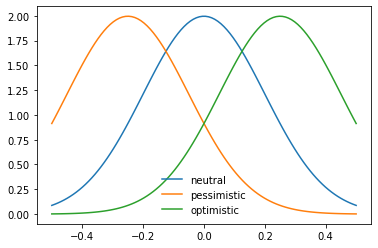

In [86]:
x = np.linspace(-0.5, 0.5, 100)

plt.plot(x, norm.pdf(x, 0, 0.2), label='neutral')
plt.plot(x, norm.pdf(x, -0.25, 0.2), label='pessimistic')
plt.plot(x, norm.pdf(x, 0.25, 0.2), label='optimistic')
plt.legend(['neutral', 'pessimistic', 'optimistic'], loc='best', frameon=False)
plt.show()

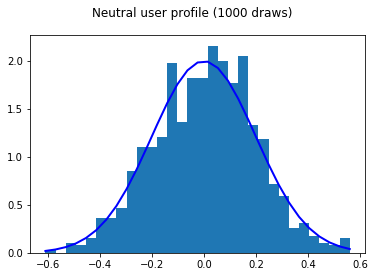

In [87]:
mu, sigma = 0, 0.2 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='b')
plt.suptitle('Neutral user profile (1000 draws)')
plt.show()

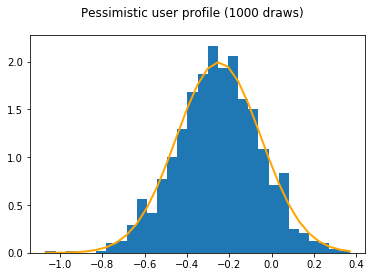

In [79]:
mu, sigma = -0.25, 0.2 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='orange')
plt.suptitle('Pessimistic user profile (1000 draws)')
plt.show()

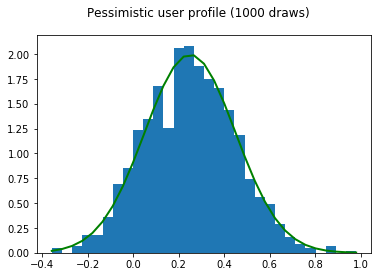

In [83]:
mu, sigma = 0.25, 0.2 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='green')
plt.suptitle('Pessimistic user profile (1000 draws)')
plt.show()

In [47]:
N = 1000
annotation_min_length = 2
annotation_max_length = 100

In [85]:
users

<QuerySet [<User: alexb>, <User: cezarym>, <User: robertot>, <User: jennifere>, <User: michelled>, <User: alejandror>, <User: grzegorzb>, <User: michalk>]>

In [89]:
# mu, sigma
user_profiles_dict = {
    'alexb': (0.0, 0.2), # neutral
    'robertot': (0.0, 0.2), # neutral
    'alejandror': (0.0, 0.2), # neutral
    'cezarym': (0.25, 0.2), # optimistic
    'michalk': (0.25, 0.2), # optimistic
    'grzegorzb': (0.25, 0.2), # optimistic
    'jennifere': (-0.25, 0.2), # pessimistic
    'michelled': (-0.25, 0.2) # pessimistic
    }


# Log generation

1. Get number of certainty annotations C (algorithm)
2. Calculate number of asserts (range 10-100% of C)
3. for each assert: 
    - 3.1 Pick random user 
    - 3.2 Generate random date
    - 3.3 Generate random certainty ['unknown', 'low', 'medium', 'high']
    - 3.4 Generate assert 
4. Save log:

```{
	"start_pos": 7895,
	"end_pos": 8237,
	"degree": 0.5,
	"certainty": ['low', 'medium', 'high']
	"description": "I'm not sure",
	"tag": "placeName",
    "content": "midste of May"
	"user": "grzegorzb",
	"date": "2018-12-21 04:57:16.704869+00:00",
	"file": "dep_820052r039.xml"
} 
```

In [98]:
assert_log = []

In [99]:
acc = 0
for the_file in files:
    print(the_file.name)
    f_download = the_file.download()
    f_content = f_download.getvalue().decode('UTF-8').replace('<br/>', ' ')
    soup = BeautifulSoup(f_content)
    machine_annotations = soup.find("classcode").findAll("certainty")
    n_asserts = random.randint(math.floor(len(machine_annotations) * 0.1), math.floor(len(machine_annotations) * 1.5))
    print('Will make %s asserts for %s annotations' % (n_asserts, len(machine_annotations)))
    for annotation in random.choices(machine_annotations, k=n_asserts):
        the_user = str(random.choice(users))
        if float(annotation['degree']) < 0.5 and random.random() < 0.1: #10% of the times the user is unsure and generates 'unknown'
            discretized_certainty = 'unknown'
        else:
            mu, sigma = user_profiles_dict[the_user]
            computed_certainty = float(annotation['degree']) + np.random.normal(mu, sigma, 1)[0]
            if computed_certainty < 0.33:
                discretized_certainty = 'low'
            elif computed_certainty < 0.66:
                discretized_certainty = 'medium'
            else:
                discretized_certainty = 'high'
        
        assert_log.append({
            'user' : str(random.choice(users)),
            'date' : str(timezone.now() - timezone.timedelta(days=random.randrange(1, 365), hours=random.randrange(1,24))),
            'certainty' : discretized_certainty,
            'degree' : annotation['degree'],
            'assertedvalue' : annotation['assertedvalue'],
            'text' : soup.find(annotation['assertedvalue'].lower(), {"xml:id" : annotation['target'].replace('#','')}).text,
            'file' : the_file.name
        })    

dep_836107r056_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 119 asserts for 94 annotations
dep_836024r018_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 85 asserts for 104 annotations
dep_836101r054_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 17 asserts for 42 annotations
dep_836156r077_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 80 asserts for 61 annotations
dep_833115r089_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 94 asserts for 80 annotations
dep_814014r003_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 43 asserts for 56 annotations
dep_833034r026_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 107 asserts for 96 annotations
dep_834182r147_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 34 asserts for 78 annotations
dep_836082r045_tei_(o

dep_833273r192_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 8 asserts for 11 annotations
dep_829260r172_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 25 asserts for 31 annotations
dep_838056r086_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 7 asserts for 40 annotations
dep_809018r006_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 11 asserts for 36 annotations
dep_834075v058_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 29 asserts for 35 annotations
dep_837008r007_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 49 asserts for 43 annotations
dep_836161r078_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 23 asserts for 31 annotations
dep_835105r163_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 58 asserts for 41 annotations
dep_834163r131_tei_(origin

Will make 37 asserts for 26 annotations
dep_833184r132_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 24 asserts for 17 annotations
dep_818202r170_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 15 asserts for 24 annotations
dep_839029r021_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 44 asserts for 31 annotations
dep_811135r100_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 10 asserts for 22 annotations
dep_819160r199_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 53 asserts for 36 annotations
dep_821047r026_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 16 asserts for 29 annotations
dep_810063r104_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 11 asserts for 32 annotations
dep_836120r065_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 14 asserts for

Will make 17 asserts for 28 annotations
dep_834056r040_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 5 asserts for 16 annotations
dep_829278r185_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 12 annotations
dep_829297r192_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 22 asserts for 19 annotations
dep_814231v143_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 12 asserts for 28 annotations
dep_833268r187_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 23 asserts for 28 annotations
dep_837002r003_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 26 asserts for 23 annotations
dep_834184v148_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 18 annotations
dep_836222r116_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 34 asserts for 24

Will make 16 asserts for 21 annotations
dep_829264r175_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 25 asserts for 22 annotations
dep_835172r216_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 26 asserts for 27 annotations
dep_817144r115_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 26 asserts for 18 annotations
dep_816088r034_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 22 annotations
dep_812281r224_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 9 asserts for 9 annotations
dep_835145r193_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 33 asserts for 22 annotations
dep_839118r080_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 15 asserts for 13 annotations
dep_830261r179_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 17 asserts for 17

Will make 19 asserts for 20 annotations
dep_833156r111_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 8 asserts for 12 annotations
dep_813160r116_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 7 annotations
dep_814123r071_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 11 asserts for 15 annotations
dep_819257r299_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 14 asserts for 15 annotations
dep_830009r014_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 19 asserts for 20 annotations
dep_809249r140_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 17 asserts for 19 annotations
dep_812062r085_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 11 asserts for 24 annotations
dep_835126r178_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 13 asserts for 25

Will make 10 asserts for 10 annotations
dep_836154r076_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 6 asserts for 14 annotations
dep_822020r019_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 11 asserts for 9 annotations
dep_837082v054_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 7 asserts for 13 annotations
dep_816031r016_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 12 asserts for 10 annotations
dep_821107r072_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 19 asserts for 18 annotations
dep_835142r191_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 21 asserts for 16 annotations
dep_838244r291_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 16 asserts for 12 annotations
dep_823072r069_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 13 

Will make 5 asserts for 12 annotations
dep_822069r060_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 17 asserts for 19 annotations
dep_833059r045_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 24 asserts for 16 annotations
dep_818041r073_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 3 annotations
dep_822079r069_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 14 asserts for 11 annotations
dep_821237r160_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 7 annotations
dep_818326r317_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 17 asserts for 14 annotations
dep_810184r230_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 23 asserts for 18 annotations
dep_809290r178_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 14 asserts for 12 a

Will make 13 asserts for 11 annotations
dep_833011r009_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 26 asserts for 19 annotations
dep_835137r186_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 6 asserts for 20 annotations
dep_809299r187_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 23 asserts for 17 annotations
dep_835246r272_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 12 asserts for 16 annotations
dep_835189r229_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 20 asserts for 14 annotations
dep_813220r150_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 8 asserts for 12 annotations
dep_818220r190_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 6 asserts for 8 annotations
dep_812001v003_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 14 a

Will make 10 asserts for 12 annotations
dep_836224r117_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 14 annotations
dep_815388r438_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 14 annotations
dep_834111r093_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 13 asserts for 19 annotations
dep_831267r200_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 11 asserts for 11 annotations
dep_833091r073_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 18 annotations
dep_836229r121_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 18 asserts for 17 annotations
dep_809263r152_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 28 asserts for 22 annotations
dep_837038r021_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 4 a

Will make 10 asserts for 16 annotations
dep_835188r228_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 13 asserts for 16 annotations
dep_836220r115_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 12 asserts for 16 annotations
dep_816333v219_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 8 asserts for 11 annotations
dep_837105r069_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 13 annotations
dep_821027r013_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 14 annotations
dep_823169r155_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 8 asserts for 9 annotations
dep_836016r013_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 11 annotations
dep_834004r004_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 8 asserts for 15 ann

Will make 5 asserts for 11 annotations
dep_834181r145_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 14 annotations
dep_810267r292_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 14 asserts for 18 annotations
dep_813263r194_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 9 annotations
dep_829202r129_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 14 asserts for 14 annotations
dep_813255r177_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 12 asserts for 10 annotations
dep_810103r164_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 17 asserts for 14 annotations
dep_834018r016_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 17 annotations
dep_820070r052_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 9 asserts for 13 an

Will make 2 asserts for 12 annotations
dep_833033r025_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 5 asserts for 14 annotations
dep_833146r105_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 7 annotations
dep_837047r026_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 8 asserts for 13 annotations
dep_839123r083_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 8 annotations
dep_838189r235_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 15 asserts for 10 annotations
dep_832198r188_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 16 annotations
dep_834092r080_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 9 annotations
dep_831095r092_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 13 asserts for 10 annota

Will make 2 asserts for 12 annotations
dep_820041r033_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 9 asserts for 11 annotations
dep_834174r139_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 13 asserts for 14 annotations
dep_821109r073_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 10 annotations
dep_834042r032_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 17 asserts for 13 annotations
dep_819255r297_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 10 asserts for 8 annotations
dep_821174r124_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 9 asserts for 14 annotations
dep_812145r143_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 6 asserts for 14 annotations
dep_816244r154_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 12 asserts for 8 ann

Will make 5 asserts for 12 annotations
dep_809310r197_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 15 asserts for 16 annotations
dep_810312r328_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 21 asserts for 15 annotations
dep_820172r141_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 17 asserts for 14 annotations
dep_813206r143_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 8 asserts for 8 annotations
dep_811186r133_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 6 asserts for 8 annotations
dep_820180r149_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 7 asserts for 12 annotations
dep_823219r198_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 12 annotations
dep_813149r110_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 5 asserts for 10 anno

Will make 5 asserts for 9 annotations
dep_836114r060_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 9 asserts for 14 annotations
dep_838210r260_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 18 annotations
dep_823078r074_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 7 asserts for 11 annotations
dep_833092r074_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 19 asserts for 14 annotations
dep_809306r193_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 5 asserts for 8 annotations
dep_823199r180_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 20 asserts for 19 annotations
dep_822023r022_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 27 asserts for 19 annotations
dep_833054r040_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 12 anno

Will make 8 asserts for 12 annotations
dep_821060r035_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 12 annotations
dep_818209r180_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 3 annotations
dep_821101r067_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 13 asserts for 16 annotations
dep_836184r088_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 7 asserts for 5 annotations
dep_833093r075_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 17 asserts for 12 annotations
dep_825001r002_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 11 asserts for 12 annotations
dep_817085r080_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 11 asserts for 15 annotations
dep_809144r077_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 11 asserts for 12 an

Will make 15 asserts for 10 annotations
dep_811164r119_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 12 annotations
dep_821135r094_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 12 asserts for 11 annotations
dep_822269r239_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 12 annotations
dep_830059r049_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 7 annotations
dep_821068r041_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 8 asserts for 13 annotations
dep_819229r270_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 15 asserts for 12 annotations
dep_835086r145_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 8 asserts for 11 annotations
dep_818069r093_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 6 asserts for 9 anno

Will make 14 asserts for 15 annotations
dep_822164r138_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 7 annotations
dep_830213r155_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 10 annotations
dep_819137r170_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 5 asserts for 7 annotations
dep_820072r054_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 6 asserts for 10 annotations
dep_823037r035_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 9 asserts for 10 annotations
dep_821118r080_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 7 annotations
dep_838164r217_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 6 asserts for 5 annotations
dep_828278r358_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 8 asserts for 13 annotati

Will make 13 asserts for 12 annotations
dep_838131r192_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 7 annotations
dep_829266r176_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 2 annotations
dep_823192r173_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 10 asserts for 11 annotations
dep_809224r121_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 10 asserts for 7 annotations
dep_820084r064_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 5 annotations
dep_837180r137A_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 4 annotations
dep_822021r020_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 6 annotations
dep_829241r160_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 10 annotat

Will make 5 asserts for 9 annotations
dep_828248r333_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 9 annotations
dep_839105r072_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 8 annotations
dep_810266r291_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 11 asserts for 17 annotations
dep_820250r210_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 9 annotations
dep_822032r030_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 12 asserts for 11 annotations
dep_819029r036_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 11 asserts for 9 annotations
dep_820088r068_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 8 asserts for 13 annotations
dep_811088r060_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 17 asserts for 13 annota

Will make 11 asserts for 9 annotations
dep_833074r057_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 8 asserts for 12 annotations
dep_812291r235_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 5 asserts for 5 annotations
dep_838047r047_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 9 annotations
dep_837184r142_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 8 annotations
dep_821161r114_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 9 asserts for 7 annotations
dep_823217r196_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 9 asserts for 7 annotations
dep_829307r198_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 10 asserts for 14 annotations
dep_819116r145_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 10 annotatio

Will make 4 asserts for 8 annotations
dep_819091r117_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 3 annotations
dep_820074r056_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 5 asserts for 9 annotations
dep_836244r129_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 15 asserts for 11 annotations
dep_812151v149_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 5 asserts for 8 annotations
dep_831224r160_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 9 annotations
dep_831047r058_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 16 asserts for 16 annotations
dep_820238r200_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 8 annotations
dep_829325r211_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 10 annotatio

Will make 14 asserts for 10 annotations
dep_819139r173_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 4 annotations
dep_813272r201_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 7 asserts for 7 annotations
dep_818323v312_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 18 asserts for 14 annotations
dep_810373r372_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 7 asserts for 7 annotations
dep_813168r122_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 15 asserts for 10 annotations
dep_820213r181_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 7 asserts for 10 annotations
dep_817239r181_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 8 annotations
dep_819113r143_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 7 annotat

dep_823204r184_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 6 annotations
dep_819149r185_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 4 annotations
dep_818229r198_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 4 annotations
dep_813085r070_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 5 asserts for 8 annotations
dep_838096v171_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 10 annotations
dep_812049r063_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 8 asserts for 6 annotations
dep_822012r013_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 6 asserts for 6 annotations
dep_836240r127_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 5 asserts for 5 annotations
dep_837001r002_tei_(original_normalized

Will make 10 asserts for 9 annotations
dep_823057r055_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 6 asserts for 10 annotations
dep_819209r249_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 7 asserts for 7 annotations
dep_819002r003_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 6 annotations
dep_830001r002_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 8 asserts for 9 annotations
dep_823044r042_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 7 asserts for 9 annotations
dep_822226r196_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 9 annotations
dep_810287r307_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 10 asserts for 10 annotations
dep_829455r306_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 10 annotatio

Will make 1 asserts for 6 annotations
dep_822188r160_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 9 asserts for 6 annotations
dep_810108r167_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 6 asserts for 11 annotations
dep_838063v106_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 3 annotations
dep_816315v199_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 3 annotations
dep_819306r358_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 8 asserts for 6 annotations
dep_811104r076_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 11 asserts for 8 annotations
dep_819135r167_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 11 asserts for 9 annotations
dep_822271r240_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 10 annotation

Will make 1 asserts for 9 annotations
dep_822224r194_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 5 asserts for 8 annotations
dep_810076v140_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 11 asserts for 12 annotations
dep_812317r258_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 5 annotations
dep_809092r050_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 8 annotations
dep_822260r230_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 11 asserts for 10 annotations
dep_829275r183_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 9 asserts for 7 annotations
dep_819299v350_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 5 asserts for 8 annotations
dep_813296r219_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 8 asserts for 9 annotation

Will make 11 asserts for 10 annotations
dep_816296r183_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 15 asserts for 10 annotations
dep_819130v162_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 6 asserts for 5 annotations
dep_810012r020_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 2 annotations
dep_819234r275_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 9 asserts for 6 annotations
dep_818046r077_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 9 annotations
dep_837103r067_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 1 annotations
dep_811033r012_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 8 asserts for 9 annotations
dep_839151r105_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 9 annotation

Will make 5 asserts for 6 annotations
dep_816262r166_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 6 annotations
dep_838064v110_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 9 annotations
dep_813017r010_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 8 annotations
dep_821105r071_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 9 asserts for 7 annotations
dep_810189r232_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 4 annotations
dep_809084r044_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 8 annotations
dep_810173r222_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 8 asserts for 10 annotations
dep_816315r197_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 4 annotations
d

dep_822247r217_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 8 annotations
dep_812144v142_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 6 asserts for 7 annotations
dep_838167r219_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 9 asserts for 6 annotations
dep_818306v296_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 6 asserts for 7 annotations
dep_811038r017_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 12 asserts for 8 annotations
dep_818052r082_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 7 asserts for 7 annotations
dep_822264r234_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 12 asserts for 8 annotations
dep_816176r105_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 2 annotations
dep_824097r088_tei_(original_normalize

Will make 2 asserts for 4 annotations
dep_820205r173_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 8 annotations
dep_822192r164_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 10 asserts for 9 annotations
dep_838051v070_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 6 asserts for 6 annotations
dep_818297v284_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 6 annotations
dep_820192r160_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 7 annotations
dep_822248r218_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 7 asserts for 7 annotations
dep_829219r142_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 5 asserts for 4 annotations
dep_809335r217_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 6 asserts for 8 annotations
d

Will make 1 asserts for 5 annotations
dep_819287r334_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 5 asserts for 4 annotations
dep_820193r161_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 5 asserts for 8 annotations
dep_810098r160_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 5 annotations
dep_810270r296_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 6 asserts for 8 annotations
dep_838062v102_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 3 annotations
dep_813082r065_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 2 annotations
dep_809085r046_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 7 annotations
dep_829393r265_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 10 annotations
d

Will make 3 asserts for 4 annotations
dep_823124r118_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 8 annotations
dep_813007r005_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 2 annotations
dep_827041r047_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 7 asserts for 5 annotations
dep_813037r020_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 4 annotations
dep_822097r085_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 5 annotations
dep_809255r145_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 5 annotations
dep_838212r261_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 7 annotations
dep_819038r049_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 3 annotations
de

Will make 3 asserts for 7 annotations
dep_837185r143_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 3 annotations
dep_812243r208_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 2 annotations
dep_818291v273_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 6 annotations
dep_833224r164_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 6 annotations
dep_830080r072_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 1 annotations
dep_810315r331_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 7 annotations
dep_830280r190_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 2 annotations
dep_819109v137_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 8 asserts for 8 annotations
de

dep_830082r073_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 2 annotations
dep_822234r204_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 5 annotations
dep_815322r386_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 4 annotations
dep_824153r136_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 6 annotations
dep_815143r229_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 6 annotations
dep_812026r025_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 5 asserts for 5 annotations
dep_819291v341_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 6 annotations
dep_818291r272_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 2 annotations
dep_812230v198_tei_(original_normalized_

Will make 8 asserts for 7 annotations
dep_810222r254_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 6 asserts for 6 annotations
dep_818309r298_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 4 annotations
dep_817211r166_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 4 annotations
dep_813381r318_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 3 annotations
dep_811126r093_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 3 annotations
dep_819049v065_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 4 annotations
dep_816338r222_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 6 annotations
dep_819071v095_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 1 annotations
de

Will make 1 asserts for 2 annotations
dep_818325r315_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 4 annotations
dep_812295r238_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 9 asserts for 8 annotations
dep_823053r051_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 5 asserts for 5 annotations
dep_835008v014_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 6 annotations
dep_820194r162_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 6 annotations
dep_838204r253_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 3 annotations
dep_839001r002_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 3 annotations
dep_829354r231_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 5 annotations
de

Will make 0 asserts for 2 annotations
dep_828183r272_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 9 asserts for 6 annotations
dep_819066r087_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 2 annotations
dep_811151r111_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 5 annotations
dep_829400r271_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 8 asserts for 8 annotations
dep_828159r233_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 5 annotations
dep_819037v047_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 5 annotations
dep_815334r390_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 3 annotations
dep_830114r092_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 2 annotations
de

Will make 0 asserts for 3 annotations
dep_819273r320_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 1 annotations
dep_819157r195_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 2 annotations
dep_812025r024_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 2 annotations
dep_815056r116_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 2 annotations
dep_819118r147_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 2 annotations
dep_809202r106_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 3 annotations
dep_818260v241_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 2 annotations
dep_837139r105_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 3 annotations
de

Will make 0 asserts for 3 annotations
dep_810262r287_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 4 annotations
dep_832103v099_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 3 annotations
dep_809217r116_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 6 asserts for 5 annotations
dep_819310r362_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 4 annotations
dep_828089r125_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 6 asserts for 6 annotations
dep_818022r051_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 5 annotations
dep_828288r365_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 5 asserts for 5 annotations
dep_813284r210_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 2 annotations
de

Will make 0 asserts for 4 annotations
dep_812155r151_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 9 asserts for 6 annotations
dep_810341r353_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 3 annotations
dep_830282r193_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 2 annotations
dep_830045r041_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 1 annotations
dep_813075r043_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 2 annotations
dep_828141r203_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 5 asserts for 5 annotations
dep_814042v006_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 2 annotations
dep_828121v179_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 2 annotations
de

Will make 0 asserts for 2 annotations
dep_828077r104_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 6 asserts for 4 annotations
dep_828156r227_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 5 asserts for 4 annotations
dep_832099r087_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 3 annotations
dep_819252v294_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 6 asserts for 4 annotations
dep_814234r144_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 2 annotations
dep_830079r071_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 2 annotations
dep_813378r292_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 4 annotations
dep_835033r045_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 3 annotations
de

Will make 1 asserts for 1 annotations
dep_817190r150_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 3 annotations
dep_832101v093_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 3 annotations
dep_828009r016_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 3 annotations
dep_835063v114_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 3 annotations
dep_813380v306_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 2 annotations
dep_819208r248_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 2 annotations
dep_810155v204_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 5 asserts for 4 annotations
dep_819061r082_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 2 annotations
de

Will make 1 asserts for 2 annotations
dep_829414r281_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 5 asserts for 4 annotations
dep_829393v267_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 2 annotations
dep_828086v121_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 2 annotations
dep_817007r018_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 5 asserts for 4 annotations
dep_828047v064_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 2 annotations
dep_828009v018_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 2 annotations
dep_828148v217_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 2 annotations
dep_810246r275_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 2 annotations
de

Will make 0 asserts for 2 annotations
dep_828117r172_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 2 annotations
dep_828105r151_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 2 annotations
dep_828233r317_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 2 annotations
dep_818237v210_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 2 annotations
dep_828081v112_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 2 annotations
dep_828098r139_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 2 annotations
dep_832000r001_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 3 annotations
dep_828067r090_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 2 annotations
de

Will make 1 asserts for 2 annotations
dep_821306r197_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 3 annotations
dep_814046r011_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 3 annotations
dep_832047v005_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 4 asserts for 3 annotations
dep_812038v051_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 4 annotations
dep_828036r045_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 2 annotations
dep_818018r041_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 2 annotations
dep_828179r267_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 2 annotations
dep_820369r302_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 2 annotations
de

Will make 0 asserts for 2 annotations
dep_831001r001_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 1 annotations
dep_815007r008_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 2 annotations
dep_822000r001_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 2 annotations
dep_813256r182_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 2 annotations
dep_828186v283_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 1 asserts for 2 annotations
dep_828161r237_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 3 asserts for 2 annotations
dep_828119r175_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 2 asserts for 2 annotations
dep_828174r258_tei_(original_normalized_depositions_marked_persons_gazetteer).xml
Will make 0 asserts for 2 annotations
de

In [100]:
len(assert_log)

26512

In [101]:
with open('assert_log.json', 'w') as outfile:
    json.dump(assert_log, outfile)

In [106]:
assert_log[210]

{'user': 'alexb',
 'date': '2019-08-08 11:55:42.688665+00:00',
 'certainty': 'medium',
 'degree': '0.75',
 'assertedvalue': 'date',
 'text': '1641',
 'file': 'dep_836101r054_tei_(original_normalized_depositions_marked_persons_gazetteer).xml'}